# Code used for generating figures
All figures apart from pathway illustrations and plots based on previously published data can be generated with the code below.

We reuse functions defined in the document "IterativeConstruction_SharedFunctions.ipynb" here and in other files. The respective functions are defined and explained in the shared notebook

We use data generated by executing "IterativeConstruction_NutrientRichEnsemble" here. Please execute the respective code before generating figures here.

In [844]:
# The notebook which holds the shared functions first needs to be converted to an .py file to be imported
!jupyter nbconvert IterativeConstruction_SharedFunctions.ipynb --to python

#Import of required packages and the shared functions
from IterativeConstruction_SharedFunctions import *;

import numpy as np
import pandas as pd
import scipy as scp
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.stats import linregress
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
import matplotlib.colors
from matplotlib.colors import ListedColormap
from  matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import string
import warnings
warnings.filterwarnings("ignore")

font = {'size'   : 25} #20
plt.rcParams.update({'axes.titlesize': 'medium'})
plt.rc('font', **font)

#colormaps
cmaprbg=LinearSegmentedColormap.from_list('rg',["r", "k", "g"], N=256)
cm = plt.cm.get_cmap('Spectral')

N = 256
vals = np.ones((N, 4)) #default alpha = 1
xs = np.linspace(0, 1, N)
vals[:, 0] = np.zeros(N)  #red
vals[:, 1] = 1-xs  #green
vals[:, 2] = 1-xs/3  #blue

Qcm = ListedColormap(vals[::-1])
cmQ = Qcm


N = 2048
vmin = -1
vmax = 3
vals = cm((np.log10(1/(1/xs-1))-vmin)/(vmax-vmin))#cm(xs**3)
cm3 = ListedColormap(vals)

data_folder = "/Users/leonseeger/Desktop/largeDBFiles/"

[NbConvertApp] Converting notebook IterativeConstruction_SharedFunctions.ipynb to python
[NbConvertApp] Writing 14323 bytes to IterativeConstruction_SharedFunctions.py


(4928, 100, 6, 10)
(4928, 3, 6, 1, 10)
(4928, 1, 10)
[1.58173681 0.35061285 3.68894989 1.8399506  6.15460124 0.30000493
 0.42412649 0.93169585 0.93103002 4.88795615]


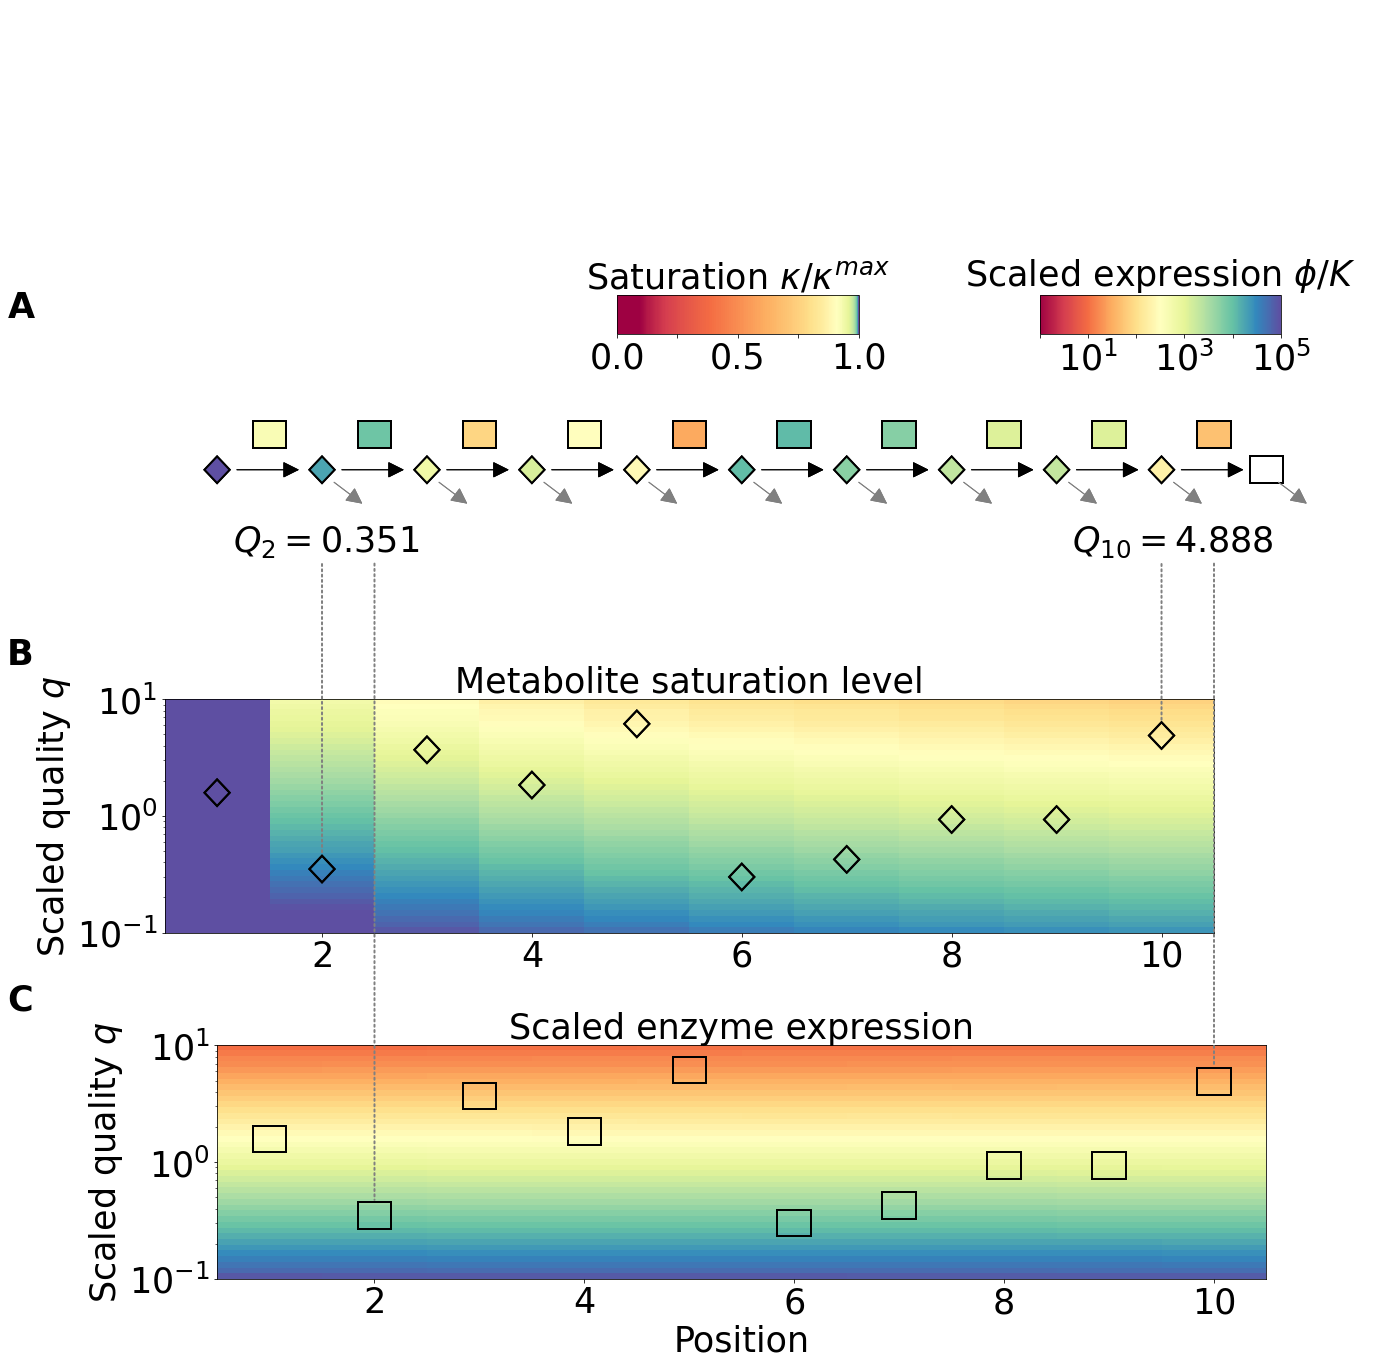

In [889]:
#remove

#### Linear Chain
#The pattern in panel A is selected randomly and may not match the pattern depicted in the manuscript

font = {'size'   : 35}
plt.rc('font', **font)

fig, axs = plt.subplots(4, 1, figsize = (20, 20))
Nenzymes = 10

sigma = "phys_10"
filename = "Ensemble_Rich_sigma_%s.npy"%sigma

fullensemble = np.load(data_folder+filename)

fullensemble = fullensemble[~np.isnan(fullensemble[:, 70, 3, -1])]
print(np.shape(fullensemble))

KMmean = np.exp(np.mean(np.log(fullensemble[:, 0, 1, :])))
efficiencybins = np.logspace(-1.4, 1.4, 58)#*np.sqrt(KMmean*Nenzymes)

ilocs = []
ensemble = []

for j in range(np.shape(fullensemble)[0]):
    maxgr = fullensemble[j, 0, 5, 0]
    halfgrs = (fullensemble[j, :, 5, 0].T-maxgr/2.1).T
    halfgrs[halfgrs<0] = np.max(halfgrs)
    tenthgrs = (fullensemble[j, :, 5, 0].T-maxgr/10.1).T
    tenthgrs[tenthgrs<0] = np.max(tenthgrs)
    
    iloc = np.where(halfgrs == np.nanmin(halfgrs))
    iloc10 = np.where(tenthgrs == np.nanmin(tenthgrs))
    ilocs.append(iloc[0][0])
    ensemble.append(np.array([fullensemble[j, 0], fullensemble[j, iloc[0][0]], fullensemble[j, iloc10[0][0]]]))
    #print(np.shape(np.array([ensemble[j, 0], ensemble[j, iloc]])))

ilocs = np.array(ilocs)
ensemble = np.array(ensemble)[:, :, :, None, ::-1]

#print(np.shape(smallensemble))
efficiencies = np.sqrt(fullensemble[:, 0, 0, :].T*fullensemble[:, 0, 1, :].T/fullensemble[:, 0, 5, 0]).T/np.sqrt(KMmean*Nenzymes)
#efficiencies = np.sqrt(fullensemble[:, 0, 0, :].T*fullensemble[:, 0, 1, :].T/fullensemble[:, 0, 5, 0]).T
#efficiencies = (np.sum(fullensemble[:, 0, 0, :]**(-1), 1)/np.sum(np.sqrt(fullensemble[:, 0, 1, :]/fullensemble[:, 0, 0, :]), 1)*np.sqrt(fullensemble[:, 0, 1, :]*fullensemble[:, 0, 0, :]).T).T
efficiencies = efficiencies[:, None, ::-1]
print(np.shape(ensemble))
print(np.shape(efficiencies))


branch = 0
colormeshrho = np.zeros((Nenzymes, np.shape(efficiencybins)[0]-1))
colormeshphi = np.zeros((Nenzymes, np.shape(efficiencybins)[0]-1))
for i in range(np.shape(efficiencybins)[0]-1):
    mask = (efficiencies[:, branch, :]>efficiencybins[i])*(efficiencies[:, branch, :]<=efficiencybins[i+1])
    fullmask = mask[:, None, None, :]*np.ones((np.shape(ensemble)[1], np.shape(ensemble)[2]))[None, :, :, None]
    maskeddata = np.where(fullmask, ensemble[:, :, :, branch, :], np.nan)
    logsaturation = np.log10(maskeddata[:, 0, 3, :]/maskeddata[:, 0, 1, :])
    logexpression = np.log10(maskeddata[:, 0, 4, :]/maskeddata[:, 0, 1, :])
    colormeshrho[:, i] = np.nanmean(logsaturation, 0)
    colormeshphi[:, i] = np.nanmean(logexpression, 0)
    
for j in range(Nenzymes):
    colormeshrho[j, :] = savgol_filter(colormeshrho[j, :], 20, 2)
    colormeshphi[j, :] = savgol_filter(colormeshphi[j, :], 20, 2)
    
heatmap = axs[2].pcolormesh(np.arange(Nenzymes)+1, np.sqrt(efficiencybins[1:]*efficiencybins[:-1])*0.9, 1/(1+10**(-colormeshrho.T)), cmap = cm3, vmin = 0, vmax = 1)
axs[2].pcolormesh(np.arange(Nenzymes)+1, np.sqrt(efficiencybins[1:]*efficiencybins[:-1])*0.9, colormeshrho.T, cmap = cm, vmin = -1, vmax = 3)
heatmap2 = axs[3].pcolormesh(np.arange(Nenzymes)+1, np.sqrt(efficiencybins[1:]*efficiencybins[:-1])*0.9, colormeshphi.T, cmap = cm, vmin = 0, vmax = 5)

axs[2].set_title(r'Metabolite saturation level')
axs[3].set_title(r'Scaled enzyme expression')
axs[1].set_yscale("log")
axs[2].set_yscale("log")
axs[3].set_yscale("log")
axs[1].set_xlim(0.5, Nenzymes+2)
axs[2].set_xlim(0.5, Nenzymes+0.5)
axs[3].set_xlim(0.5, Nenzymes+0.5)
axs[1].set_ylim(0.1, 10)
#axs[2].set_ylim(0.1*np.sqrt(KMmean*Nenzymes), 10*np.sqrt(KMmean*Nenzymes))
#axs[3].set_ylim(0.1*np.sqrt(KMmean*Nenzymes), 10*np.sqrt(KMmean*Nenzymes))
axs[2].set_ylim(0.1, 10)
axs[3].set_ylim(0.1, 10)
axs[2].set_ylabel(r"Scaled quality $q$")
axs[3].set_ylabel(r"Scaled quality $q$")
axs[3].set_xlabel("Position")

efficiencybins = np.logspace(-1.4, 1.4, 8)*np.sqrt(KMmean*Nenzymes)

#isample = 5
findGood = np.copy(efficiencies)
#findGood[findGood<0.15*np.sqrt(KMmean*Nenzymes)] = np.nan
#findGood[findGood>1/0.15*np.sqrt(KMmean*Nenzymes)] = np.nan
findGood[findGood<0.15] = np.nan
findGood[findGood>1/0.15] = np.nan
findGood2 = np.copy(efficiencies[:, 0, 0])
findGood2[np.any(np.isnan(findGood[:, 0, :]), axis = 1)] = np.nan
isample = np.random.choice(np.where(~np.isnan(findGood2))[0])
print(efficiencies[isample, 0, :])

for i in [0, 2]:
    for j in range(Nenzymes):
        #axs[1].add_patch(plt.Polygon([[j+.83, efficiencybins[height[j]]*1.1], [j+.83, efficiencybins[height[j]+1]*.9], [j+1.17, efficiencybins[height[j]+1]*.9], [j+1.17, efficiencybins[height[j]]*1.1]],facecolor=(0, 0, 0, 0), edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2))
        axs[2].add_patch(plt.Polygon([[j+.88, efficiencies[isample, 0, j]], [j+1, efficiencies[isample, 0, j]*1.3], [j+1.12, efficiencies[isample, 0, j]], [j+1, efficiencies[isample, 0, j]/1.3]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2, facecolor=(0,0,0,0)))#facecolor=cm(np.log10(ensemble[isample, 0, 3, 0, j]/ensemble[isample, 0, 1, 0, j])/3)))
        axs[3].add_patch(plt.Polygon([[j+.84, efficiencies[isample, 0, j]*1.3], [j+.84, efficiencies[isample, 0, j]/1.3], [j+1.16, efficiencies[isample, 0, j]/1.3], [j+1.16, efficiencies[isample, 0, j]*1.3]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2, facecolor=(0,0,0,0)))#facecolor=cm(np.log10(ensemble[isample, 0, 4, 0, j]/ensemble[isample, 0, 1, 0, j])/5)))
        axs[1].add_patch(plt.Polygon([[j+.88, 1], [j+1, 1.3], [j+1.12, 1], [j+1, 1/1.3]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2, facecolor=cm((np.log10(ensemble[isample, 0, 3, 0, j]/ensemble[isample, 0, 1, 0, j])-vmin)/(vmax-vmin))))
        axs[1].add_patch(plt.Polygon([[j+.84+.5, 2*1.3], [j+.84+.5, 2/1.3], [j+1.16+.5, 2/1.3], [j+1.16+.5, 2*1.3]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2, facecolor=cm(np.log10(ensemble[isample, 0, 4, 0, j]/ensemble[isample, 0, 1, 0, j])/5)))
        axs[1].annotate("", xy = (j+1.8, 1), xytext = (j+1.17, 1), arrowprops=dict(arrowstyle="-|>", color='k'))
        axs[1].annotate("", xy = (j+2.4, .5), xytext = (j+2.1, 0.8), arrowprops=dict(arrowstyle="-|>", color='grey'))

        
#axs[1].annotate("", xy = (Nenzymes+1.8, 1), xytext = (Nenzymes+1.17, 1), arrowprops=dict(arrowstyle="-|>", color='k'))

axs[1].add_patch(plt.Polygon([[j+.84+1, 1*1.3], [j+.84+1, 1/1.3], [j+1.16+1, 1/1.3], [j+1.16+1, 1*1.3]],facecolor=(0, 0, 0, 0), edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2))
    
    
fig.tight_layout()

axins = inset_axes(axs[1], width="20%", height="17%", loc=1, bbox_to_anchor=(-0.425, .25, 1, 1), bbox_transform=axs[1].transAxes, borderpad=0)
cb = fig.colorbar(heatmap, orientation='horizontal', cax=axins)#, label = r"Low          High")
#axins.set_xticks([0, 1, 2, 3, 4])
axins.set_xticks([0, 0.25, 0.50, 0.75, 1])
axins.set_xticklabels([r"0.0", "", r"0.5", "", r"1.0"])
#axins.set_xticklabels([r"$10^0$", "", r"$10^2$", "", r"$10^4$"])
#axins.set_title(r"Saturation $\rho/K$")
axins.set_title(r"Saturation $\kappa/\kappa^{max}$")

axins2 = inset_axes(axs[1], width="20%", height="17%", loc=1, bbox_to_anchor=(-0.075, .25, 1, 1), bbox_transform=axs[1].transAxes, borderpad=0)
cb = fig.colorbar(heatmap2, orientation='horizontal', cax=axins2)#, label = r"Low          High")
axins2.set_xticks([0, 1, 2, 3, 4, 5])
axins2.set_xticklabels(["", r"$10^1$", "", r"$10^3$", "", r"$10^5$"])
axins2.set_title(r"Scaled expression $\phi/K$")

#fig.tight_layout()

for i in [2, 10]:
    axs[1].annotate(r"$Q_{%d} =$%.3f"%(i, efficiencies[isample, 0, i-1]), xy = (i-.85, 2e-1), xytext = (i-.85, 2e-1), arrowprops=dict(arrowstyle="-", color='w'))
    axs[2].annotate(r"", xy = (i, efficiencies[isample, 0, i-1]*1.3), xytext = (i, 150), arrowprops=dict(arrowstyle="-", linestyle = ":", color='grey', linewidth = 2))
    axs[3].annotate(r"", xy = (i, efficiencies[isample, 0, i-1]*1.3), xytext = (i, 140000), arrowprops=dict(arrowstyle="-", linestyle = ":", color='grey', linewidth = 2))

axs[0].axis("off")
axs[1].axis("off")

divider = make_axes_locatable(axs[1])
#cax = divider.append_axes("right", size="5%", pad=0).axis('off')
        
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size="15%", pad=0).axis('off')

divider = make_axes_locatable(axs[3])
cax = divider.append_axes("right", size="10%", pad=0).axis('off')
cax = divider.append_axes("left", size="5%", pad=0).axis('off')

for n, ax in enumerate(axs[1:]):  
    ax.text(-0.1-0.05*n-(0.03*(n==0)), 1.15, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')

#plt.savefig("/Users/leonseeger/Dropbox/EffluxPumpsLeon/Draft/CommentingVersion/MainText1.pdf", bbox_inches="tight", format = 'pdf')

(4928, 100, 6, 10)
(4928, 3, 6, 1, 10)
(4928, 1, 10)
[0.02405669 0.0639545  0.074407   0.03719713 0.03715338 0.01308427
 0.03301921 0.08591314 0.1006382  0.0230111 ]


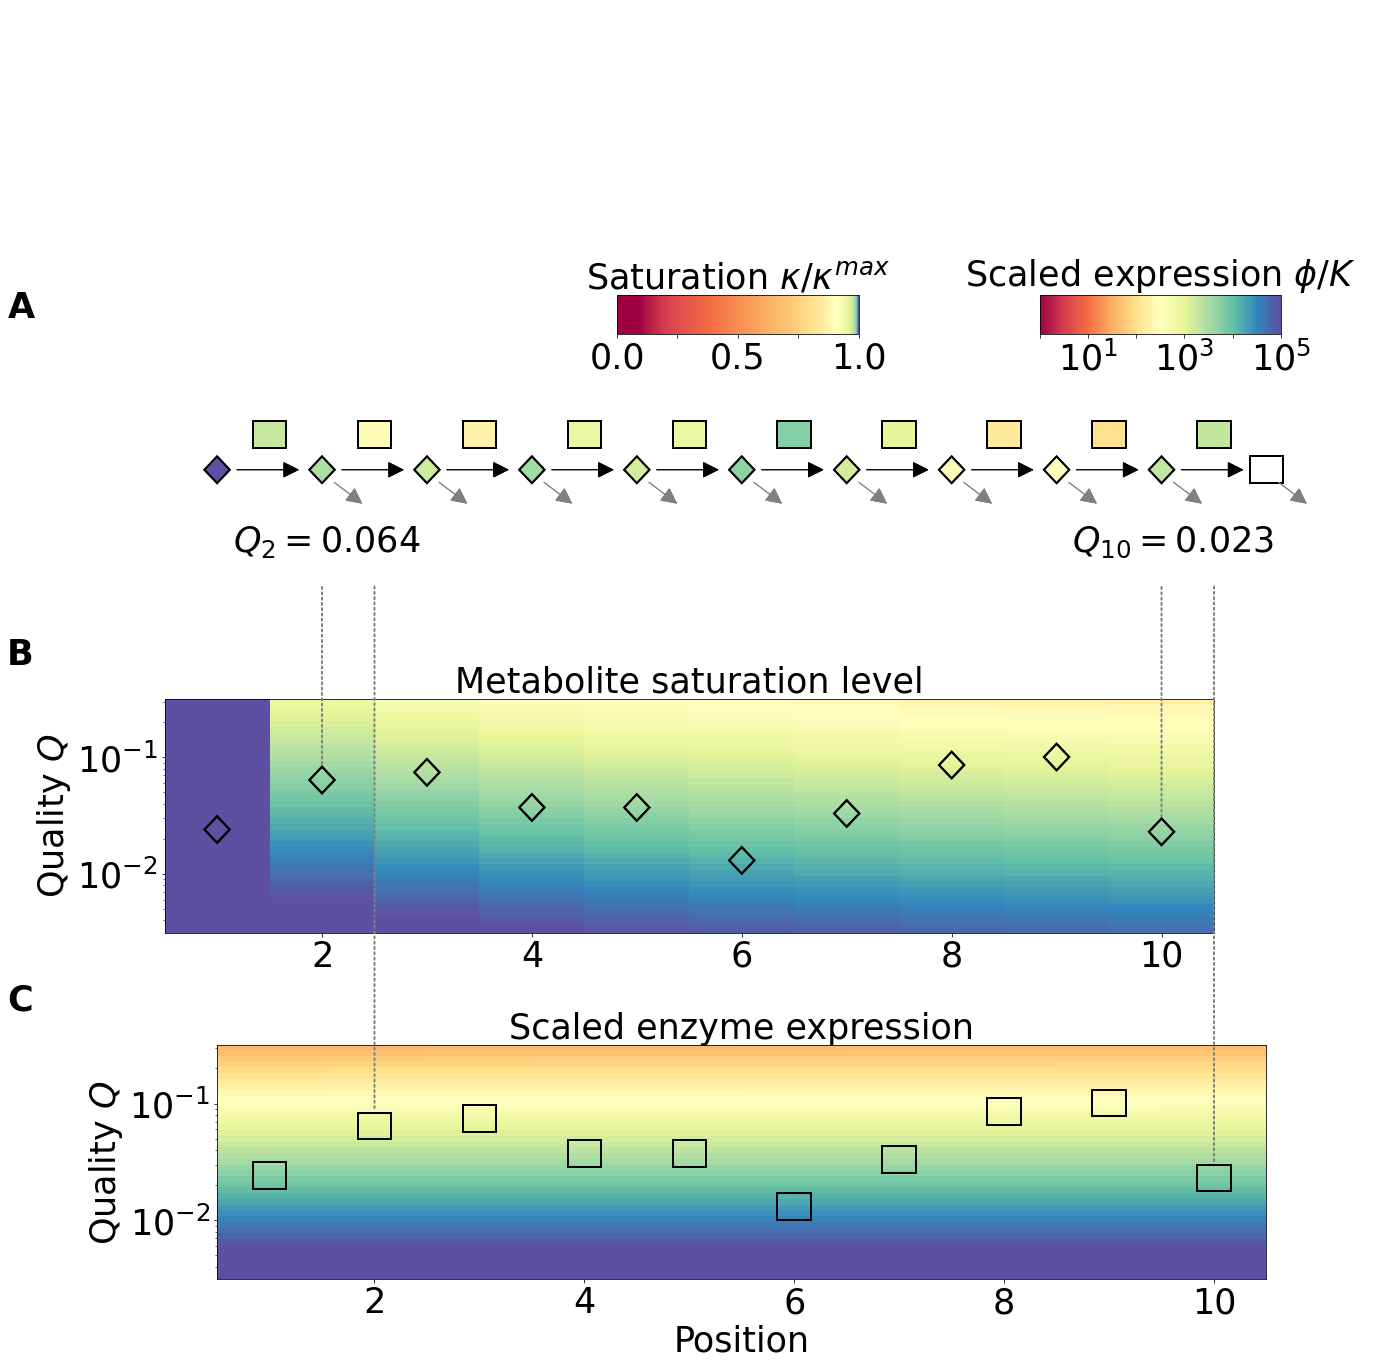

In [846]:
#remove

#### Option2: Analytical approximation of the map
font = {'size'   : 35} #20
plt.rc('font', **font)

fig, axs = plt.subplots(4, 1, figsize = (20, 20))
Nenzymes = 10

#cm = plt.cm.get_cmap('RdYlGn')

sigma = "phys_10"
filename = "Ensemble_Rich_sigma_%s.npy"%sigma

fullensemble = np.load(data_folder+filename)

fullensemble = fullensemble[~np.isnan(fullensemble[:, 70, 3, -1])]
print(np.shape(fullensemble))


efficiencybins = np.logspace(-1.4, 1.4, 58)*np.sqrt(KMmean*Nenzymes)#8

branch = 0
ilocs = []
ensemble = []
for j in range(np.shape(fullensemble)[0]):
    maxgr = fullensemble[j, 0, 5, 0]
    halfgrs = (fullensemble[j, :, 5, 0].T-maxgr/2.1).T
    halfgrs[halfgrs<0] = np.max(halfgrs)
    tenthgrs = (fullensemble[j, :, 5, 0].T-maxgr/10.1).T
    tenthgrs[tenthgrs<0] = np.max(tenthgrs)
    
    iloc = np.where(halfgrs == np.nanmin(halfgrs))
    iloc10 = np.where(tenthgrs == np.nanmin(tenthgrs))
    ilocs.append(iloc[0][0])
    ensemble.append(np.array([fullensemble[j, 0], fullensemble[j, iloc[0][0]], fullensemble[j, iloc10[0][0]]]))
    #print(np.shape(np.array([ensemble[j, 0], ensemble[j, iloc]])))

ilocs = np.array(ilocs)
ensemble = np.array(ensemble)[:, :, :, None, ::-1]

#print(np.shape(smallensemble))
efficiencies = np.sqrt(fullensemble[:, 0, 0, :].T*fullensemble[:, 0, 1, :].T/fullensemble[:, 0, 5, 0]).T#/np.sqrt(KMmean*Nenzymes)
#efficiencies = (np.sum(fullensemble[:, 0, 0, :]**(-1), 1)/np.sum(np.sqrt(fullensemble[:, 0, 1, :]/fullensemble[:, 0, 0, :]), 1)*np.sqrt(fullensemble[:, 0, 1, :]*fullensemble[:, 0, 0, :]).T).T
efficiencies = efficiencies[:, None, ::-1]
print(np.shape(ensemble))
print(np.shape(efficiencies))


findGood = np.copy(efficiencies)
findGood[fullensemble[:, 0, 5, :][:, None, :]>5] = np.nan
findGood[findGood<0.15*np.sqrt(KMmean*Nenzymes)] = np.nan
findGood[findGood>1/0.15*np.sqrt(KMmean*Nenzymes)] = np.nan
findGood2 = np.copy(efficiencies[:, 0, 0])
findGood2[np.any(np.isnan(findGood[:, 0, :]), axis = 1)] = np.nan
isample = np.random.choice(np.where(~np.isnan(findGood2))[0])
print(efficiencies[isample, 0, :])

colormeshrho = np.zeros((Nenzymes, np.shape(efficiencybins)[0]-1))
colormeshphi = np.zeros((Nenzymes, np.shape(efficiencybins)[0]-1))

meshx, meshy = np.meshgrid(np.arange(Nenzymes), np.sqrt(efficiencybins[1:]*efficiencybins[:-1]))
colormeshrho = np.log10(np.sqrt(Nenzymes/meshx*fullensemble[isample, 0, 5, 0])*1/meshy).T
colormeshphi = np.log10(meshx.T/Nenzymes*10**colormeshrho*(1+10**colormeshrho))

colormeshrho[0, :] = 1e3
colormeshphi[0, :] = np.log10(fullensemble[isample, 0, 5, 0]/np.sqrt(efficiencybins[1:]*efficiencybins[:-1])**2)
#print(colormeshphi[:2, :])
    
heatmap = axs[2].pcolormesh(np.arange(Nenzymes)+1, np.sqrt(efficiencybins[1:]*efficiencybins[:-1])*0.9, 1/(1+10**(-colormeshrho.T)), cmap = cm3, vmin = 0, vmax = 1)
axs[2].pcolormesh(np.arange(Nenzymes)+1, np.sqrt(efficiencybins[1:]*efficiencybins[:-1])*0.9, colormeshrho.T, cmap = cm, vmin = -1, vmax = 3)
heatmap2 = axs[3].pcolormesh(np.arange(Nenzymes)+1, np.sqrt(efficiencybins[1:]*efficiencybins[:-1])*0.9, colormeshphi.T, cmap = cm, vmin = 0, vmax = 5)

axs[2].set_title(r'Metabolite saturation level')
axs[3].set_title(r'Scaled enzyme expression')
axs[1].set_yscale("log")
axs[2].set_yscale("log")
axs[3].set_yscale("log")
axs[1].set_xlim(0.5, Nenzymes+2)
axs[2].set_xlim(0.5, Nenzymes+0.5)
axs[3].set_xlim(0.5, Nenzymes+0.5)
axs[1].set_ylim(0.1, 10)
axs[2].set_ylim(0.1*np.sqrt(KMmean*Nenzymes), 10*np.sqrt(KMmean*Nenzymes))
axs[3].set_ylim(0.1*np.sqrt(KMmean*Nenzymes), 10*np.sqrt(KMmean*Nenzymes))
axs[2].set_ylabel(r"Quality $Q$")
axs[3].set_ylabel(r"Quality $Q$")
axs[3].set_xlabel("Position")

efficiencybins = np.logspace(-1.4, 1.4, 8)

#isample = 5

for i in [0, 2]:
    for j in range(Nenzymes):
        #axs[1].add_patch(plt.Polygon([[j+.83, efficiencybins[height[j]]*1.1], [j+.83, efficiencybins[height[j]+1]*.9], [j+1.17, efficiencybins[height[j]+1]*.9], [j+1.17, efficiencybins[height[j]]*1.1]],facecolor=(0, 0, 0, 0), edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2))
        axs[2].add_patch(plt.Polygon([[j+.88, efficiencies[isample, 0, j]], [j+1, efficiencies[isample, 0, j]*1.3], [j+1.12, efficiencies[isample, 0, j]], [j+1, efficiencies[isample, 0, j]/1.3]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2, facecolor=(0,0,0,0)))#facecolor=cm(np.log10(ensemble[isample, 0, 3, 0, j]/ensemble[isample, 0, 1, 0, j])/3)))
        axs[3].add_patch(plt.Polygon([[j+.84, efficiencies[isample, 0, j]*1.3], [j+.84, efficiencies[isample, 0, j]/1.3], [j+1.16, efficiencies[isample, 0, j]/1.3], [j+1.16, efficiencies[isample, 0, j]*1.3]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2, facecolor=(0,0,0,0)))#facecolor=cm(np.log10(ensemble[isample, 0, 4, 0, j]/ensemble[isample, 0, 1, 0, j])/5)))
        axs[1].add_patch(plt.Polygon([[j+.88, 1], [j+1, 1.3], [j+1.12, 1], [j+1, 1/1.3]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2, facecolor=cm((np.log10(ensemble[isample, 0, 3, 0, j]/ensemble[isample, 0, 1, 0, j])-vmin)/(vmax-vmin))))
        axs[1].add_patch(plt.Polygon([[j+.84+.5, 2*1.3], [j+.84+.5, 2/1.3], [j+1.16+.5, 2/1.3], [j+1.16+.5, 2*1.3]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2, facecolor=cm(np.log10(ensemble[isample, 0, 4, 0, j]/ensemble[isample, 0, 1, 0, j])/5)))
        axs[1].annotate("", xy = (j+1.8, 1), xytext = (j+1.17, 1), arrowprops=dict(arrowstyle="-|>", color='k'))
        axs[1].annotate("", xy = (j+2.4, .5), xytext = (j+2.1, 0.8), arrowprops=dict(arrowstyle="-|>", color='grey'))

        
#axs[1].annotate("", xy = (Nenzymes+1.8, 1), xytext = (Nenzymes+1.17, 1), arrowprops=dict(arrowstyle="-|>", color='k'))

axs[1].add_patch(plt.Polygon([[j+.84+1, 1*1.3], [j+.84+1, 1/1.3], [j+1.16+1, 1/1.3], [j+1.16+1, 1*1.3]],facecolor=(0, 0, 0, 0), edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2))
fig.tight_layout()

axins = inset_axes(axs[1], width="20%", height="17%", loc=1, bbox_to_anchor=(-0.425, .25, 1, 1), bbox_transform=axs[1].transAxes, borderpad=0)
cb = fig.colorbar(heatmap, orientation='horizontal', cax=axins)#, label = r"Low          High")
#axins.set_xticks([0, 1, 2, 3, 4])
axins.set_xticks([0, 0.25, 0.50, 0.75, 1])
axins.set_xticklabels([r"0.0", "", r"0.5", "", r"1.0"])
#axins.set_xticklabels([r"$10^0$", "", r"$10^2$", "", r"$10^4$"])
#axins.set_title(r"Saturation $\rho/K$")
axins.set_title(r"Saturation $\kappa/\kappa^{max}$")

axins2 = inset_axes(axs[1], width="20%", height="17%", loc=1, bbox_to_anchor=(-0.075, .25, 1, 1), bbox_transform=axs[1].transAxes, borderpad=0)
cb = fig.colorbar(heatmap2, orientation='horizontal', cax=axins2)#, label = r"Low          High")
axins2.set_xticks([0, 1, 2, 3, 4, 5])
axins2.set_xticklabels(["", r"$10^1$", "", r"$10^3$", "", r"$10^5$"])
axins2.set_title(r"Scaled expression $\phi/K$")

#fig.tight_layout()

for i in [2, 10]:
    axs[1].annotate(r"$Q_{%d} =$%.3f"%(i, efficiencies[isample, 0, i-1]), xy = (i-.85, 2e-1), xytext = (i-.85, 2e-1), arrowprops=dict(arrowstyle="-", color='w'))
    axs[2].annotate(r"", xy = (i, efficiencies[isample, 0, i-1]*1.3), xytext = (i, 15/5), arrowprops=dict(arrowstyle="-", linestyle = ":", color='grey', linewidth = 2))
    axs[3].annotate(r"", xy = (i, efficiencies[isample, 0, i-1]*1.3), xytext = (i, 14000/5), arrowprops=dict(arrowstyle="-", linestyle = ":", color='grey', linewidth = 2))

axs[0].axis("off")
axs[1].axis("off")

divider = make_axes_locatable(axs[1])
#cax = divider.append_axes("right", size="5%", pad=0).axis('off')
        
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size="15%", pad=0).axis('off')

divider = make_axes_locatable(axs[3])
cax = divider.append_axes("right", size="10%", pad=0).axis('off')
cax = divider.append_axes("left", size="5%", pad=0).axis('off')

for n, ax in enumerate(axs[1:]):  
    ax.text(-0.1-0.05*n-(0.03*(n==0)), 1.15, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')

#print(colormeshphi[0, :])
#print(fullensemble[isample, 0, 5, 0])
#plt.savefig("/Users/leonseeger/Dropbox/EffluxPumpsLeon/Draft/CommentingVersion/MainText1.pdf", bbox_inches="tight", format = 'pdf')

(4928, 100, 6, 10)
(4928, 3, 6, 1, 10)
(4928, 1, 10)
[0.03458357 0.04495324 0.10322379 0.02497938 0.11796844 0.40171344
 0.07515421 0.14085497 0.217114   0.02191511]


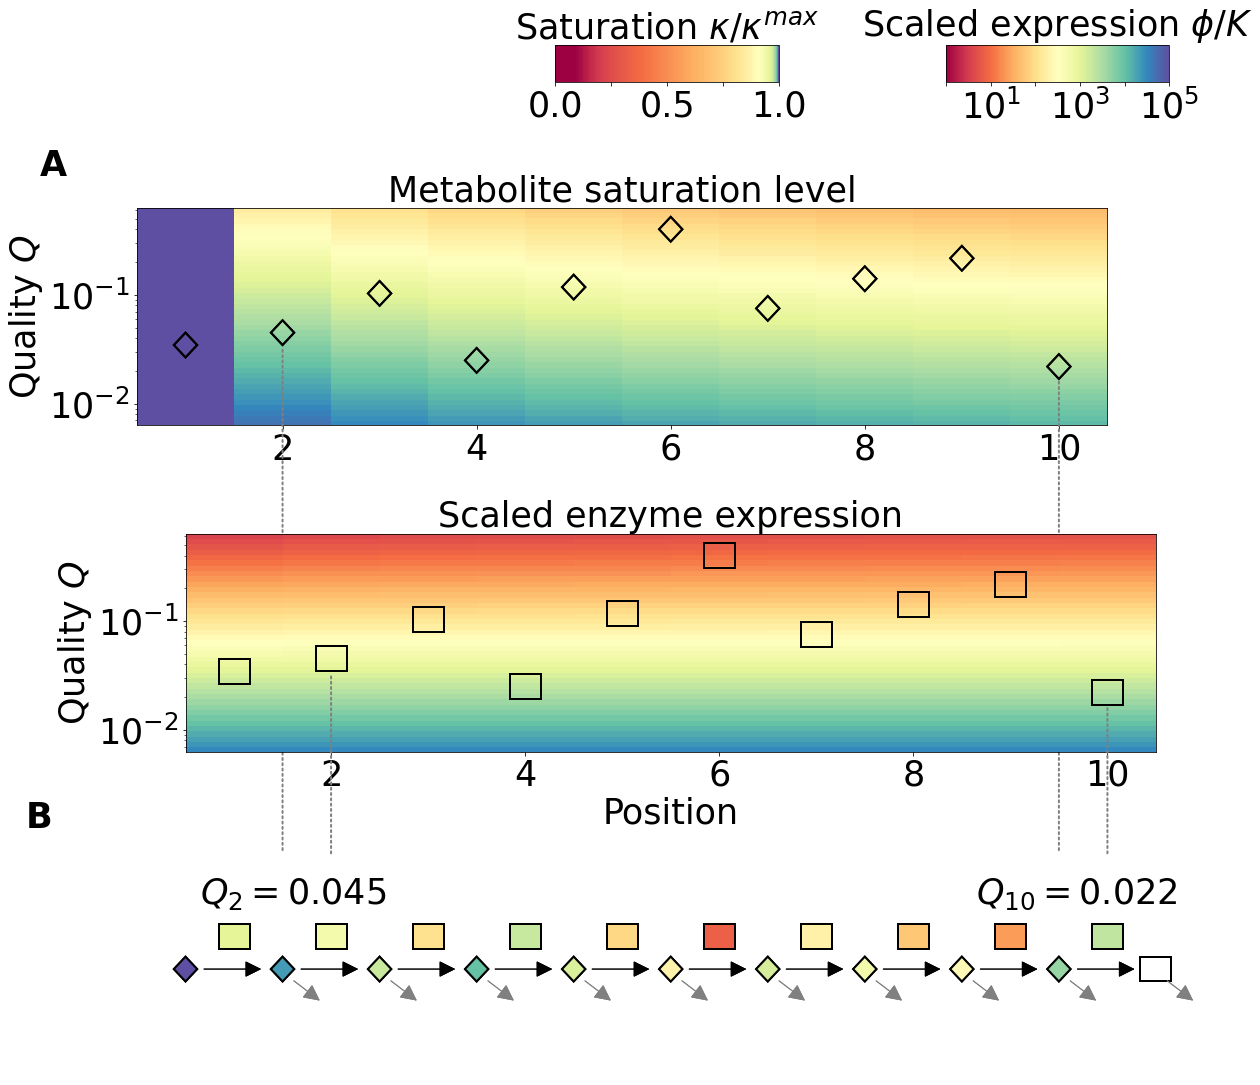

In [847]:
#### Altered panel order for the analytical map
font = {'size'   : 35} #20
plt.rc('font', **font)

fig, axs = plt.subplots(4, 1, figsize = (20, 20))
Nenzymes = 10

gs = gridspec.GridSpec(20, 1)
gs.update(wspace=0, hspace=0)

axs[0] = plt.subplot(gs[4:8, 0])
axs[1] = plt.subplot(gs[10:14, 0])
axs[2] = plt.subplot(gs[16:20, 0])

#cm = plt.cm.get_cmap('RdYlGn')

sigma = "phys_10"
filename = "Ensemble_Rich_sigma_%s.npy"%sigma

fullensemble = np.load(data_folder+filename)

fullensemble = fullensemble[~np.isnan(fullensemble[:, 70, 3, -1])]
print(np.shape(fullensemble))


efficiencybins = np.logspace(-1.4, 1.4, 58)*np.sqrt(KMmean*Nenzymes)#8

branch = 0
ilocs = []
ensemble = []
for j in range(np.shape(fullensemble)[0]):
    maxgr = fullensemble[j, 0, 5, 0]
    halfgrs = (fullensemble[j, :, 5, 0].T-maxgr/2.1).T
    halfgrs[halfgrs<0] = np.max(halfgrs)
    tenthgrs = (fullensemble[j, :, 5, 0].T-maxgr/10.1).T
    tenthgrs[tenthgrs<0] = np.max(tenthgrs)
    
    iloc = np.where(halfgrs == np.nanmin(halfgrs))
    iloc10 = np.where(tenthgrs == np.nanmin(tenthgrs))
    ilocs.append(iloc[0][0])
    ensemble.append(np.array([fullensemble[j, 0], fullensemble[j, iloc[0][0]], fullensemble[j, iloc10[0][0]]]))
    #print(np.shape(np.array([ensemble[j, 0], ensemble[j, iloc]])))

ilocs = np.array(ilocs)
ensemble = np.array(ensemble)[:, :, :, None, ::-1]

#print(np.shape(smallensemble))
efficiencies = np.sqrt(fullensemble[:, 0, 0, :].T*fullensemble[:, 0, 1, :].T/fullensemble[:, 0, 5, 0]).T#/np.sqrt(KMmean*Nenzymes)
#efficiencies = (np.sum(fullensemble[:, 0, 0, :]**(-1), 1)/np.sum(np.sqrt(fullensemble[:, 0, 1, :]/fullensemble[:, 0, 0, :]), 1)*np.sqrt(fullensemble[:, 0, 1, :]*fullensemble[:, 0, 0, :]).T).T
efficiencies = efficiencies[:, None, ::-1]
print(np.shape(ensemble))
print(np.shape(efficiencies))


findGood = np.copy(efficiencies)
findGood[fullensemble[:, 0, 5, :][:, None, :]>5] = np.nan
findGood[findGood<0.3*np.sqrt(KMmean*Nenzymes)] = np.nan
findGood[findGood>2/0.15*np.sqrt(KMmean*Nenzymes)] = np.nan
findGood2 = np.copy(efficiencies[:, 0, 0])
findGood2[np.any(np.isnan(findGood[:, 0, :]), axis = 1)] = np.nan
isample = np.random.choice(np.where(~np.isnan(findGood2))[0])
print(efficiencies[isample, 0, :])

colormeshrho = np.zeros((Nenzymes, np.shape(efficiencybins)[0]-1))
colormeshphi = np.zeros((Nenzymes, np.shape(efficiencybins)[0]-1))

meshx, meshy = np.meshgrid(np.arange(Nenzymes), np.sqrt(efficiencybins[1:]*efficiencybins[:-1]))
colormeshrho = np.log10(np.sqrt(Nenzymes/meshx*fullensemble[isample, 0, 5, 0])*1/meshy).T
colormeshphi = np.log10(meshx.T/Nenzymes*10**colormeshrho*(1+10**colormeshrho))

colormeshrho[0, :] = 1e3
colormeshphi[0, :] = np.log10(fullensemble[isample, 0, 5, 0]/np.sqrt(efficiencybins[1:]*efficiencybins[:-1])**2)
#print(colormeshphi[:2, :])
    
heatmap = axs[0].pcolormesh(np.arange(Nenzymes)+1, np.sqrt(efficiencybins[1:]*efficiencybins[:-1])*0.9, 1/(1+10**(-colormeshrho.T)), cmap = cm3, vmin = 0, vmax = 1)
axs[0].pcolormesh(np.arange(Nenzymes)+1, np.sqrt(efficiencybins[1:]*efficiencybins[:-1])*0.9, colormeshrho.T, cmap = cm, vmin = -1, vmax = 3)
heatmap2 = axs[1].pcolormesh(np.arange(Nenzymes)+1, np.sqrt(efficiencybins[1:]*efficiencybins[:-1])*0.9, colormeshphi.T, cmap = cm, vmin = 0, vmax = 5)

axs[0].set_title(r'Metabolite saturation level')
axs[1].set_title(r'Scaled enzyme expression')
axs[0].set_yscale("log")
axs[1].set_yscale("log")
axs[2].set_yscale("log")
axs[3].set_yscale("log")
axs[0].set_xlim(0.5, Nenzymes+0.5)
axs[1].set_xlim(0.5, Nenzymes+0.5)
axs[2].set_xlim(0.5, Nenzymes+2)
axs[3].set_xlim(0.5, Nenzymes+2)
axs[0].set_ylim(0.2*np.sqrt(KMmean*Nenzymes), 20*np.sqrt(KMmean*Nenzymes))
axs[1].set_ylim(0.2*np.sqrt(KMmean*Nenzymes), 20*np.sqrt(KMmean*Nenzymes))
axs[2].set_ylim(0.1, 10)
axs[3].set_ylim(0.1, 10)
axs[0].set_ylabel(r"Quality $Q$")
axs[1].set_ylabel(r"Quality $Q$")
axs[1].set_xlabel("Position")

efficiencybins = np.logspace(-1.4, 1.4, 8)

#isample = 5

for i in [0, 2]:
    for j in range(Nenzymes):
        #axs[2].add_patch(plt.Polygon([[j+.83, efficiencybins[height[j]]*1.1], [j+.83, efficiencybins[height[j]+1]*.9], [j+1.17, efficiencybins[height[j]+1]*.9], [j+1.17, efficiencybins[height[j]]*1.1]],facecolor=(0, 0, 0, 0), edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2))
        axs[0].add_patch(plt.Polygon([[j+.88, efficiencies[isample, 0, j]], [j+1, efficiencies[isample, 0, j]*1.3], [j+1.12, efficiencies[isample, 0, j]], [j+1, efficiencies[isample, 0, j]/1.3]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2, facecolor=(0,0,0,0)))#facecolor=cm(np.log10(ensemble[isample, 0, 3, 0, j]/ensemble[isample, 0, 1, 0, j])/3)))
        axs[1].add_patch(plt.Polygon([[j+.84, efficiencies[isample, 0, j]*1.3], [j+.84, efficiencies[isample, 0, j]/1.3], [j+1.16, efficiencies[isample, 0, j]/1.3], [j+1.16, efficiencies[isample, 0, j]*1.3]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2, facecolor=(0,0,0,0)))#facecolor=cm(np.log10(ensemble[isample, 0, 4, 0, j]/ensemble[isample, 0, 1, 0, j])/5)))
        axs[2].add_patch(plt.Polygon([[j+.88, 1], [j+1, 1.3], [j+1.12, 1], [j+1, 1/1.3]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2, facecolor=cm((np.log10(ensemble[isample, 0, 3, 0, j]/ensemble[isample, 0, 1, 0, j])-vmin)/(vmax-vmin))))
        axs[2].add_patch(plt.Polygon([[j+.84+.5, 2*1.3], [j+.84+.5, 2/1.3], [j+1.16+.5, 2/1.3], [j+1.16+.5, 2*1.3]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2, facecolor=cm(np.log10(ensemble[isample, 0, 4, 0, j]/ensemble[isample, 0, 1, 0, j])/5)))
        axs[2].annotate("", xy = (j+1.8, 1), xytext = (j+1.17, 1), arrowprops=dict(arrowstyle="-|>", color='k'))
        axs[2].annotate("", xy = (j+2.4, .5), xytext = (j+2.1, 0.8), arrowprops=dict(arrowstyle="-|>", color='grey'))

        
#axs[2].annotate("", xy = (Nenzymes+1.8, 1), xytext = (Nenzymes+1.17, 1), arrowprops=dict(arrowstyle="-|>", color='k'))

axs[2].add_patch(plt.Polygon([[j+.84+1, 1*1.3], [j+.84+1, 1/1.3], [j+1.16+1, 1/1.3], [j+1.16+1, 1*1.3]],facecolor=(0, 0, 0, 0), edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2))
fig.tight_layout()


axins = inset_axes(axs[2], width="20%", height="17%", loc=1, bbox_to_anchor=(-0.425, 3.75, 1, 1), bbox_transform=axs[2].transAxes, borderpad=0)
cb = fig.colorbar(heatmap, orientation='horizontal', cax=axins)#, label = r"Low          High")
#axins.set_xticks([0, 1, 2, 3, 4])
axins.set_xticks([0, 0.25, 0.50, 0.75, 1])
axins.set_xticklabels([r"0.0", "", r"0.5", "", r"1.0"])
#axins.set_xticklabels([r"$10^0$", "", r"$10^2$", "", r"$10^4$"])
#axins.set_title(r"Saturation $\rho/K$")
axins.set_title(r"Saturation $\kappa/\kappa^{max}$")

axins2 = inset_axes(axs[2], width="20%", height="17%", loc=1, bbox_to_anchor=(-0.075, 3.75, 1, 1), bbox_transform=axs[2].transAxes, borderpad=0)
cb = fig.colorbar(heatmap2, orientation='horizontal', cax=axins2)#, label = r"Low          High")
axins2.set_xticks([0, 1, 2, 3, 4, 5])
axins2.set_xticklabels(["", r"$10^1$", "", r"$10^3$", "", r"$10^5$"])
axins2.set_title(r"Scaled expression $\phi/K$")

#fig.tight_layout()

for i in [2, 10]:
    axs[2].annotate(r"$Q_{%d} =$%.3f"%(i, efficiencies[isample, 0, i-1]), xy = (i-.85, 4), xytext = (i-.85, 4), arrowprops=dict(arrowstyle="-", color='w'))
    axs[0].annotate(r"", xy = (i, efficiencies[isample, 0, i-1]/1.3), xytext = (i, 15/2e7), arrowprops=dict(arrowstyle="-", linestyle = ":", color='grey', linewidth = 2))
    axs[1].annotate(r"", xy = (i, efficiencies[isample, 0, i-1]/1.3), xytext = (i, 14000/2e7), arrowprops=dict(arrowstyle="-", linestyle = ":", color='grey', linewidth = 2))

axs[3].axis("off")
axs[2].axis("off")

divider = make_axes_locatable(axs[2])
#cax = divider.append_axes("right", size="5%", pad=0).axis('off')
        
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="15%", pad=0).axis('off')

divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="10%", pad=0).axis('off')
cax = divider.append_axes("left", size="5%", pad=0).axis('off')

for n, ax in enumerate([axs[0], axs[2]]):  
    ax.text(-0.1, 1.15, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')

#print(colormeshphi[0, :])
#print(fullensemble[isample, 0, 5, 0])
plt.savefig("/Users/leonseeger/Dropbox/EffluxPumpsLeon/Draft/CommentingVersion/MainText1.pdf", bbox_inches="tight", format = 'pdf')

In [848]:
def filtered(data):
    logdata = np.log(data[:-1])
    if np.max(logdata)-np.min(logdata)<0.5:
        filtereddata = savgol_filter(logdata, 8, 1)
        final = np.copy(data)
        final[:-1] = np.exp(filtereddata)
    else:
        if np.shape(data)[0]>15:
            filtereddata = savgol_filter(logdata, 10, 3)
            if np.any((logdata-filtereddata)>0.02):
                filtereddata[:10] = savgol_filter(logdata[:10], 7, 3)
                filtereddata[10] = logdata[10]
                filtereddata[11:] = savgol_filter(logdata[11:], 7, 3)
            final = np.copy(data)
            final[:-1] = np.exp(filtereddata)
        else:
            filtereddata = savgol_filter(logdata[1:], 7, 3)
            final = np.copy(data)
            final[1:-1] = np.exp(filtereddata)
    return final

(5000, 42)
(5000, 1000, 3, 20)
(5000, 1000, 6, 20)
(5000, 3, 6, 1, 20)
(5000, 1, 20)
1.3268029035967932


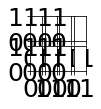

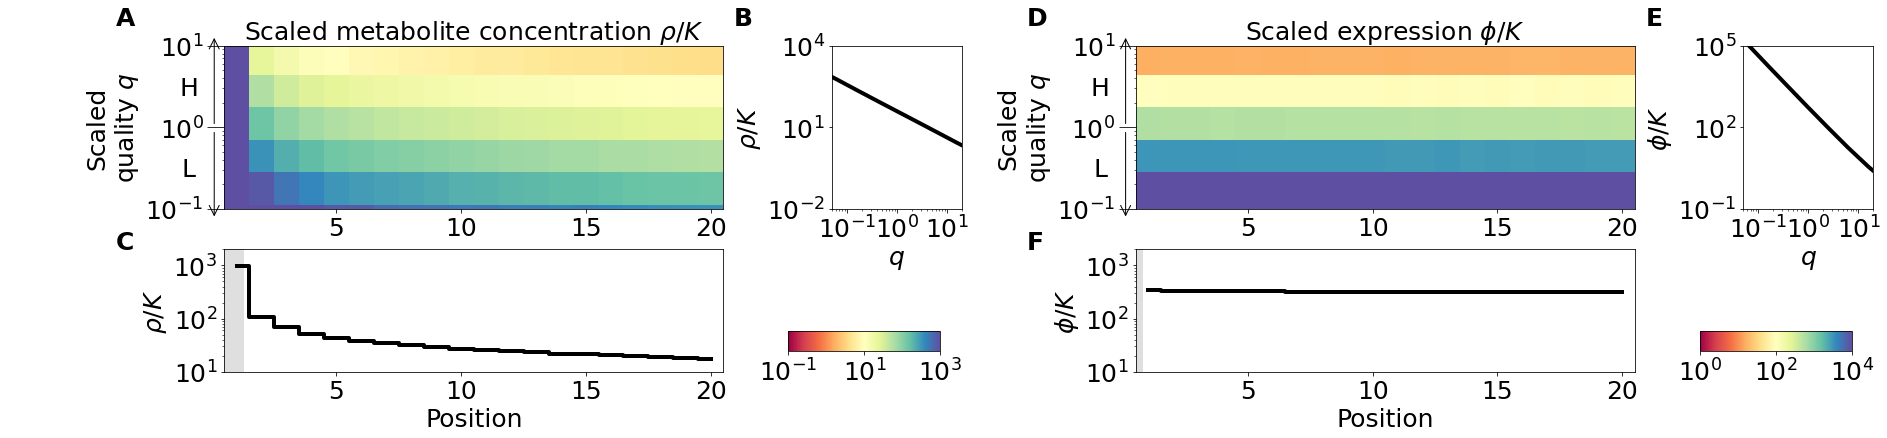

In [894]:
#must stay

fig, axs = plt.subplots(2, 4, figsize = (1, 1))
fig = plt.figure(figsize = (35, 15))
gs = gridspec.GridSpec(40, 90)
gs.update(wspace=0, hspace=0)

axs[0, 0] = plt.subplot(gs[0:8, 10:33])
axs[1, 0] = plt.subplot(gs[10:16, 10:33])
axs[0, 1] = plt.subplot(gs[0:8, 38:44])
axs[1, 1] = plt.subplot(gs[14:15, 36:43])

axs[0, 2] = plt.subplot(gs[0:8, 52:75])
axs[1, 2] = plt.subplot(gs[10:16, 52:75])
axs[0, 3] = plt.subplot(gs[0:8, 80:86])
axs[1, 3] = plt.subplot(gs[14:15, 78:85])

#### Linear Chain
#fig, axs = plt.subplots(2, 2, figsize = (10, 10))
Nenzymes = 20
font = {'size'   : 25} #25#20
plt.rc('font', **font)

filename = "PhysiologicalOptimalBalancedGrowthStates_nutrientLimitation.npy"

fullensemble = np.load(data_folder+filename)
parameters = np.load(data_folder+"physiologicalParameterset.npy")
print(np.shape(parameters))
print(np.shape(fullensemble))

parameterensemble = np.ones(np.shape(fullensemble))
parameterensemble[:, :, 0, :] = np.repeat(parameters[:, None, :Nenzymes], np.shape(fullensemble)[1], axis = 1)
parameterensemble[:, :, 1, :] = np.repeat(parameters[:, None, Nenzymes:2*Nenzymes], np.shape(fullensemble)[1], axis = 1)

fullensemble = np.concatenate((parameterensemble, fullensemble), axis = 2)

fullensemble = fullensemble[~np.isnan(fullensemble[:, 70, 3, -1])]

print(np.shape(fullensemble))

meancolors = ["k", "dimgrey"]

KMmean = np.exp(np.mean(np.log(fullensemble[:, 0, 1, :])))
efficiencybins = np.logspace(-2.2 , 2.2, 12)
efficiencybins2 = np.copy(efficiencybins)
ilocs = []
ensemble = []

for j in range(np.shape(fullensemble)[0]):
    maxgr = fullensemble[j, 0, 5, 0]
    halfgrs = (fullensemble[j, :, 5, 0].T-maxgr/2.1).T
    halfgrs[halfgrs<0] = np.max(halfgrs)
    tenthgrs = (fullensemble[j, :, 5, 0].T-maxgr/10.1).T
    tenthgrs[tenthgrs<0] = np.max(tenthgrs)
    
    iloc = np.where(halfgrs == np.nanmin(halfgrs))
    iloc10 = np.where(tenthgrs == np.nanmin(tenthgrs))
    ilocs.append(iloc[0][0])
    ensemble.append(np.array([fullensemble[j, 0], fullensemble[j, iloc[0][0]], fullensemble[j, iloc10[0][0]]]))
    #print(np.shape(np.array([ensemble[j, 0], ensemble[j, iloc]])))

ilocs = np.array(ilocs)
ensemble = np.array(ensemble)[:, :, :, None, :]

#print(np.shape(smallensemble))
efficiencies = np.sqrt(fullensemble[:, 0, 0, :].T*fullensemble[:, 0, 1, :].T/fullensemble[:, 0, 5, 0]).T/np.sqrt(KMmean*Nenzymes)
#efficiencies = (np.sum(fullensemble[:, 0, 0, :]**(-1), 1)/np.sum(np.sqrt(fullensemble[:, 0, 1, :]/fullensemble[:, 0, 0, :]), 1)*np.sqrt(fullensemble[:, 0, 1, :]*fullensemble[:, 0, 0, :]).T).T
efficiencies = efficiencies[:, None, :]
print(np.shape(ensemble))
print(np.shape(efficiencies))

branch = 0
colormeshrho = np.zeros((Nenzymes, np.shape(efficiencybins)[0]-1))
colormeshphi = np.zeros((Nenzymes, np.shape(efficiencybins)[0]-1))
for i in range(np.shape(efficiencybins)[0]-1):
    mask = (efficiencies[:, branch, :]>efficiencybins[i])*(efficiencies[:, branch, :]<=efficiencybins[i+1])
    fullmask = mask[:, None, None, :]*np.ones((np.shape(ensemble)[1], np.shape(ensemble)[2]))[None, :, :, None]
    maskeddata = np.where(fullmask, ensemble[:, :, :, branch, :], np.nan)
    logsaturation = np.log10(maskeddata[:, 0, 3, :]/maskeddata[:, 0, 1, :])
    logexpression = np.log10(maskeddata[:, 0, 4, :]/maskeddata[:, 0, 1, :])
    colormeshrho[:, i] = np.nanmean(logsaturation, 0)
    colormeshphi[:, i] = np.nanmean(logexpression, 0)
    
heatmap = axs[0, 0].pcolormesh(np.arange(Nenzymes)[::-1]+1, np.sqrt(efficiencybins[1:]*efficiencybins[:-1]), colormeshrho.T, cmap = cm, vmin = -1, vmax = 3)
heatmap2 = axs[0, 2].pcolormesh(np.arange(Nenzymes)[::-1]+1, np.sqrt(efficiencybins[1:]*efficiencybins[:-1]), colormeshphi.T, cmap = cm, vmin = 0, vmax = 4)
axs[0, 0].set_title(r'Scaled metabolite concentration $\rho/K$')
axs[0, 2].set_title(r'Scaled expression $\phi/K$')

axcb = axs[1, 1]
cb = fig.colorbar(heatmap, orientation='horizontal', cax=axcb)#, label = r"$\rho/K$")
axcb.set_xticks([-1, 1, 3])
axcb.set_xticklabels([r"$10^{-1}$", r"$10^{1}$", r"$10^{3}$"])

axcb2 = axs[1, 3]
fig.colorbar(heatmap2, orientation='horizontal', cax=axcb2)#, label = r"$\phi/K$")
axcb2.set_xticks([0, 2, 4])
axcb2.set_xticklabels([r"$10^{0}$", r"$10^{2}$", r"$10^{4}$"])

shift = 0
colors = ["k", "r"]
effs = ["L", "H"]
effcolors = ["b", "orange"]

for gr in range(1):
    meanN = np.nanmean(np.log10(ensemble[:, :, 4, 0, :]/ensemble[:, :, 1, 0, :]))
    stdN = np.nanstd(np.log10(ensemble[:, :, 4, 0, :]/ensemble[:, :, 1, 0, :]))
    
    efficiencybins = np.logspace(-5, 5, 2)
    meanNs = []
    stdNs = []
    meanNs2 = []
    stdNs2 = []
    piefractions = []
    for i in range(np.shape(efficiencybins)[0]-1):
        #if i%6==3:
        mask = (efficiencies[:, branch, :]>efficiencybins[i])*(efficiencies[:, branch, :]<=efficiencybins[i+1])
        fullmask = mask[:, None, None, :]*np.ones((np.shape(ensemble)[1], np.shape(ensemble)[2]))[None, :, :, None]
        maskeddata = np.where(fullmask, ensemble[:, :, :, branch, :], np.nan)
        logsaturation = np.log10(maskeddata[:, gr, 3, :]/maskeddata[:, 0, 1, :])
        logexpression = np.log10(maskeddata[:, gr, 4, :]/maskeddata[:, 0, 1, :])
        meanNs.append(10**np.nanmean(logsaturation, 0))
        stdNs.append(10**np.nanstd(logsaturation, 0))
        meanNs2.append(10**(np.nanmean(logexpression, 0)))
        stdNs2.append(10**(np.nanstd(logexpression, 0)))
        
        axs[1, 0].step(np.arange(20)[::-1]+1+shift, filtered(meanNs[-1]), meancolors[i], where = "mid", linewidth = 4)
        axs[1, 2].step(np.arange(20)[::-1]+1+shift, filtered(meanNs2[-1]), meancolors[i], where = "mid", linewidth = 4)
        #axs[1, 0].step(np.arange(20)[::-1]+1+shift, meanNs[-1], meancolors[i], where = "mid", linewidth = 4)
        #axs[1, 2].step(np.arange(20)[::-1]+1+shift, meanNs2[-1], meancolors[i], where = "mid", linewidth = 4)
        
        #axs[1, 0].text(20.8, meanNs[-1][0]/1.2, effs[i], color = colors[gr])
        #axs[1, 2].text(20.8, meanNs2[-1][0]/1.2, effs[i], color = colors[gr])
        piefractions.append(np.nanmean(np.nansum(maskeddata[:, gr, 4, :], -1)))
        

    axs[0, 1].plot(np.sqrt(efficiencybins2[1:]*efficiencybins2[:-1]), 10**np.mean(colormeshrho[:-1, :], 0), meancolors[i], linewidth = 4)
    axs[0, 3].plot(np.sqrt(efficiencybins2[1:]*efficiencybins2[:-1]), 10**np.mean(colormeshphi[:-1, :], 0), meancolors[i], linewidth = 4)

    x5, y5, z5 = np.arange(Nenzymes)[::-1]+1, np.sqrt(efficiencybins2[1:]*efficiencybins2[:-1]), colormeshrho.T
    x6, y6, z6 = np.arange(Nenzymes)[::-1]+1, np.sqrt(efficiencybins2[1:]*efficiencybins2[:-1]), colormeshphi.T
    
for ax in axs.flatten():
    ax.set_yscale("log")

axs[0, 1].set_xlim(0.05, 20) 
axs[0, 3].set_xlim(0.05, 20)
axs[0, 1].set_xscale("log")
axs[0, 3].set_xscale("log")

for ax in [axs[0, 0], axs[1, 0], axs[0, 2], axs[1, 2]]:
    ax.set_xlim(0.5, 20.5)
    ax.set_xticks([5, 10, 15, 20])

axs[0, 0].set_ylim(0.1, 10)
axs[0, 2].set_ylim(0.1, 10)

axs[1, 0].set_ylim(1e1, 2e3)
axs[1, 2].set_ylim(1e1, 2e3) 
axs[0, 1].set_ylim(1e-2, 1e4)
axs[0, 3].set_ylim(1e-1, 1e5) 

axs[1, 0].set_xlabel("Position")
axs[1, 2].set_xlabel("Position")


axs[0, 0].yaxis.set_tick_params(which='major', length=17)
axs[0, 0].annotate('', xy=(-0.02, -.06), xycoords='axes fraction', xytext=(-0.02, .48), arrowprops=dict(arrowstyle="->", color='k'))
axs[0, 0].annotate('', xy=(-0.02, 1.06), xycoords='axes fraction', xytext=(-0.02, .51), arrowprops=dict(arrowstyle="->", color='k'))
axs[0, 0].text(-1.3, 2.5, "H")
axs[0, 0].text(-1.2, 1/4, "L")
axs[0, 2].yaxis.set_tick_params(which='major', length=17)
axs[0, 2].annotate('', xy=(-0.02, -.06), xycoords='axes fraction', xytext=(-0.02, .48), arrowprops=dict(arrowstyle="->", color='k'))
axs[0, 2].annotate('', xy=(-0.02, 1.06), xycoords='axes fraction', xytext=(-0.02, .51), arrowprops=dict(arrowstyle="->", color='k'))
axs[0, 2].text(-1.3, 2.5, "H")
axs[0, 2].text(-1.2, 1/4, "L")

axs[1, 0].add_patch(plt.Polygon([[0.5, 1e-3], [0.5, 1e5], [1.3, 1e5], [1.3, 1e-3]],facecolor='silver', clip_on=True, linewidth = 0, alpha = 0.5))
axs[1, 2].add_patch(plt.Polygon([[0.5, 1e-1], [0.5, 1.5e4], [.8, 1.5e4], [.8, 1e-1]],facecolor='silver', clip_on=True, linewidth = 0, alpha = 0.5))
 
axs[0, 0].set_ylabel("Scaled\nquality $q$")
axs[0, 2].set_ylabel("Scaled\nquality $q$")
axs[0, 1].set_xlabel("$q$")
axs[0, 3].set_xlabel("$q$")
axs[1, 0].set_ylabel(r"$\rho/K$")
axs[1, 2].set_ylabel(r"$\phi/K$")
axs[0, 1].set_ylabel(r"$\rho/K$")
axs[0, 3].set_ylabel(r"$\phi/K$")


axlabel = plt.subplot(gs[15, 0])
axlabel.axis("off")
axlabel.text(5, 17, "A", weight = 'bold')
axlabel.text(33.5, 17, "B", weight = 'bold')
axlabel.text(5, 6, "C", weight = 'bold')
axlabel.text(47, 17, "D", weight = 'bold')
axlabel.text(75.5, 17, "E", weight = 'bold')
axlabel.text(47, 6, "F", weight = 'bold')

print(np.exp(np.mean(np.log(efficiencies))))

plt.savefig("/Users/leonseeger/Dropbox/EffluxPumpsLeon/Draft/CommentingVersion/MainText2.pdf", bbox_inches="tight", format = 'pdf')

(5000, 42)
(5000, 1000, 3, 20)
(5000, 1000, 6, 20)
(5000, 19)


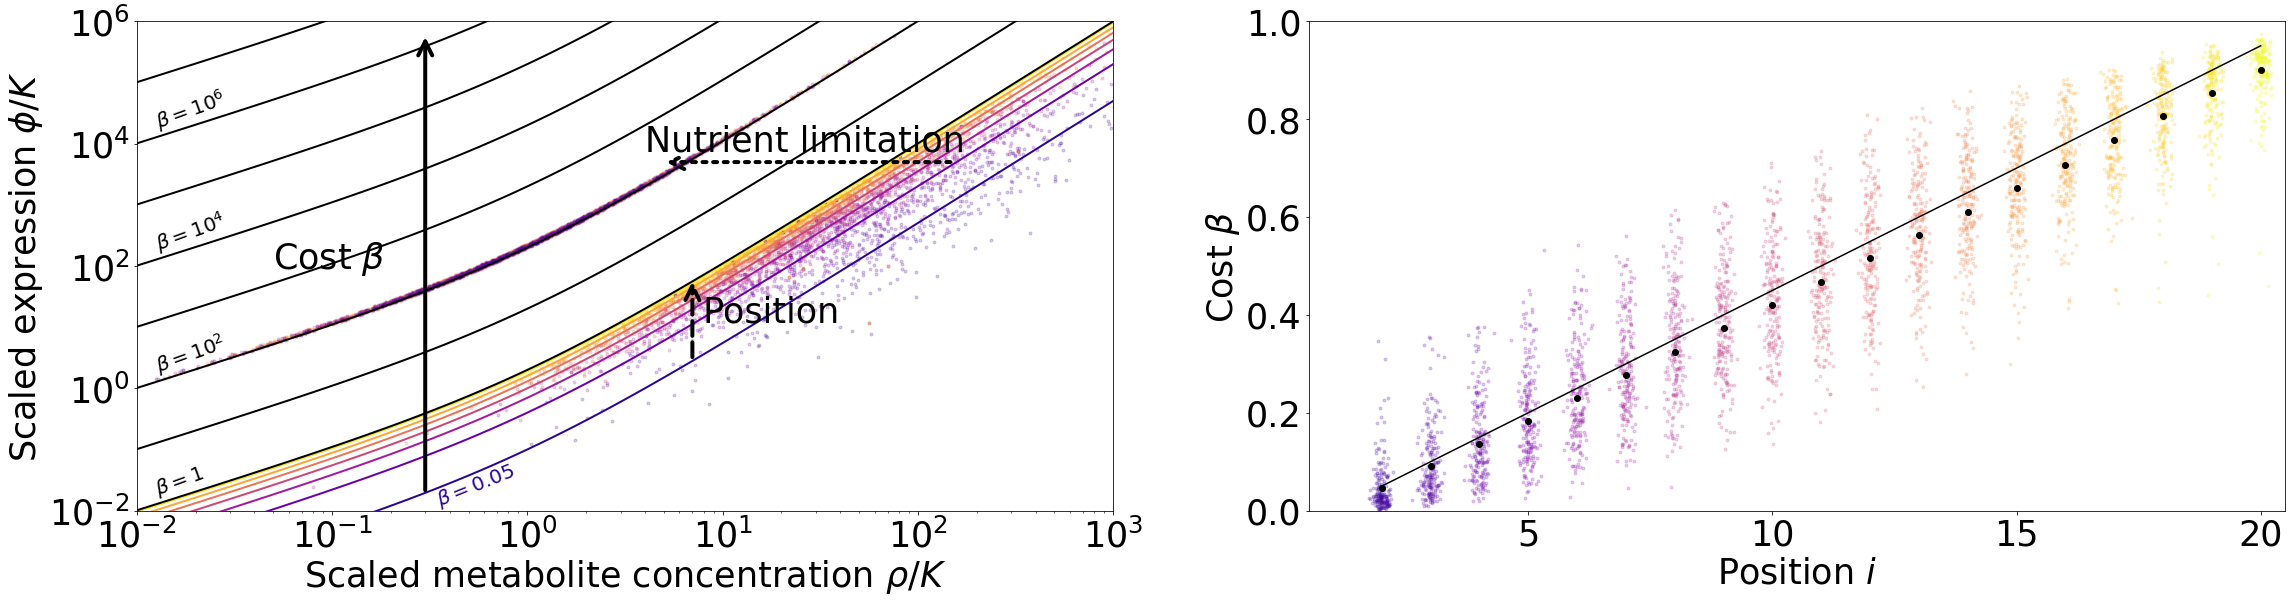

In [895]:
fig, axs = plt.subplots(1, 3, figsize = (42, 12))
font = {'size'   : 35} #20
plt.rc('font', **font)
cmplasma = plt.cm.get_cmap('plasma')

gs = gridspec.GridSpec(4, 12)
gs.update(wspace=0, hspace=0)

axs[0] = plt.subplot(gs[0:3, 1:6])
axs[1] = plt.subplot(gs[0:3, 7:12])
#axs[2] = plt.subplot(gs[0:3, 9:12])

ax0 = axs[0]

filename = "PhysiologicalOptimalBalancedGrowthStates_nutrientLimitation.npy"

fullensemble = np.load(data_folder+filename)
parameters = np.load(data_folder+"physiologicalParameterset.npy")
print(np.shape(parameters))
print(np.shape(fullensemble))

parameterensemble = np.ones(np.shape(fullensemble))
parameterensemble[:, :, 0, :] = np.repeat(parameters[:, None, :Nenzymes], np.shape(fullensemble)[1], axis = 1)
parameterensemble[:, :, 1, :] = np.repeat(parameters[:, None, Nenzymes:2*Nenzymes], np.shape(fullensemble)[1], axis = 1)

fullensemble = np.concatenate((parameterensemble, fullensemble), axis = 2)

fullensemble = fullensemble[~np.isnan(fullensemble[:, 70, 3, -1])]

print(np.shape(fullensemble))

meancolors = ["k", "dimgrey"]

KMmean = np.exp(np.mean(np.log(fullensemble[:, 0, 1, :])))

efficiencybins = np.logspace(-2.2 , 2.2, 12)#np.logspace(-1, 1, 6)
efficiencybins2 = np.copy(efficiencybins)
ilocs = []
ensemble = []

for j in range(np.shape(fullensemble)[0]):
    maxgr = fullensemble[j, 0, 5, 0]
    halfgrs = (fullensemble[j, :, 4, 0]/fullensemble[j, :, 1, 0]/(fullensemble[j, :, 3, 0]/fullensemble[j, :, 1, 0])/(1+fullensemble[j, :, 3, 0]/fullensemble[j, :, 1, 0]).T-100).T
    halfgrs[halfgrs<0] = np.max(halfgrs)
    tenthgrs = (fullensemble[j, :, 5, 0].T-maxgr/10.1).T
    tenthgrs[tenthgrs<0] = np.max(tenthgrs)
    
    iloc = np.where(halfgrs == np.nanmin(halfgrs))
    iloc10 = np.where(tenthgrs == np.nanmin(tenthgrs))
    ilocs.append(iloc[0][0])
    ensemble.append(np.array([fullensemble[j, 0], fullensemble[j, iloc[0][0]], fullensemble[j, iloc10[0][0]]]))
    #print(np.shape(np.array([ensemble[j, 0], ensemble[j, iloc]])))

ilocs = np.array(ilocs)
ensemble = np.array(ensemble)[:, :, :, None, :]

#for q in range(np.shape(ensemble)[0])[::50]: #display only a subset of points to ensure individual visibility
#    ax0.scatter(ensemble[q, 0, 3, 0, 10:-1]/ensemble[q, 0, 1, 0, 10:-1], ensemble[q, 0, 4, 0, 10:-1]/ensemble[q, 0, 1, 0, 10:-1], marker = ".", color = "g", alpha = 0.2)
#    ax0.scatter(ensemble[q, 0, 3, 0, :10]/ensemble[q, 0, 1, 0, :10], ensemble[q, 0, 4, 0, :10]/ensemble[q, 0, 1, 0, :10], marker = ".", color = "k", alpha = 0.2)
#    #ax0.scatter(ensemble[q, 0, 3, 0, :]/ensemble[q, 0, 1, 0, :], ensemble[q, 0, 4, 0, :]/ensemble[q, 0, 1, 0, :], marker = ".", color = "k", alpha = 0.05)
#ax0.scatter(ensemble[q, 0, 3, 0, 10:-1]/ensemble[q, 0, 1, 0, 10:-1], ensemble[q, 0, 4, 0, 10:-1]/ensemble[q, 0, 1, 0, 10:-1], marker = ".", color = "g", alpha = 0.4, label = "Catabolism")   
#ax0.scatter(ensemble[q, 0, 3, 0, :10]/ensemble[q, 0, 1, 0, :10], ensemble[q, 0, 4, 0, :10]/ensemble[q, 0, 1, 0, :10], marker = ".", color = "k", alpha = 0.4, label = "Anabolism")   


for i in range(Nenzymes-1):
    for q in range(np.shape(ensemble)[0])[:200]: #display only a subset of points to ensure individual visibility
        ax0.scatter(ensemble[q, 0, 3, 0, i]/ensemble[q, 0, 1, 0, i], ensemble[q, 0, 4, 0, i]/ensemble[q, 0, 1, 0, i], marker = ".", color = cmplasma((Nenzymes-i)/Nenzymes), alpha = 0.2)  
        ax0.scatter(ensemble[q, 1, 3, 0, i]/ensemble[q, 1, 1, 0, i], ensemble[q, 1, 4, 0, i]/ensemble[q, 1, 1, 0, i], marker = ".", color = cmplasma((Nenzymes-i)/Nenzymes), alpha = 0.2)  
        #ax0.scatter(fullensemble[q, 81, 3, i]/fullensemble[q, 81, 1, i], fullensemble[q, 81, 4, i]/fullensemble[q, 81, 1, i], marker = ".", color = cmplasma((Nenzymes-i)/Nenzymes), alpha = 0.2)  
        #print("")
ax0.scatter(ensemble[q, 0, 3, 0, 10:-1]/ensemble[q, 0, 1, 0, 10:-1], ensemble[q, 0, 4, 0, 10:-1]/ensemble[q, 0, 1, 0, 10:-1], marker = ".", color = cmplasma(15/20), alpha = 0.4, label = r"Catabolism, $i<\ell/2$")   
ax0.scatter(ensemble[q, 0, 3, 0, :10]/ensemble[q, 0, 1, 0, :10], ensemble[q, 0, 4, 0, :10]/ensemble[q, 0, 1, 0, :10], marker = ".", color = cmplasma(5/20), alpha = 0.4, label = r"Anabolism, $i>\ell/2$")   

#lgnd = ax0.legend(handletextpad=-0.2, loc = "upper left")
#lgnd.legendHandles[0]._sizes = [100]
#lgnd.legendHandles[1]._sizes = [100]
ax0.set_xlim(1e-2, 1e3)
ax0.set_ylim(1e-2, 1e6)
ax0.set_ylabel(r"Scaled expression $\phi/K$")
ax0.set_xlabel(r"Scaled metabolite concentration $\rho/K$")
ax0.set_yscale("log")
ax0.set_xscale("log")
#ax0.plot(np.logspace(-2, 4, 100), np.logspace(-2, 4, 100)*(1+np.logspace(-2, 4, 100)), "k-", linewidth = 2)
#ax0.plot(np.logspace(-2, 4, 100), 0.1*np.logspace(-2, 4, 100)*(1+np.logspace(-2, 4, 100)), "--", color = cmplasma(5/20), linewidth = 2)

betas = ensemble[:, 0, 4, 0, :-1]/ensemble[:, 0, 1, 0, :-1]/(ensemble[:, 0, 3, 0, :-1]/ensemble[:, 0, 1, 0, :-1])/(1+ensemble[:, 0, 3, 0, :-1]/ensemble[:, 0, 1, 0, :-1])
print(np.shape(betas))

for i in np.arange(19):
    axs[1].scatter(np.random.normal(Nenzymes-i, 0.1, len(betas[:200, i])), betas[:200, i], marker = ".", color = cmplasma((Nenzymes-i)/Nenzymes), alpha = 0.2)
    #print("")
#axs[1].violinplot(betas, np.arange(19)[::-1]+2, showextrema=False)
axs[1].plot(np.arange(19)[::-1]+2, (np.arange(19)[::-1]+2-1)/20, "k-")
axs[1].plot(np.arange(19)[::-1]+2, np.mean(betas,0), "ko")
axs[1].set_xlabel("Position $i$")
axs[1].set_ylabel(r"Cost $\beta$")
axs[1].set_yscale("linear")
axs[1].set_xlim(0.5, 20.5)
axs[1].set_xticks([5, 10, 15, 20])
axs[1].set_xticklabels([5, 10, 15, 20])
axs[1].set_ylim(0, 1)

for i in [2, 5, 8, 11, 14, 17, 20]:
    axs[0].plot(np.logspace(-2, 4, 100), (i-1)/20*np.logspace(-2, 4, 100)*(1+np.logspace(-2, 4, 100)), color = cmplasma(((i-1))/Nenzymes), linewidth = 2)
   
for beta in np.logspace(0, 7, 8):
    axs[0].plot(np.logspace(-2, 4, 100), beta*np.logspace(-2, 4, 100)*(1+np.logspace(-2, 4, 100)), color = "k", linewidth = 2)
    
#axs[0].set_xlim(1e-2, 1e2)
#axs[0].set_ylim(1e-2, 1e2)
#axs[0].set_ylabel(r"Scaled expression $\phi/K$")
#axs[0].set_xlabel(r"Scaled metabolite concentration $\rho/K$")
#axs[0].set_yscale("log")
#axs[0].set_xscale("log")

#axs[0].annotate('', xy=(7, 60), xytext=(35, 60), arrowprops=dict(arrowstyle="->", color='k', linewidth = 4, linestyle = "--"))
#axs[0].text(5.5, 30, "Position")
#axs[0].annotate('', xy=(.06, .06), xytext=(.7, .06), arrowprops=dict(arrowstyle="->", color='k', linewidth = 4))
#axs[0].text(.07, .03, r"Cost $\beta$")

axs[0].annotate('', xy=(7, 60), xytext=(7, 3), arrowprops=dict(arrowstyle="->", color='k', linewidth = 4, linestyle = "--"))
axs[0].text(7, 12, " Position")
axs[0].annotate('', xy=(.3, 600000), xytext=(.3, .02), arrowprops=dict(arrowstyle="->", color='k', linewidth = 4))
axs[0].text(.05, 90, r"Cost $\beta$")
axs[0].annotate('', xy=(5, 5000), xytext=(150, 5000), arrowprops=dict(arrowstyle="->", color='k', linewidth = 4, linestyle = ":"))
axs[0].text(4, 7500, r"Nutrient limitation")

axs[0].text(0.012, 0.018, r"$\beta = 1$", rotation = 20, color = "k", size = 20)#color=cmplasma(18/20))
#axs[0].text(0.012, 0.18, r"$\beta = 10$", rotation = 20, color = "k", size = 20)#color=cmplasma(18/20))
axs[0].text(0.012, 1.8, r"$\beta = 10^2$", rotation = 20, color = "k", size = 20)#color=cmplasma(18/20))
#axs[0].text(0.012, 18, r"$\beta = 1000$", rotation = 20, color = "k", size = 20)#color=cmplasma(18/20))
axs[0].text(0.012, 180, r"$\beta = 10^4$", rotation = 20, color = "k", size = 20)#color=cmplasma(18/20))
axs[0].text(0.012, 18000, r"$\beta = 10^6$", rotation = 20, color = "k", size = 20)#color=cmplasma(18/20))

axs[0].text(0.33, 0.012, r"$\beta = 0.05$", rotation = 22, size = 20, color=cmplasma(1/20))

plt.savefig("/Users/leonseeger/Dropbox/EffluxPumpsLeon/Draft/CommentingVersion/MainText1c.pdf", bbox_inches="tight", format = 'pdf')

(5000, 42)
(5000, 1000, 3, 20)
(5000, 1000, 6, 20)
(5000, 3, 6, 1, 20)
(5000, 1, 20)
[3.1475596  3.11584849 2.98785201 2.83196947 2.20328718 1.57569244
 0.94427968 0.31475702 0.15737787 0.03147569]
(5000, 3, 6, 3, 10)
[ 8.43119389 11.4477007  12.759859    6.3425433   7.45475155  9.18274733
 11.48731861  6.43606513  6.77604296  3.41984645] [15.84404038 21.20465474 19.92498366 16.89299135 16.50998344 20.09810118
 20.28924868 17.24420649 18.76003376 16.89695529]
(5000, 3, 10)
(5000, 3, 6, 3, 10)
(5000, 3, 10)
[0.1644404256628333, 0.17040501739881878, 0.17810104818827308, 0.17819047514573358, 0.3088630336043413, 0.12136312510965194] 1.1213631251096519
[0.10765069851747278, 0.1446234382747486, 0.2856129110681119, 0.3097333931492448, 0.152379558990422, 0.049141358110189964] 1.04914135811019


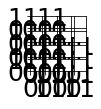

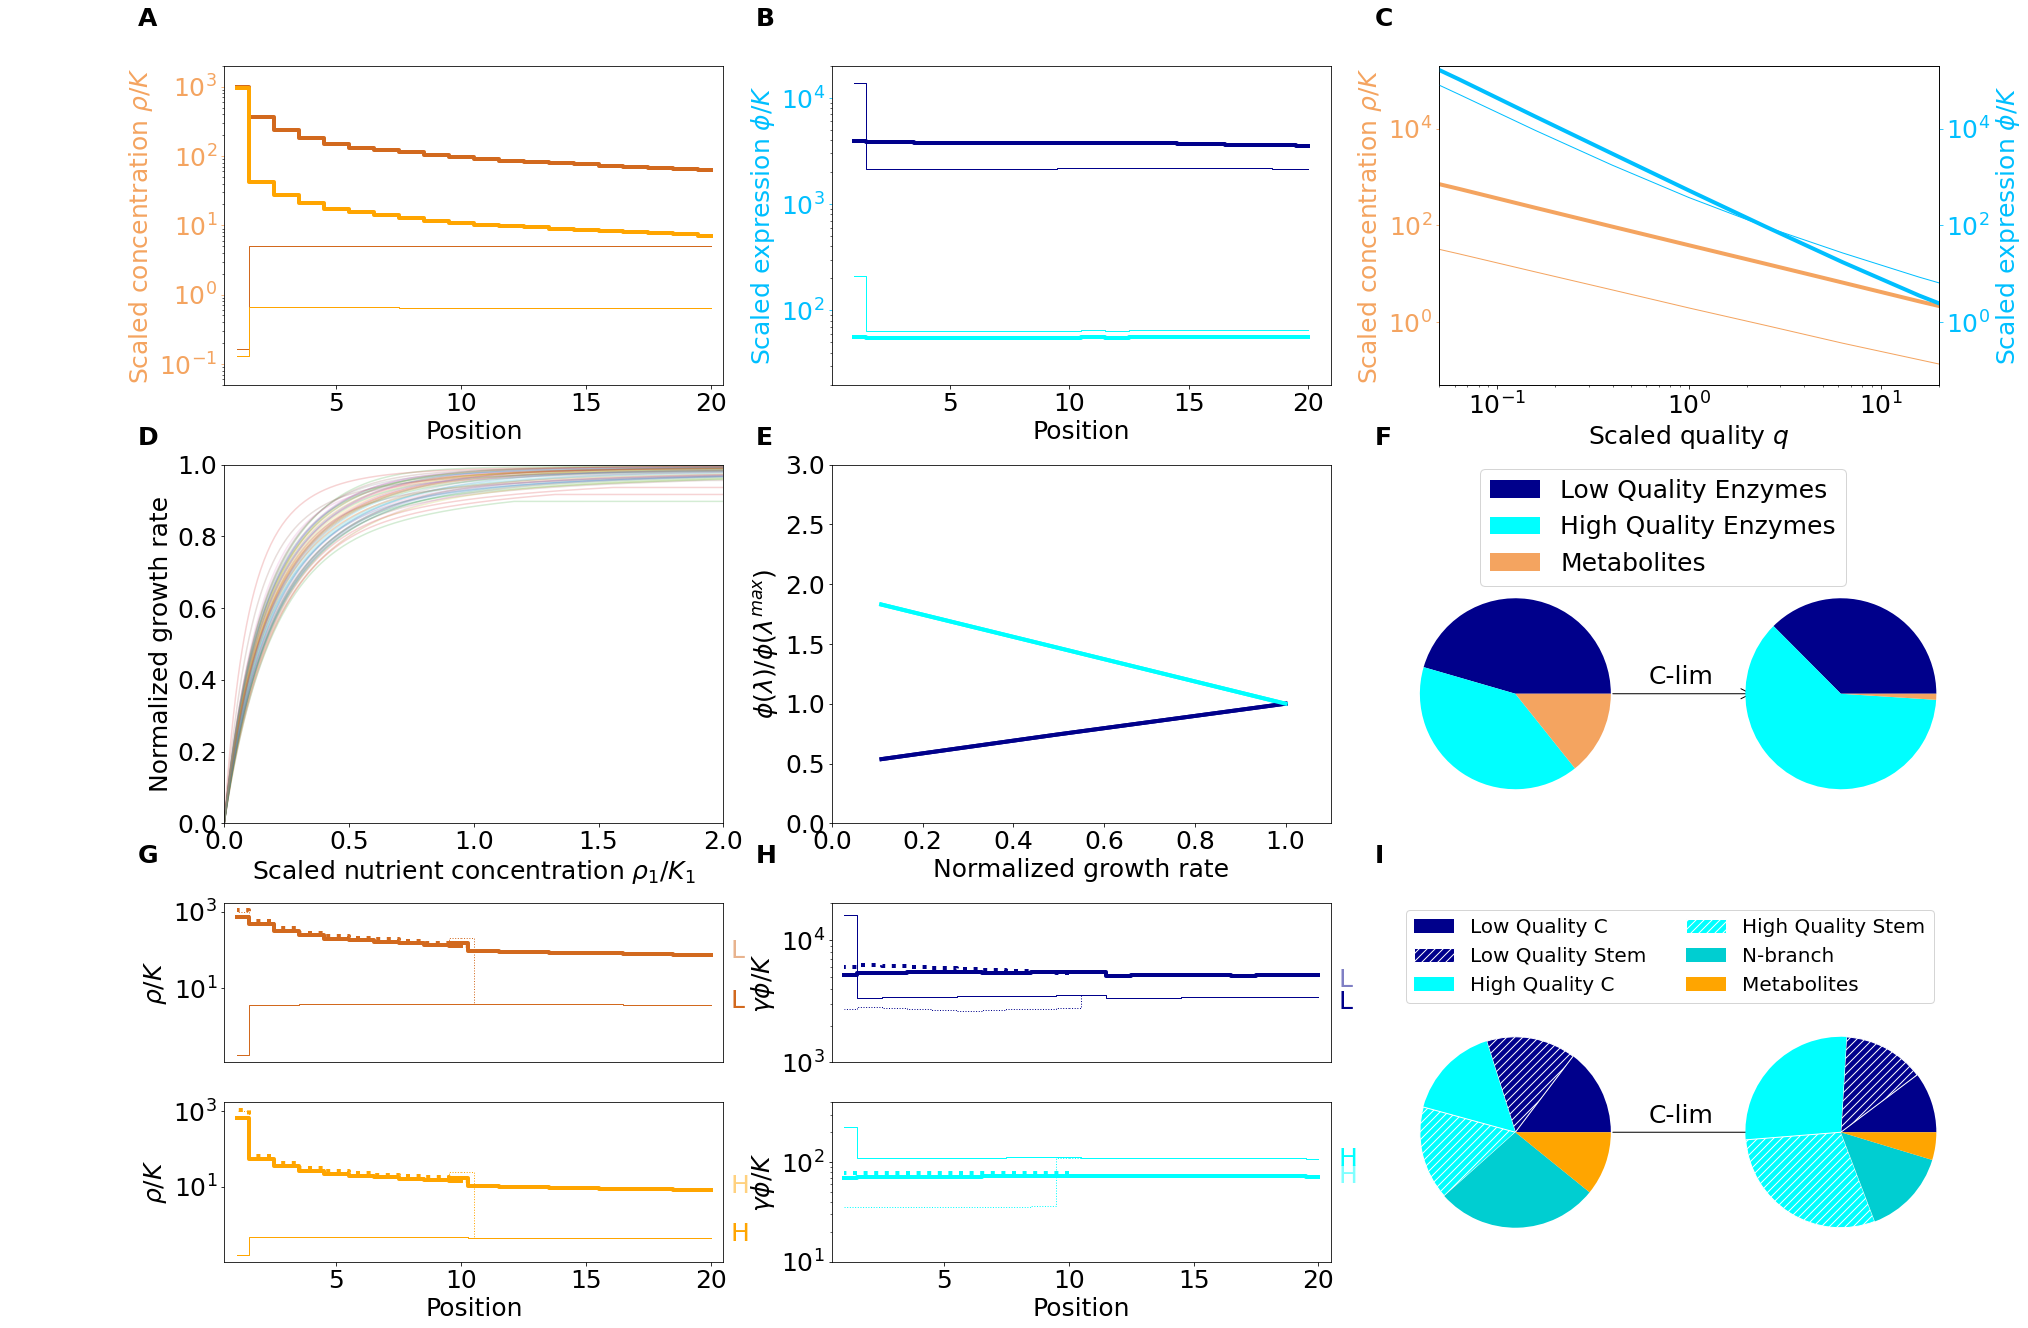

In [897]:
fig, axs = plt.subplots(4, 4, figsize = (1, 1))
fig = plt.figure(figsize = (35, 22))
gs = gridspec.GridSpec(60, 90)
gs.update(wspace=0, hspace=0)

axs[0, 0] = plt.subplot(gs[0:16, 10:33])
ax00 = plt.subplot(gs[0:16, 38:61])
axs[0, 1] = plt.subplot(gs[0:16, 66:89])
ax01 = axs[0, 1].twinx()

axs[1, 0] = plt.subplot(gs[20:38, 10:33])
axs[1, 1] = plt.subplot(gs[20:38, 38:61])
axs[1, 2] = plt.subplot(gs[25:38, 64:75])
axs[1, 3] = plt.subplot(gs[25:38, 79:90])

axs[2, 0] = plt.subplot(gs[42:50, 10:33])
axs[2, 1] = plt.subplot(gs[42:50, 38:61])
axs[3, 0] = plt.subplot(gs[52:60, 10:33])
axs[3, 1] = plt.subplot(gs[52:60, 38:61])
axs[3, 2] = plt.subplot(gs[47:60, 64:75])
axs[3, 3] = plt.subplot(gs[47:60, 79:90])





#### Linear Chain
#fig, axs = plt.subplots(2, 2, figsize = (10, 10))
Nenzymes = 20
font = {'size'   : 25} #25#20
plt.rc('font', **font)

filename = "PhysiologicalOptimalBalancedGrowthStates_nutrientLimitation.npy"

fullensemble = np.load(data_folder+filename)
parameters = np.load(data_folder+"physiologicalParameterset.npy")
print(np.shape(parameters))
print(np.shape(fullensemble))

parameterensemble = np.ones(np.shape(fullensemble))
parameterensemble[:, :, 0, :] = np.repeat(parameters[:, None, :Nenzymes], np.shape(fullensemble)[1], axis = 1)
parameterensemble[:, :, 1, :] = np.repeat(parameters[:, None, Nenzymes:2*Nenzymes], np.shape(fullensemble)[1], axis = 1)

fullensemble = np.concatenate((parameterensemble, fullensemble), axis = 2)

fullensemble = fullensemble[~np.isnan(fullensemble[:, 70, 3, -1])]

print(np.shape(fullensemble))

meancolors = ["k", "dimgrey"]

KMmean = np.exp(np.mean(np.log(fullensemble[:, 0, 1, :])))

efficiencybins = np.logspace(-2.2 , 2.2, 12)#np.logspace(-1, 1, 6)
efficiencybins2 = np.copy(efficiencybins)
ilocs = []
ensemble = []

for j in range(np.shape(fullensemble)[0]):
    maxgr = fullensemble[j, 0, 5, 0]
    halfgrs = (fullensemble[j, :, 5, 0].T-maxgr/2.1).T
    halfgrs[halfgrs<0] = np.max(halfgrs)
    tenthgrs = (fullensemble[j, :, 5, 0].T-maxgr/10.1).T
    tenthgrs[tenthgrs<0] = np.max(tenthgrs)
    
    iloc = np.where(halfgrs == np.nanmin(halfgrs))
    iloc10 = np.where(tenthgrs == np.nanmin(tenthgrs))
    ilocs.append(iloc[0][0])
    ensemble.append(np.array([fullensemble[j, 0], fullensemble[j, iloc[0][0]], fullensemble[j, iloc10[0][0]]]))
    #print(np.shape(np.array([ensemble[j, 0], ensemble[j, iloc]])))

ilocs = np.array(ilocs)
ensemble = np.array(ensemble)[:, :, :, None, :]

#print(np.shape(smallensemble))
efficiencies = np.sqrt(fullensemble[:, 0, 0, :].T*fullensemble[:, 0, 1, :].T/fullensemble[:, 0, 5, 0]).T/np.sqrt(KMmean*Nenzymes)
#efficiencies = (np.sum(fullensemble[:, 0, 0, :]**(-1), 1)/np.sum(np.sqrt(fullensemble[:, 0, 1, :]/fullensemble[:, 0, 0, :]), 1)*np.sqrt(fullensemble[:, 0, 1, :]*fullensemble[:, 0, 0, :]).T).T
efficiencies = efficiencies[:, None, :]
print(np.shape(ensemble))
print(np.shape(efficiencies))

shift = 0
colors = ["k", "r"]
effs = ["L", "H"]
effcolors = ["b", "orange"]
linewidths = [4, 1]
colorsPhi = np.array([["darkblue", "darkblue"], ["cyan", "cyan"]])
colorsRho = np.array([["chocolate", "chocolate"], ["orange", "orange"]])

for gr in range(2):

    branch = 0
    colormeshrho = np.zeros((Nenzymes, np.shape(efficiencybins)[0]-1))
    colormeshphi = np.zeros((Nenzymes, np.shape(efficiencybins)[0]-1))
    for i in range(np.shape(efficiencybins)[0]-1):
        mask = (efficiencies[:, branch, :]>efficiencybins[i])*(efficiencies[:, branch, :]<=efficiencybins[i+1])
        fullmask = mask[:, None, None, :]*np.ones((np.shape(ensemble)[1], np.shape(ensemble)[2]))[None, :, :, None]
        maskeddata = np.where(fullmask, ensemble[:, :, :, branch, :], np.nan)
        logsaturation = np.log10(maskeddata[:, gr, 3, :]/maskeddata[:, 0, 1, :])
        logexpression = np.log10(maskeddata[:, gr, 4, :]/maskeddata[:, 0, 1, :])
        colormeshrho[:, i] = np.nanmean(logsaturation, 0)
        colormeshphi[:, i] = np.nanmean(logexpression, 0)
    

    meanN = np.nanmean(np.log10(ensemble[:, :, 4, 0, :]/ensemble[:, :, 1, 0, :]))
    stdN = np.nanstd(np.log10(ensemble[:, :, 4, 0, :]/ensemble[:, :, 1, 0, :]))
    
    efficiencybins3 = np.logspace(-5, 5, 3)
    meanNs = []
    stdNs = []
    meanNs2 = []
    stdNs2 = []
    piefractions = []
    for i in range(np.shape(efficiencybins3)[0]-1):
        #if i%6==3:
        mask = (efficiencies[:, branch, :]>efficiencybins3[i])*(efficiencies[:, branch, :]<=efficiencybins3[i+1])
        fullmask = mask[:, None, None, :]*np.ones((np.shape(ensemble)[1], np.shape(ensemble)[2]))[None, :, :, None]
        maskeddata = np.where(fullmask, ensemble[:, :, :, branch, :], np.nan)
        logsaturation = np.log10(maskeddata[:, gr, 3, :]/maskeddata[:, 0, 1, :])
        logexpression = np.log10(maskeddata[:, gr, 4, :]/maskeddata[:, 0, 1, :])
        meanNs.append(10**np.nanmean(logsaturation, 0))
        stdNs.append(10**np.nanstd(logsaturation, 0))
        meanNs2.append(10**(np.nanmean(logexpression, 0)))
        stdNs2.append(10**(np.nanstd(logexpression, 0)))
        
        axs[0, 0].step(np.arange(20)[::-1]+1+shift, filtered(meanNs[-1]), colorsRho[i, gr], where = "mid", linewidth = linewidths[gr])
        ax00.step(np.arange(20)[::-1]+1+shift, filtered(meanNs2[-1]), colorsPhi[i, gr], where = "mid", linewidth = linewidths[gr])
        #axs[1, 0].text(20.8, meanNs[-1][0]/1.2, effs[i], color = colors[gr])
        #axs[1, 2].text(20.8, meanNs2[-1][0]/1.2, effs[i], color = colors[gr])
        piefractions.append(np.nanmean(np.nansum(maskeddata[:, gr, 4, :], -1)))
        
        axs[1, 1].plot(np.nanmean(maskeddata[:, :, 5, 0]/maskeddata[:, 0, 5, 0][:, None], 0), np.nanmean(maskeddata[:, :, 4, :]/maskeddata[:, 0, 4, :][:, None, :], (0, 2)), colorsPhi[i, 0], linewidth = 4)#, meancolors[i])
        

    axs[0, 1].plot(np.sqrt(efficiencybins2[1:]*efficiencybins2[:-1]), 10**np.mean(colormeshrho[:-1, :], 0), color = "sandybrown", linewidth = linewidths[gr])
    ax01.plot(np.sqrt(efficiencybins2[1:]*efficiencybins2[:-1]), 10**np.mean(colormeshphi[:-1, :], 0), color = "deepskyblue", linewidth = linewidths[gr])

    piefractions.append(np.nanmean(np.nansum(ensemble[:, gr, 3, branch, :-1], -1)))
    patches, texts = axs[1, 2+gr].pie(piefractions, colors = [colorsPhi[0, 1], colorsPhi[1, 1], "sandybrown"])#, labels = ["Low Quality", "High Quality"])

axs[0, 0].set_yscale("log")
axs[0, 1].set_yscale("log")
ax00.set_yscale("log")
ax01.set_yscale("log")
axs[0, 1].set_xscale("log")

#axs[0, 0].set_ylim(1, 1)    
axs[0, 0].set_xlim(0.5, 20.5)   
axs[0, 0].set_xticks([5, 10, 15, 20]) 
ax00.set_ylabel(r"Scaled expression $\phi/K$", color = "deepskyblue")
axs[0, 0].set_ylabel(r"Scaled concentration $\rho/K$", color = "sandybrown")
axs[0, 0].set_xlabel("Position")
axs[0, 0].set_ylim(5e-2, 2e3)
ax00.set_ylim(2e1, 2e4)
ax00.set_xlabel("Position")

#axs[0, 1].set_ylim(1, 1)    
axs[0, 1].set_xlim(0.05, 20)
ax01.set_ylabel(r"Scaled expression $\phi/K$", color = "deepskyblue")
axs[0, 1].set_ylabel(r"Scaled concentration $\rho/K$", color = "sandybrown")
axs[0, 1].set_xlabel(r"Scaled quality $q$")
axs[0, 1].set_ylim(5e-2, 2e5)
ax01.set_ylim(5e-2, 2e5)

#for n, ax in enumerate(axs.flatten()[:8]):  
#    ax.text(-0.25, 1.15-0.1*(n>1), string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')

    
axs[1, 2].annotate('', xy=(1.5, 0.5), xycoords='axes fraction', xytext=(0.9, 0.5), arrowprops=dict(arrowstyle="->", color='k'))
axs[1, 2].text(1.4, 0.1, "C-lim")

axs[1, 2].legend(patches, labels = ["Low Quality Enzymes", "High Quality Enzymes", "Metabolites"], bbox_to_anchor=(0.3, 0.90), loc='lower left')

axs[1, 0].plot((fullensemble[::101, :, 3, -1]/fullensemble[::101, :, 1, -1]).T, (fullensemble[::101, :, 5, 0].T/fullensemble[::101, 0, 5, 0]), alpha = 0.2) 
axs[1, 0].set_ylim(0, 1)  
#axs[5, 0].set_xscale("log")
#axs[5, 0].set_xlim(1e-2, 100)   
axs[1, 0].set_xlim(0, 2)   
axs[1, 0].set_xlabel(r"Scaled nutrient concentration $\rho_1/K_1$")
axs[1, 0].set_ylabel("Normalized growth rate")

axs[1, 1].set_xlim(0, 1.1)
axs[1, 1].set_ylim(0, 3)
axs[1, 1].set_xlabel("Normalized growth rate")
axs[1, 1].set_ylabel(r"$\phi(\lambda)/\phi(\lambda^{max})$")

axlabel = plt.subplot(gs[-1, 0])
axlabel.axis("off")
axlabel.text(6, 62, "A", weight = 'bold')
axlabel.text(34.5, 62, "B", weight = 'bold')
axlabel.text(63, 62, "C", weight = 'bold')
axlabel.text(6, 41, "D", weight = 'bold')
axlabel.text(34.5, 41, "E", weight = 'bold')
axlabel.text(63, 41, "F", weight = 'bold')
axlabel.text(6, 20, "G", weight = 'bold')
axlabel.text(34.5, 20, "H", weight = 'bold')
axlabel.text(63, 20, "I", weight = 'bold')
    

axs[0, 0].tick_params(axis='y', colors='sandybrown')
ax00.tick_params(axis='y', colors='deepskyblue')
axs[0, 1].tick_params(axis='y', colors='sandybrown')
ax01.tick_params(axis='y', colors='deepskyblue')





#### Branched Chain
Nenzymes = 10

#before #realization, nutrient, type, position
#iter, gr, type, branch, pos
ConstrainedResultsArray = np.load("ConstrainedYChain_10grs_Monod.npy")

saveargsYArray = np.load("ConstrainedYChainParameters_10grs_Monod.npy")
#iter, branch, [kappas, KMs, bs, ..]
KMmean = np.exp(np.mean(np.log(saveargsYArray[:, :, Nenzymes:2*Nenzymes])))

kappas = np.repeat(saveargsYArray[:, None, None, :, :Nenzymes], 10, axis=1)
KMs = np.repeat(saveargsYArray[:, None, None, :, Nenzymes:2*Nenzymes], 10, axis=1)
bs = np.repeat(saveargsYArray[:, None, None, :, 2*Nenzymes:3*Nenzymes], 10, axis=1)

params = np.concatenate((kappas, KMs, bs), axis = 2)

fullensemble = ConstrainedResultsArray
fullensemble = np.concatenate((params, fullensemble), axis = 2)
print(fullensemble[0, :, 5, 0, 0])
ensemble=fullensemble[:, [0, 5, 7]]
print(np.shape(ensemble))

### calculate efficiencies based on the whole network
Normalization_old = np.sum(saveargsYArray[:, :, :Nenzymes]**(-1), (1, 2))/np.sum(np.sqrt(saveargsYArray[:, :, Nenzymes:2*Nenzymes]/saveargsYArray[:, :, :Nenzymes]), (1, 2))
Normalization = np.sqrt(1/fullensemble[:, 0, 5, 0, 0]/KMmean/20)
print(Normalization_old[:10], Normalization[:10])
efficiencies = (Normalization * np.sqrt(saveargsYArray[:, :, Nenzymes:2*Nenzymes]*saveargsYArray[:, :, :Nenzymes]).T).T
print(np.shape(efficiencies))

efficiencybins = np.logspace(-1.4, 1.4, 8)

print(np.shape(ensemble))

ensemble[:, :, 3, 1, -1] = ensemble[:, :, 1, 1, -1]*1000
print(np.shape(efficiencies))

colormeshrho = np.zeros((2*Nenzymes, np.shape(efficiencybins)[0]-1))
colormeshphi = np.zeros((2*Nenzymes, np.shape(efficiencybins)[0]-1))
colormeshrhoN = np.zeros((Nenzymes, np.shape(efficiencybins)[0]-1))
colormeshphiN = np.zeros((Nenzymes, np.shape(efficiencybins)[0]-1))

gr = 1

branch = 0
for i in range(np.shape(efficiencybins)[0]-1):
    mask = (efficiencies[:, branch, :]>efficiencybins[i])*(efficiencies[:, branch, :]<=efficiencybins[i+1])
    fullmask = mask[:, None, None, :]*np.ones((np.shape(ensemble)[1], np.shape(ensemble)[2]))[None, :, :, None]
    maskeddata = np.where(fullmask, ensemble[:, :, :, branch, :], np.nan)
    logsaturation = np.log10(maskeddata[:, gr, 3, :]/maskeddata[:, 0, 1, :])
    logexpression = np.log10(maskeddata[:, gr, 4, :]/maskeddata[:, 0, 1, :])
    colormeshrho[:Nenzymes, i] = np.nanmean(logsaturation, 0)
    colormeshphi[:Nenzymes, i] = np.nanmean(logexpression, 0)
    
branch = 2
for i in range(np.shape(efficiencybins)[0]-1):
    mask = (efficiencies[:, branch, :]>efficiencybins[i])*(efficiencies[:, branch, :]<=efficiencybins[i+1])
    fullmask = mask[:, None, None, :]*np.ones((np.shape(ensemble)[1], np.shape(ensemble)[2]))[None, :, :, None]
    maskeddata = np.where(fullmask, ensemble[:, :, :, branch, :], np.nan)
    logsaturation = np.log10(maskeddata[:, gr, 3, :]/maskeddata[:, 0, 1, :])
    logexpression = np.log10(maskeddata[:, gr, 4, :]/maskeddata[:, 0, 1, :])
    colormeshrho[Nenzymes:, i] = np.nanmean(logsaturation, 0)
    colormeshphi[Nenzymes:, i] = np.nanmean(logexpression, 0)
    
branch = 1
for i in range(np.shape(efficiencybins)[0]-1):
    mask = (efficiencies[:, branch, :]>efficiencybins[i])*(efficiencies[:, branch, :]<=efficiencybins[i+1])
    fullmask = mask[:, None, None, :]*np.ones((np.shape(ensemble)[1], np.shape(ensemble)[2]))[None, :, :, None]
    maskeddata = np.where(fullmask, ensemble[:, :, :, branch, :], np.nan)
    logsaturation = np.log10(maskeddata[:, gr, 3, :]/maskeddata[:, 0, 1, :])
    logexpression = np.log10(maskeddata[:, gr, 4, :]/maskeddata[:, 0, 1, :])
    colormeshrhoN[:, i] = np.nanmean(logsaturation, 0)
    colormeshphiN[:, i] = np.nanmean(logexpression, 0)

yshifts = np.array([[-0.08, 0], [-0.08, 0]])
linewidths = [4, 1]
linestyles = ["-", ":"]
colors = np.array([["chocolate", "chocolate"], ["orange", "orange"]])
#colors = np.array([["k", "chocolate"], ["dimgrey", "orange"]])
colorsPhi = np.array([["darkblue", "darkblue"], ["cyan", "cyan"]])
#colorsPhi = np.array([["k", "darkblue"], ["dimgrey", "cyan"]])
meancolors = ["k", "dimgrey"]
effs = ["L", "H"]
effcolors = ["darkblue", "cyan"]


for gr in range(2):
    meanN = np.nanmean(np.log10(ensemble[:, :, 4, 0, :]/ensemble[:, :, 1, 0, :]))
    stdN = np.nanstd(np.log10(ensemble[:, :, 4, 0, :]/ensemble[:, :, 1, 0, :]))
    
    efficiencybins = np.logspace(-5, 5, 3)
    meanNs = []
    stdNs = []
    meanNs2 = []
    stdNs2 = []
    piefractions = []
    
    for branch in [0, 2, 1]:
        for i in range(np.shape(efficiencybins)[0]-1):
            #if i%6==3:
            mask = (efficiencies[:, branch, :]>efficiencybins[i])*(efficiencies[:, branch, :]<=efficiencybins[i+1])
            fullmask = mask[:, None, None, :]*np.ones((np.shape(ensemble)[1], np.shape(ensemble)[2]))[None, :, :, None]
            maskeddata = np.where(fullmask, ensemble[:, :, :, branch, :], np.nan)
            logsaturation = np.log10(maskeddata[:, gr, 3, :]/maskeddata[:, 0, 1, :])
            logexpression = np.log10(maskeddata[:, gr, 4, :]/maskeddata[:, 0, 1, :])
            meanNs.append(10**np.nanmean(logsaturation, 0))
            stdNs.append(10**np.nanstd(logsaturation, 0))
            meanNs2.append(10**(np.nanmean(logexpression, 0)))
            stdNs2.append(10**(np.nanstd(logexpression, 0)))
            
            if branch == 1:
                meanNs2[-1][0] = saveold[0][i][0]
                stdNs2[-1][0] = saveold[1][i][0]
            
    
            axs[2+i, 0].step(np.arange(Nenzymes)[::-1]+1+Nenzymes*(branch==0), filtered(meanNs[-1])*np.exp((yshifts[i, gr]*(1-2*(branch==1)))*(branch!=0)), colors[i][gr], linewidth = linewidths[gr], where = "mid", linestyle = linestyles[branch%2])
            axs[2+i, 1].step(np.arange(Nenzymes)[::-1]+1+Nenzymes*(branch==0), filtered(meanNs2[-1])*np.exp((-yshifts[i, gr]*(branch==1))), colorsPhi[i][gr], linewidth = linewidths[gr], where = "mid", linestyle = linestyles[branch%2])

            if branch == 0:
                axs[2+i, 0].text(20.8, meanNs[-1][0]/1.2, effs[i], color = colors[i][gr], alpha = 1/2+gr/2)
                axs[2+i, 1].text(20.8, meanNs2[-1][0]/1.2, effs[i], color = colorsPhi[i][gr], alpha = 1/2+gr/2)

            
            if branch != 1:
                
                mask = (efficiencies[:, branch, :]>efficiencybins[i])*(efficiencies[:, branch, :]<=efficiencybins[i+1])
                fullmask = mask[:, None, None, :]*np.ones((np.shape(ensemble)[1], np.shape(ensemble)[2]))[None, :, :, None]
                maskeddata = np.where(fullmask, ensemble[:, :, :, branch, :], np.nan)
                ydata = (maskeddata[:, :, 4, :-1]/maskeddata[:, 0, 4, :-1][:, None, :]).swapaxes(0, 1).reshape(np.shape(ensemble)[1], -1)
                #axs[2, 1].plot(np.nanmean(maskeddata[:, :, 5, 0]/maskeddata[:, 0, 5, 0][:, None], 0), ydata[:, ::1653], colorsPhi[i][1], alpha = 0.1*(i+.3))
                piefractions.append(np.nanmean(np.nansum(maskeddata[:, gr, 4, :], -1)))
                
                
        saveold = [meanNs2, stdNs2]
        
    piefractions.append(np.nanmean(np.nansum(ensemble[:, gr, 4, 1, :], -1)))
    #axs[2, 1].plot(np.nanmean(maskeddata[:, :, 5, 0]/maskeddata[:, 0, 5, 0][:, None], 0), np.nanmean(ensemble[:, :, 4, 1, :]/ensemble[:, 0, 4, 1, :][:, None, :], (0, 2)), "k")
    
    metaboliteMassFractions = np.nansum(ensemble[:, gr, 3, 0, :], 1)+1/2*(np.nansum(ensemble[:, gr, 3, 1, :-1], 1)+np.nansum(ensemble[:, gr, 3, 2, :-1], 1))
    piefractions.append(np.nanmean(metaboliteMassFractions))
    #piefractions.append(10**np.nanmean(np.log10(np.nansum(ensemble[:, gr, 3, branch, :-1], -1))))
    
    meanNs = np.array(meanNs)
    meanNs2 = np.array(meanNs2)
    
    for i in range(np.shape(efficiencybins)[0]-1):
        axs[2+i, 0].step([11, 9.5], [filtered(meanNs[0+i])[-1], filtered(meanNs[2+i])[0]*np.exp(yshifts[i, gr]*(1-2*(branch==1))*(gr == 0))], colors[i][gr], linewidth = linewidths[gr], where = "mid", linestyle = linestyles[0])
        axs[2+i, 0].step([11, 9.5], [filtered(meanNs[0+i])[-1], filtered(meanNs[2+i])[0]*np.exp(-yshifts[i, gr]*(1-2*(branch==1))*(gr == 0))], colors[i][gr], linewidth = linewidths[gr], where = "mid", linestyle = linestyles[1])

        if gr==1:
            axs[2+i, 0].step([11, 10], [filtered(meanNs[0+i])[-1], filtered(meanNs[4+i])[0]], colors[i][gr], linewidth = linewidths[gr], where = "mid", linestyle = linestyles[1])

        axs[2+i, 1].step([11, 10], [filtered(meanNs2[0+i])[-1], filtered(meanNs2[2+i])[0]], colorsPhi[i][gr], linewidth = linewidths[gr], where = "mid", linestyle = linestyles[0])
        #axs[2+i, 1].step([11, 9.5], [filtered(meanNs2[0+i])[-1], filtered(meanNs2[2+i])[0]*np.exp(-yshifts[i, gr]*(1-2*(branch==1))*(gr == 0))], colorsPhi[i][gr], linewidth = linewidths[gr], where = "mid")
        if gr==1:
            axs[2+i, 1].step([11, 10], [filtered(meanNs2[0+i])[-1], filtered(meanNs2[4+i])[0]], colorsPhi[i][gr], linewidth = linewidths[gr], where = "mid", linestyle = linestyles[1])
            
        axs[2+i, 0].set_xlim(0.5, 20.5)
        axs[2+i, 0].set_ylabel(r"$\rho/K$")
        axs[2+i, 0].set_yscale("log")
        axs[2+i, 1].set_xlim(0.5, 20.5)
        axs[2+i, 1].set_ylabel(r"$\gamma\phi/K$")
        axs[2+i, 1].set_yscale("log")
    
    axs[2, 0].set_xlabel("")
    axs[2, 1].set_xlabel("")
    axs[2, 0].set_xticks([])
    axs[2, 1].set_xticks([])
    axs[3, 0].set_xlabel("Position")
    axs[3, 1].set_xlabel("Position")
    axs[2, 1].set_ylim(1e3, 2e4)
    axs[3, 1].set_ylim(1e1, 4e2)
    axs[2, 1].set_yticks([1000, 10000])
    axs[3, 1].set_yticks([10, 100])
    axs[2, 1].get_yaxis().get_major_formatter().labelOnlyBase = False
    axs[3, 1].get_yaxis().get_major_formatter().labelOnlyBase = False
    
    #reorder the piefractions
    piefractions = [piefractions[i] for i in [0, 2, 1, 3, 4, 5]]
    
    patches, texts = axs[3, gr+2].pie(piefractions, colors = [colorsPhi[0, 1],colorsPhi[0, 1], colorsPhi[1, 1], colorsPhi[1, 1], "darkturquoise", colors[1, 1]])#, labels = ["Low Quality C", "High Quality C", "Low Quality Stem", "High Quality Stem", "N"])
    patches[1].set(hatch = "///")
    patches[1].set_edgecolor('white')
    patches[3].set(hatch = "///")
    patches[3].set_edgecolor('white')
    
    print(piefractions, np.sum(piefractions))
    
axs[3, 2].annotate('', xy=(1.6, 0.5), xycoords='axes fraction', xytext=(0.9, 0.5), arrowprops=dict(arrowstyle="->", color='k'))
axs[3, 2].text(1.4, 0.1, "C-lim")
axs[3, 2].legend(patches, labels = ["Low Quality C", "Low Quality Stem", "High Quality C", "High Quality Stem", "N-branch", "Metabolites"], ncol = 2, bbox_to_anchor=(0, 1), loc = "lower left", fontsize = "20")


plt.savefig("/Users/leonseeger/Dropbox/EffluxPumpsLeon/Draft/CommentingVersion/MainText3.pdf", bbox_inches="tight", format = 'pdf')

[0.13269456 0.16663648 0.2222988  0.33782167 0.3       ]
[0.13269432 0.16663608 0.22229802 0.0613737 ]
0.5049895030426061
[0.17711097 0.18305207 0.19026273 0.1991733  0.25040093]
1.0 0.9999999999999999
[0.57359603 0.41198841 0.26555711 0.1346624  0.01      ] [0.60093461 0.43162494 0.27821484 0.01      ]


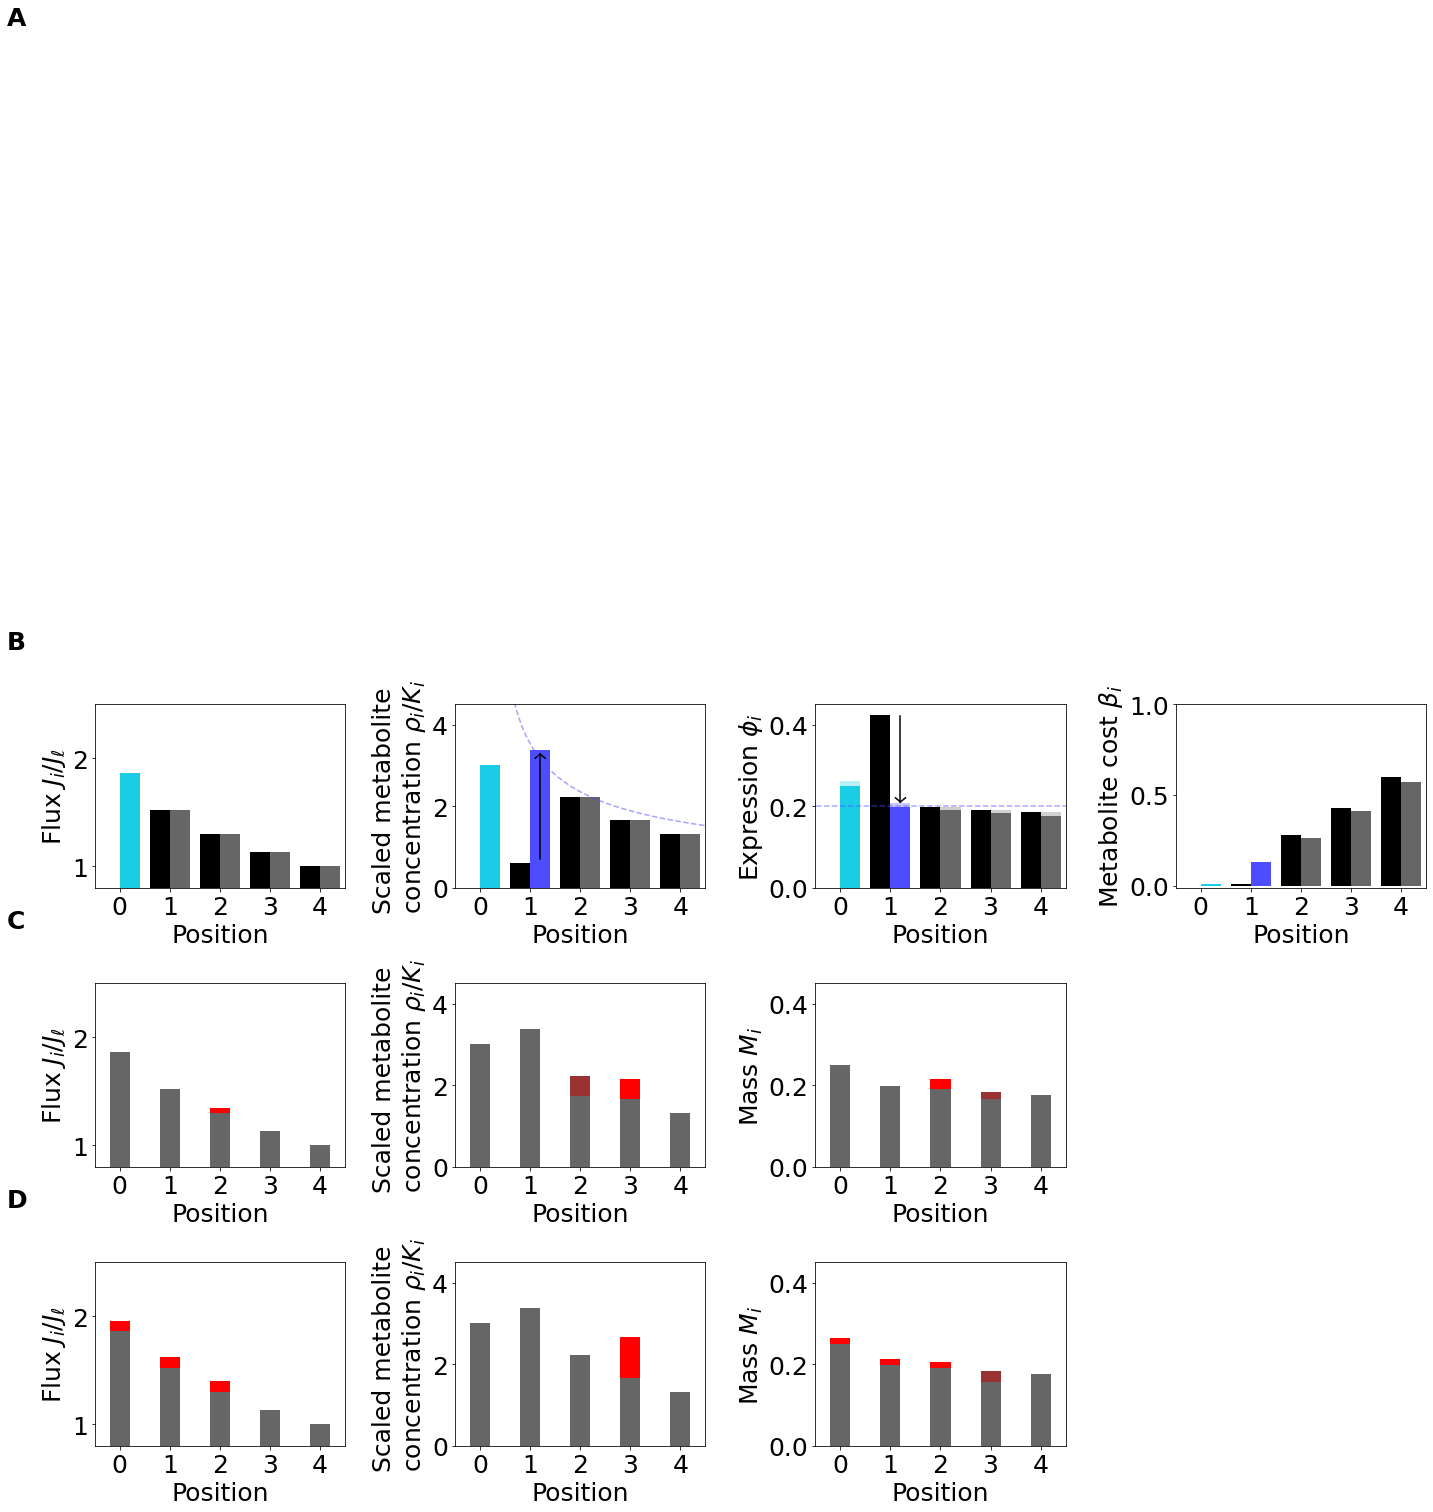

In [898]:
font = {'size'   : 25}
plt.rc('font', **font)

#cm = plt.cm.get_cmap('plasma')
fig, axs =plt.subplots(3, 4, figsize = (20, 12), gridspec_kw={'width_ratios': [5, 5, 5, 5]})

KMmean = 0.1
kappamean = 100
nu = 0.3
Nenzymes = 5

kappas = np.ones(Nenzymes)*kappamean #
KMs = np.ones(Nenzymes)*KMmean #
lamapprox = np.sum(kappas**(-1))**(-1)

args = np.array([*kappas, *KMs, nu, lamapprox])

res = minimize(wrapper3, -5, args = args)
rhos = rhoIterator(kappas, KMs, nu, np.exp(res.x[0]))
phis = findPhis(kappas, KMs, rhos)
jouts = phis*kappas/(1+KMs/rhos)

nu2 = nu*0.204579#nu*0.27539518 #nu*0.204579
args2 = np.array([*kappas[:-1], *KMs[:-1], nu2, lamapprox])

Nenzymes = 4
res2 = minimize(wrapper3, -5, args = args2)
Nenzymes = 5

rhos2 = rhoIterator(kappas[:-1], KMs[:-1], nu2, np.exp(res2.x[0]))
phis2 = findPhis(kappas[:-1], KMs[:-1], rhos2)
jouts2 = phis2*kappas[:-1]/(1+KMs[:-1]/rhos2)

print(rhos)
print(rhos2)

lambdasup = np.sum(kappas**(-1))**(-1)
print(jouts[0]/lambdasup)

w = 0.4

for row in range(3):
    axs[row, 0].set_xlabel("Position")
    axs[row, 0].set_xlim((-.5, Nenzymes-0.5))
    axs[row, 0].set_ylabel(r"Flux $J_i/J_\ell$")
    #axs[row, 0].set_yscale("log")
    axs[row, 0].set_ylim((.8, 2.5))

    axs[row, 1].set_xlabel("Position")
    axs[row, 1].set_xlim((-.5, Nenzymes-0.5))
    axs[row, 1].set_ylabel("Scaled metabolite \n"r"concentration $\rho_i/K_i$")
    axs[row, 1].set_ylim((0, 4.5))

    axs[row, 2].set_xlabel("Position")
    axs[row, 2].set_xlim((-.5, Nenzymes-0.5))
    axs[row, 2].set_ylabel(r"Expression $\phi_i$")
    #axs[row, 2].set_yscale("log")
    axs[row, 2].set_ylim((0., .45))

    axs[row, 3].set_xlabel("Position")
    axs[row, 3].set_xlim((-.5, Nenzymes-0.5))
    axs[row, 3].set_ylabel(r"Metabolite cost $\beta_i$")
    axs[row, 3].set_ylim((-0.01, 1))

print(phis)

print(np.sum(phis), np.sum(phis2))

cost = phis/KMs/(rhos/KMs*(1+rhos/KMs))
cost[-1] = 1e-2

cost2 = phis2/KMs[:-1]/(rhos2/KMs[:-1]*(1+rhos2/KMs[:-1]))
cost2[-1] = 1e-2
print(cost, cost2)

axs[0, 0].bar(np.arange(Nenzymes)[::-1]+w/2, jouts/jouts[0], width = w, color = (0.4, 0.4, .4, 1))
#axs[0, 0].bar(1+w/2, (jouts/jouts[0])[-2], width = w, color = (0.3, 0.3, 1, 1))
axs[0, 0].bar(0+w/2, (jouts/jouts[0])[-1], width = w, color = (0.1, 0.8, 0.9, 1))
axs[0, 0].bar(np.arange(Nenzymes)[:0:-1]-w/2, jouts2/jouts2[0], width = w, color = "black")

axs[0, 1].bar(np.arange(Nenzymes)[::-1]+w/2, rhos/KMs, width = w, color = (0.4, 0.4, .4, 1))
axs[0, 1].bar(1+w/2, (rhos/KMs)[-2], width = w, color = (0.3, 0.3, 1, 1))
axs[0, 1].bar(0+w/2, (rhos/KMs[0])[-1], width = w, color = (0.1, 0.8, 0.9, 1))
axs[0, 1].bar(np.arange(Nenzymes)[:0:-1]-w/2, rhos2/KMs[:-1], width = w, color = "black")
axs[0, 1].plot(np.linspace(1+w/2, 1+w/2, 100), np.linspace(rhos[-2]/KMs[0]-.1, rhos2[-1]/KMs[0]+.1,100), "k-")
axs[0, 1].plot(np.linspace(1+w/2, 1.1+w/2, 2), np.linspace(rhos[-2]/KMs[0], rhos[-2]/KMs[0]-.1, 2)-.1, "k-")
axs[0, 1].plot(np.linspace(1+w/2, .9+w/2, 2), np.linspace(rhos[-2]/KMs[0], rhos[-2]/KMs[0]-.1, 2)-.1, "k-")
axs[0, 1].plot(np.linspace(0, 5, 100)+w/2, 1/np.sqrt(KMmean*np.linspace(0, 5, 100)), "--", color = (0.3, 0.3, 1, 1), alpha = 0.5)

axs[0, 2].bar(np.arange(Nenzymes)[::-1]+w/2, phis, width = w, color = (0.4, 0.4, .4, 1))
axs[0, 2].bar(1+w/2, phis[-2], width = w, color = (0.3, 0.3, 1, 1))
axs[0, 2].bar(0+w/2, phis[-1], width = w, color = (0.1, 0.8, 0.9, 1))
axs[0, 2].bar((np.arange(Nenzymes)[::-1]+w/2)[:-2], (phis*phis2[0]/phis[0])[:-2], width = w, color = (0.4, 0.4, .4, 1), alpha = 0.3)
axs[0, 2].bar(1+w/2, (phis*phis2[0]/phis[0])[-2], width = w, color = (0.3, 0.3, 1, 1), alpha = 0.3)
axs[0, 2].bar(0+w/2, (phis*phis2[0]/phis[0])[-1], width = w, color = (0.1, 0.8, 0.9, 1), alpha = 0.3)
#axs[0, 2].bar(np.arange(Nenzymes)[::-1]+w/2, phis*phis2[0]/phis[0], width = w, color = "orange", alpha = 0.3)
axs[0, 2].bar(np.arange(Nenzymes)[:0:-1]-w/2, phis2, width = w, color = "black", alpha = 1.0)
axs[0, 2].plot(np.linspace(-1, 5.5, 100)+w/2, [1/5]*100, "--", color = (0.3, 0.3, 1, 1), alpha = 0.5)
axs[0, 2].plot(np.linspace(1+w/2, 1+w/2, 100), np.linspace(phis[-2]*phis2[0]/phis[0]+0.002, phis2[-1]-.002,100), "k-")
axs[0, 2].plot(np.linspace(1+w/2, 1.1+w/2, 2), np.linspace(phis[-2]*phis2[0]/phis[0], phis[-2]*phis2[0]/phis[0]+0.01, 2)+0.002, "k-")
axs[0, 2].plot(np.linspace(1+w/2, .9+w/2, 2), np.linspace(phis[-2]*phis2[0]/phis[0], phis[-2]*phis2[0]/phis[0]+0.01, 2)+0.002, "k-")

axs[0, 3].bar(np.arange(Nenzymes)[::-1]+w/2, cost, width = w, color = (0.4, 0.4, .4, 1))
axs[0, 3].bar(1+w/2, cost[-2], width = w, color = (0.3, 0.3, 1, 1))
axs[0, 3].bar(0+w/2, cost[-1], width = w, color = (0.1, 0.8, 0.9, 1))
axs[0, 3].bar(np.arange(Nenzymes)[:0:-1]-w/2, cost2, width = w, color = "black")

for ax in axs.flatten():
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels([0, 1, 2, 3, 4])

fig.tight_layout()

for n, ax in enumerate([axs[0, 0], axs[1, 0], axs[2, 0]]):  
    ax.text(-0.35, 1.30, string.ascii_uppercase[n+1], transform=ax.transAxes, weight='bold')

axs[0, 0].text(-0.35, 4.70, string.ascii_uppercase[0], transform=axs[0, 0].transAxes, weight='bold')


deltaj = .5
newjouts = np.copy(jouts)
newjouts[2] = newjouts[2]+deltaj
newrhos = np.copy(rhos)
newrhos[:-1] = (newjouts[1:]-newjouts[:-1])/newjouts[0]
newphis = newjouts/kappas*(1+KMs/newrhos)

axs[1, 0].bar(np.arange(Nenzymes)[::-1], newjouts/newjouts[0], width = w, color = (1, 0, 0, 1))
axs[1, 1].bar(np.arange(Nenzymes)[::-1], newrhos/KMs, width = w, color = (1, 0, 0, 1))
axs[1, 2].bar(np.arange(Nenzymes)[::-1], newphis, width = w, color = (1, 0, 0, 1))

axs[1, 0].bar(np.arange(Nenzymes)[::-1], jouts/jouts[0], width = w, color = (0.6, 0.2, .2, 1))
axs[1, 1].bar(np.arange(Nenzymes)[::-1], rhos/KMs, width = w, color = (0.6, 0.2, .2, 1))
axs[1, 2].bar(np.arange(Nenzymes)[::-1], phis, width = w, color = (0.6, 0.2, .2, 1))

axs[1, 0].bar(np.arange(Nenzymes)[::-1], np.min(np.array([jouts/jouts[0], newjouts/newjouts[0]]), 0), width = w, color = (0.4, .4, .4, 1))
axs[1, 1].bar(np.arange(Nenzymes)[::-1], np.min(np.array([rhos/KMs, newrhos/KMs]), 0), width = w, color = (0.4, .4, .4, 1))
axs[1, 2].bar(np.arange(Nenzymes)[::-1], np.min(np.array([phis, newphis]), 0), width = w, color = (0.4, .4, .4, 1))

axs[1, 3].axis("off")#bar(np.arange(Nenzymes)[::-1], cost, width = w, color = (0.4, 0.4, .4, 1))
axs[1, 2].set_ylabel(r"Mass $M_i$")

deltaj = 1
newjouts = np.copy(jouts)
newjouts[2:] = newjouts[2:]+deltaj
newrhos = np.copy(rhos)
newrhos[:-1] = (newjouts[1:]-newjouts[:-1])/newjouts[0]
newphis = newjouts/kappas*(1+KMs/newrhos)

axs[2, 0].bar(np.arange(Nenzymes)[::-1], newjouts/newjouts[0], width = w, color = (1, 0, 0, 1))
axs[2, 1].bar(np.arange(Nenzymes)[::-1], newrhos/KMs, width = w, color = (1, 0, 0, 1))
axs[2, 2].bar(np.arange(Nenzymes)[::-1], newphis, width = w, color = (1, 0, 0, 1))

axs[2, 0].bar(np.arange(Nenzymes)[::-1], jouts/jouts[0], width = w, color = (0.6, 0.2, .2, 1))
axs[2, 1].bar(np.arange(Nenzymes)[::-1], rhos/KMs, width = w, color = (0.6, 0.2, .2, 1))
axs[2, 2].bar(np.arange(Nenzymes)[::-1], phis, width = w, color = (0.6, 0.2, .2, 1))

axs[2, 0].bar(np.arange(Nenzymes)[::-1], np.min(np.array([jouts/jouts[0], newjouts/newjouts[0]]), 0), width = w, color = (0.4, .4, .4, 1))
axs[2, 1].bar(np.arange(Nenzymes)[::-1], np.min(np.array([rhos/KMs, newrhos/KMs]), 0), width = w, color = (0.4, .4, .4, 1))
axs[2, 2].bar(np.arange(Nenzymes)[::-1], np.min(np.array([phis, newphis]), 0), width = w, color = (0.4, .4, .4, 1))

axs[2, 3].axis("off")#bar(np.arange(Nenzymes)[::-1], cost, width = w, color = (0.4, 0.4, .4, 1))
axs[2, 2].set_ylabel(r"Mass $M_i$")




plt.savefig("/Users/leonseeger/Dropbox/EffluxPumpsLeon/Draft/CommentingVersion/SI_schematic_barplots.pdf", bbox_inches="tight", format = 'pdf')

### the rest of this figure was created in vectornator, not with python

(5000, 42)
(5000, 1000, 3, 20)
(5000, 1000, 6, 20)
(5000, 3, 6, 1, 20)
(5000, 1, 20)


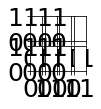

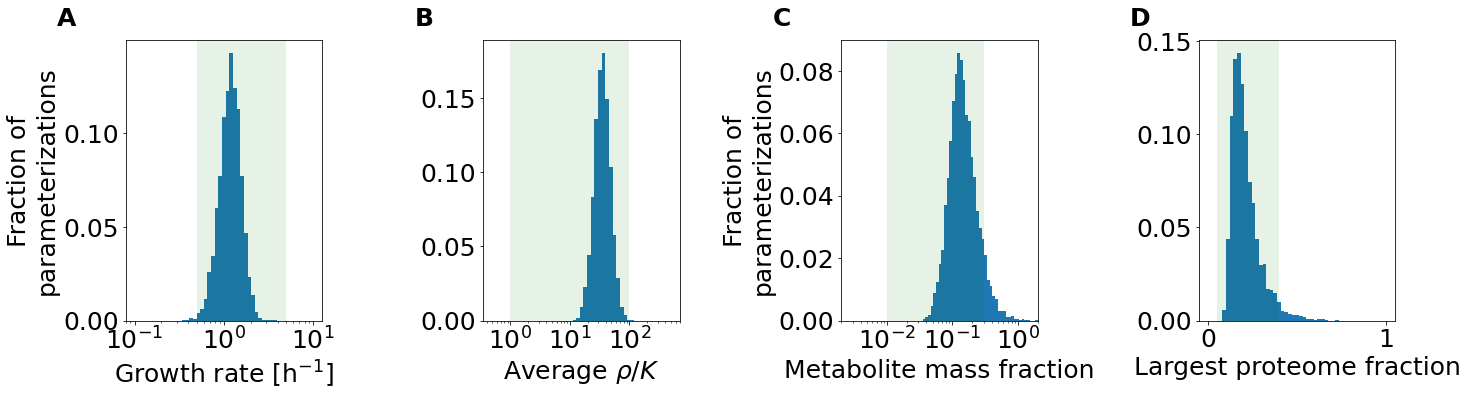

In [900]:
data_folder = "/Users/leonseeger/Desktop/largeDBFiles/"
font = {'size'   : 25}
plt.rc('font', **font)


#fig, axs = plt.subplots(2, 2, figsize = (10, 10))
Nenzymes = 20

fig, axs = plt.subplots(2, 4, figsize = (1, 1))
fig = plt.figure(figsize = (25, 10))
gs = gridspec.GridSpec(2, 5)
#gs.update(wspace=0, hspace=0.15)
axs[0, 0] = plt.subplot(gs[0, 0])
axs[0, 1] = plt.subplot(gs[0, 1])
axs[1, 0] = plt.subplot(gs[0, 2])
axs[1, 1] = plt.subplot(gs[0, 3])

filename = "PhysiologicalOptimalBalancedGrowthStates_nutrientLimitation.npy"

fullensemble = np.load(data_folder+filename)
parameters = np.load(data_folder+"physiologicalParameterset.npy")
print(np.shape(parameters))
print(np.shape(fullensemble))

parameterensemble = np.ones(np.shape(fullensemble))
parameterensemble[:, :, 0, :] = np.repeat(parameters[:, None, :Nenzymes], np.shape(fullensemble)[1], axis = 1)
parameterensemble[:, :, 1, :] = np.repeat(parameters[:, None, Nenzymes:2*Nenzymes], np.shape(fullensemble)[1], axis = 1)

fullensemble = np.concatenate((parameterensemble, fullensemble), axis = 2)

fullensemble = fullensemble[~np.isnan(fullensemble[:, 70, 3, -1])]

print(np.shape(fullensemble))


efficiencybins = np.logspace(-1, 1, 6)

ilocs = []
ensemble = []

for j in range(np.shape(fullensemble)[0]):
    maxgr = fullensemble[j, 0, 5, 0]
    halfgrs = (fullensemble[j, :, 5, 0].T-maxgr/2.1).T
    halfgrs[halfgrs<0] = np.max(halfgrs)
    tenthgrs = (fullensemble[j, :, 5, 0].T-maxgr/10.1).T
    tenthgrs[tenthgrs<0] = np.max(tenthgrs)
    
    iloc = np.where(halfgrs == np.nanmin(halfgrs))
    iloc10 = np.where(tenthgrs == np.nanmin(tenthgrs))
    ilocs.append(iloc[0][0])
    ensemble.append(np.array([fullensemble[j, 0], fullensemble[j, iloc[0][0]], fullensemble[j, iloc10[0][0]]]))
    #print(np.shape(np.array([ensemble[j, 0], ensemble[j, iloc]])))

ilocs = np.array(ilocs)
ensemble = np.array(ensemble)[:, :, :, None, :]

#print(np.shape(smallensemble))
efficiencies = (np.sum(fullensemble[:, 0, 0, :]**(-1), 1)/np.sum(np.sqrt(fullensemble[:, 0, 1, :]/fullensemble[:, 0, 0, :]), 1)*np.sqrt(fullensemble[:, 0, 1, :]*fullensemble[:, 0, 0, :]).T).T
efficiencies = efficiencies[:, None, :]
print(np.shape(ensemble))
print(np.shape(efficiencies))


#what are high proteome mass fractions of the largest enzyme correlated with
#fig, axs = plt.subplots(2, 2, figsize = (15, 14))
axs[0, 0].hist(ensemble[:, 0, 5, 0, 0]*10**(-.5), bins = np.logspace(np.log10(0.1), np.log10(10), 50), weights = 0*ensemble[:, 0, 5, 0, 0]+1/(np.shape(ensemble[:, 0, 5, 0, 0])[0]))
axs[0, 0].set_xscale("log")
axs[0,0].set_xlabel("Growth rate [h$^{-1}$]")
limits = axs[0,0].get_ylim()
axs[0,0].add_patch(plt.Polygon([[.5, limits[0]], [.5, limits[1]], [5, limits[1]], [5, limits[0]]], facecolor='green', clip_on = True, linewidth = 0, alpha = .1))
axs[0,0].set_ylabel("Fraction of\nparameterizations")

axs[0,1].hist(np.exp(np.mean(np.log(ensemble[:, 0, 3, 0, :]/ensemble[:, 0, 1, 0, :]), 1)), bins = np.logspace(np.log10(.5), np.log10(500), 50), weights = 0*ensemble[:, 0, 5, 0, 0]+1/(np.shape(ensemble[:, 0, 5, 0, 0])[0]))
#axs[0,1].hist(np.mean(1/(1+1/(ensemble[:, 0, 3, 0, :]/ensemble[:, 0, 1, 0, :])), 1), bins = np.linspace(0, 1, 200), weights = 0*ensemble[:, 0, 5, 0, 0]+1/(np.shape(ensemble[:, 0, 5, 0, 0])[0]))
#axs[0,1].hist((ensemble[:, 0, 3, 0, :]/ensemble[:, 0, 1, 0, :]).flatten(), bins = np.logspace(np.log10(.5), np.log10(500), 50))
axs[0,1].set_xscale("log")
#axs[0,1].set_xlabel("Average saturation")
axs[0,1].set_xlabel(r"Average $\rho/K$")
limits = axs[0,1].get_ylim()
#axs[0,1].set_xlim(0.7, 1)
#axs[0,1].add_patch(plt.Polygon([[0.8, limits[0]], [0.8, limits[1]], [0.95, limits[1]], [0.95, limits[0]]], facecolor='green', clip_on = True, linewidth = 0, alpha = .1))
axs[0,1].add_patch(plt.Polygon([[1, limits[0]], [1, limits[1]], [100, limits[1]], [100, limits[0]]], facecolor='green', clip_on = True, linewidth = 0, alpha = .1))


axs[1,0].hist(np.sum(ensemble[:, 0, 3, 0, :-1], 1), bins = np.logspace(np.log10(0.02), np.log10(2), 50), weights = 0*ensemble[:, 0, 5, 0, 0]+1/(np.shape(ensemble[:, 0, 5, 0, 0])[0]))
#axs[1,0].hist(np.sum(ensemble[:, 0, 3, 0, :-1], 1), bins = np.logspace(np.log10(0.001), np.log10(2), 50))
axs[1,0].set_xscale("log")
axs[1,0].set_xlabel("Metabolite mass fraction")
axs[1,0].set_xlim(2e-3, 2)
limits = axs[1,0].get_ylim()
axs[1,0].add_patch(plt.Polygon([[.01, limits[0]], [.01, limits[1]], [.3, limits[1]], [.3, limits[0]]], facecolor='green', clip_on = True, linewidth = 0, alpha = .1))
axs[1,0].set_ylabel("Fraction of\nparameterizations")

axs[1,1].hist(np.max(ensemble[:, 0, 4, 0, :], 1), bins = np.linspace(0, 1, 50), weights = 0*ensemble[:, 0, 5, 0, 0]+1/(np.shape(ensemble[:, 0, 5, 0, 0])[0]))
#axs[1,1].hist(np.max(ensemble[:, 0, 4, 0, :], 1), bins = np.linspace(0, 1, 50))
axs[1,1].set_xlabel("Largest proteome fraction")
limits = axs[1,1].get_ylim()
axs[1,1].add_patch(plt.Polygon([[.4, limits[0]], [.4, limits[1]], [.05, limits[1]], [.05, limits[0]]], facecolor='green', clip_on = True, linewidth = 0, alpha = .1))


fig.tight_layout()

for n, ax in enumerate([axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]]):  
    if n == 4:
        ax.text(-0.1, 1.024, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')
    else:
        ax.text(-0.35, 1.05, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')


plt.savefig("/Users/leonseeger/Dropbox/EffluxPumpsLeon/Draft/CommentingVersion/SI_validity.pdf", bbox_inches="tight", format = 'pdf')
#effect of saturation is negligible - the largest mass fraction is given by max(1/kappa/(sum(1/kappa)))

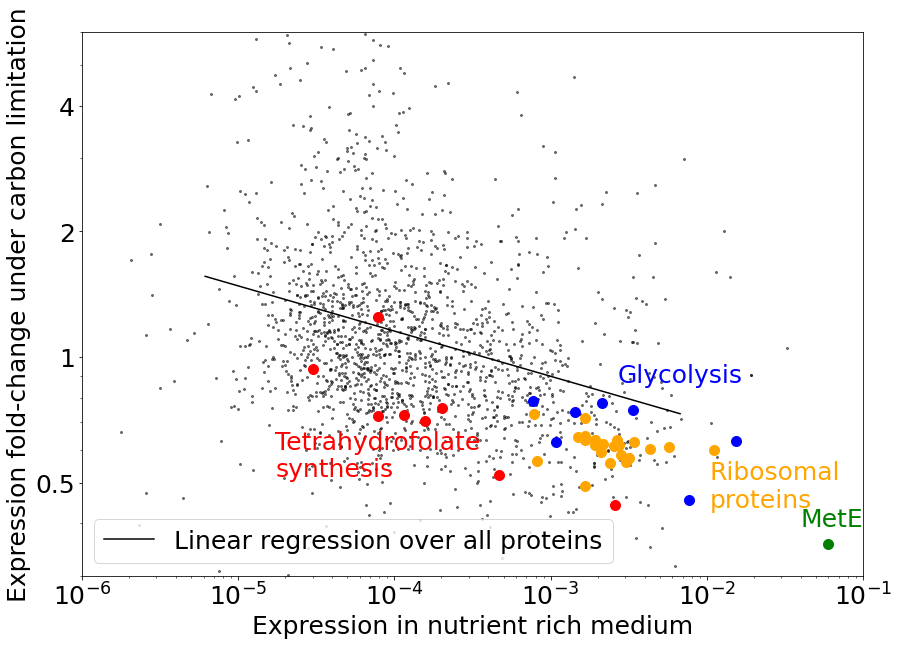

In [701]:
fig, axs = plt.subplots(1, 1, figsize = (14, 10))
font = {'size'   : 25} #20
plt.rc('font', **font)

ax = axs

dataset = pd.read_excel("/Users/leonseeger/Desktop/largeDBFiles/msb20209536-sup-0010-datasetev9.xlsx", sheet_name = "EV9-AbsoluteMassFractions-2", index_col = 1, header=6) 

data = dataset[["C2", "C3", "C4", "C5", "C6", "C7"]].to_numpy()
grs = np.array([0.91, 0.77, 0.69, 0.56, 0.48, 0.35])
meangr = np.mean(grs)

names = dataset[["Gene name"]].to_numpy()
UniIDs = dataset[["Protein ID"]].to_numpy()
means = np.mean(data, 1)
means[means == 0] = np.nan
slopes = np.sum((data.T-means).T*(grs-meangr), 1)/np.sum((grs-meangr)**2)
offsets = means-slopes*meangr
r2s = np.sum((data.T-means).T*(grs-meangr), 1)/np.sqrt(np.sum((grs-meangr)**2)*np.sum((data.T-means).T**2, 1))
squares = np.sum((data - ((np.array([slopes]*len(grs)).T*grs).T+offsets).T)**2, 1)/means**2

#ax = axs[0, 2]
x = (data[:, 0])[~np.isnan(offsets)]
y = (data[:, -1]/data[:, 0])[~np.isnan(offsets)]
validdata = np.all(np.array([x>0, y>0]), 0)
y = np.log(y[validdata])
x = np.log(x[validdata])

if False:
    for i in range(150):
        permuted_data = dataset[np.random.permutation(["C2", "C3", "C4", "C5", "C6", "C7"])].to_numpy()
        permuted_slopes = np.sum((permuted_data.T-means).T*(grs-meangr), 1)/np.sum((grs-meangr)**2)
        permuted_offsets = means-permuted_slopes*meangr
        permuted_x = (permuted_data[:, 0])[~np.isnan(permuted_offsets)]
        permuted_y = (permuted_data[:, -1]/permuted_data[:, 0])[~np.isnan(permuted_offsets)]
        permuted_validdata = np.all(np.array([permuted_x>0, permuted_y>0]), 0)
        permuted_y = np.log(permuted_y[permuted_validdata])
        permuted_x = np.log(permuted_x[permuted_validdata])
        permuted_slope, permuted_intercept, permuted_r_value, permuted_p_value, permuted_std_err = linregress(permuted_x,permuted_y)
        ax.plot(np.exp(xs), np.exp(permuted_slope*xs+permuted_intercept), "k--", alpha = 0.1)

slope, intercept, r_value, p_value, std_err = linregress(x,y)
#print(p_value, permuted_p_value)

ax.scatter(np.exp(x), np.exp(y), s = 4, c="k", alpha = 0.5)#np.abs(r2s[~np.isnan(offsets)][validdata]))
xs = np.linspace(-12, -5, 100)
ax.plot(np.exp(xs), np.exp(slope*xs+intercept), label = "Linear regression over all proteins", color = "k")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Expression in nutrient rich medium")
ax.set_ylabel("Expression fold-change under carbon limitation")

RibosomalIDs = []
with open("pantherRibosomalProteins.txt") as file:
    for line in file:
        if "PC00202" in line: #finds all ribosomal proteins
            RibosomalIDs.append(line[39:45])
            #print(line)

maskR = []
index = 0
for UniID in UniIDs:
    if UniID not in RibosomalIDs:
        maskR.append(index)
    index += 1

offsetsR = np.copy(offsets)
offsetsR[maskR] = np.nan

x = (data[:, 0])[~np.isnan(offsetsR)]
y = (data[:, -1]/data[:, 0])[~np.isnan(offsetsR)]
validdata = np.all(np.array([x>0, y>0]), 0)
y = np.log(y[validdata])
x = np.log(x[validdata])
ax.scatter(np.exp(x), np.exp(y), s = 100, alpha = 1, c = "orange")
ax.annotate("Ribosomal\nproteins", (np.exp(np.nanmean(x))*4.5, np.exp(np.nanmean(y))/1.4), color = "orange")


xM = data[np.where(names=="metE")[0][0], 0]
yM = data[np.where(names=="metE")[0][0], -1]/data[np.where(names=="metE")[0][0], 0]
#print(data[np.where(names=="metE")[0][0], 0], data[np.where(names=="metE")[0][0], -1])
ax.scatter(xM, yM, s = 100, alpha = 1, c = "g")
ax.annotate("MetE", (xM/1.5, yM*1.1), color = "g")

ax.set_ylim(0.3, 6)
ax.set_yticks([0.5, 1, 2, 4])
ax.set_yticklabels([0.5, 1, 2, 4])
ax.set_xlim(1e-6, 1e-1)



GlycolyticIDs = []
with open("pantherGlycolyticProteins.txt") as file:
    for line in file:
        GlycolyticIDs.append(line[39:45])

maskG = []
index = 0
for UniID in UniIDs:
    if UniID not in GlycolyticIDs:
        maskG.append(index)
    index += 1

offsetsG = np.copy(offsets)
offsetsG[maskG] = np.nan

x = (data[:, 0])[~np.isnan(offsetsG)]
y = (data[:, -1]/data[:, 0])[~np.isnan(offsetsG)]
validdata = np.all(np.array([x>0, y>0]), 0)
y = np.log(y[validdata])
x = np.log(x[validdata])
ax.scatter(np.exp(x), np.exp(y), s = 100, alpha = 1, c = "b")
ax.annotate("Glycolysis", (np.exp(np.nanmean(x)), np.exp(np.nanmean(y))*1.3), color = "b")

THFIDs = []
#with open("pantherTCAProteins.txt") as file:
with open("pantherTHFSynthesis.txt") as file:
    for line in file:
        THFIDs.append(line[39:45])

maskT = []
index = 0
for UniID in UniIDs:
    if UniID not in THFIDs:
        maskT.append(index)
    index += 1

offsetsT = np.copy(offsets)
offsetsT[maskT] = np.nan

x = (data[:, 0])[~np.isnan(offsetsT)]
y = (data[:, -1]/data[:, 0])[~np.isnan(offsetsT)]
validdata = np.all(np.array([x>0, y>0]), 0)
y = np.log(y[validdata])
x = np.log(x[validdata])
ax.scatter(np.exp(x), np.exp(y), s = 100, alpha = 1, color = "r")
ax.annotate("Tetrahydrofolate\nsynthesis", (np.exp(np.nanmean(x))/10, np.exp(np.nanmean(y))/1.4), color = "r")

ax.legend()
plt.savefig("/Users/leonseeger/Dropbox/EffluxPumpsLeon/Draft/CommentingVersion/MainText4b.pdf", bbox_inches="tight", format = 'pdf')


(5000, 42)
(5000, 1000, 3, 20)
(5000, 1000, 6, 20)
(5000, 42)
(5000, 1000, 3, 20)
(1, 1000, 6, 20)
(1, 3, 6, 1, 20)
(1, 1, 20)
(5000, 42)
(5000, 1000, 3, 20)
(1, 1000, 6, 20)
(1, 3, 6, 1, 20)
(1, 1, 20)
(5000, 42)
(5000, 1000, 3, 20)
(1, 1000, 6, 20)
(1, 3, 6, 1, 20)
(1, 1, 20)
(5000, 42)
(5000, 1000, 3, 20)
(5000, 1000, 6, 20)
(5000, 3, 6, 1, 20)
(5000, 1, 20)
(5000, 20)
(5000, 20)
(5000, 3, 6, 1, 20)
(5000, 1, 20)
(5000, 19)


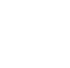

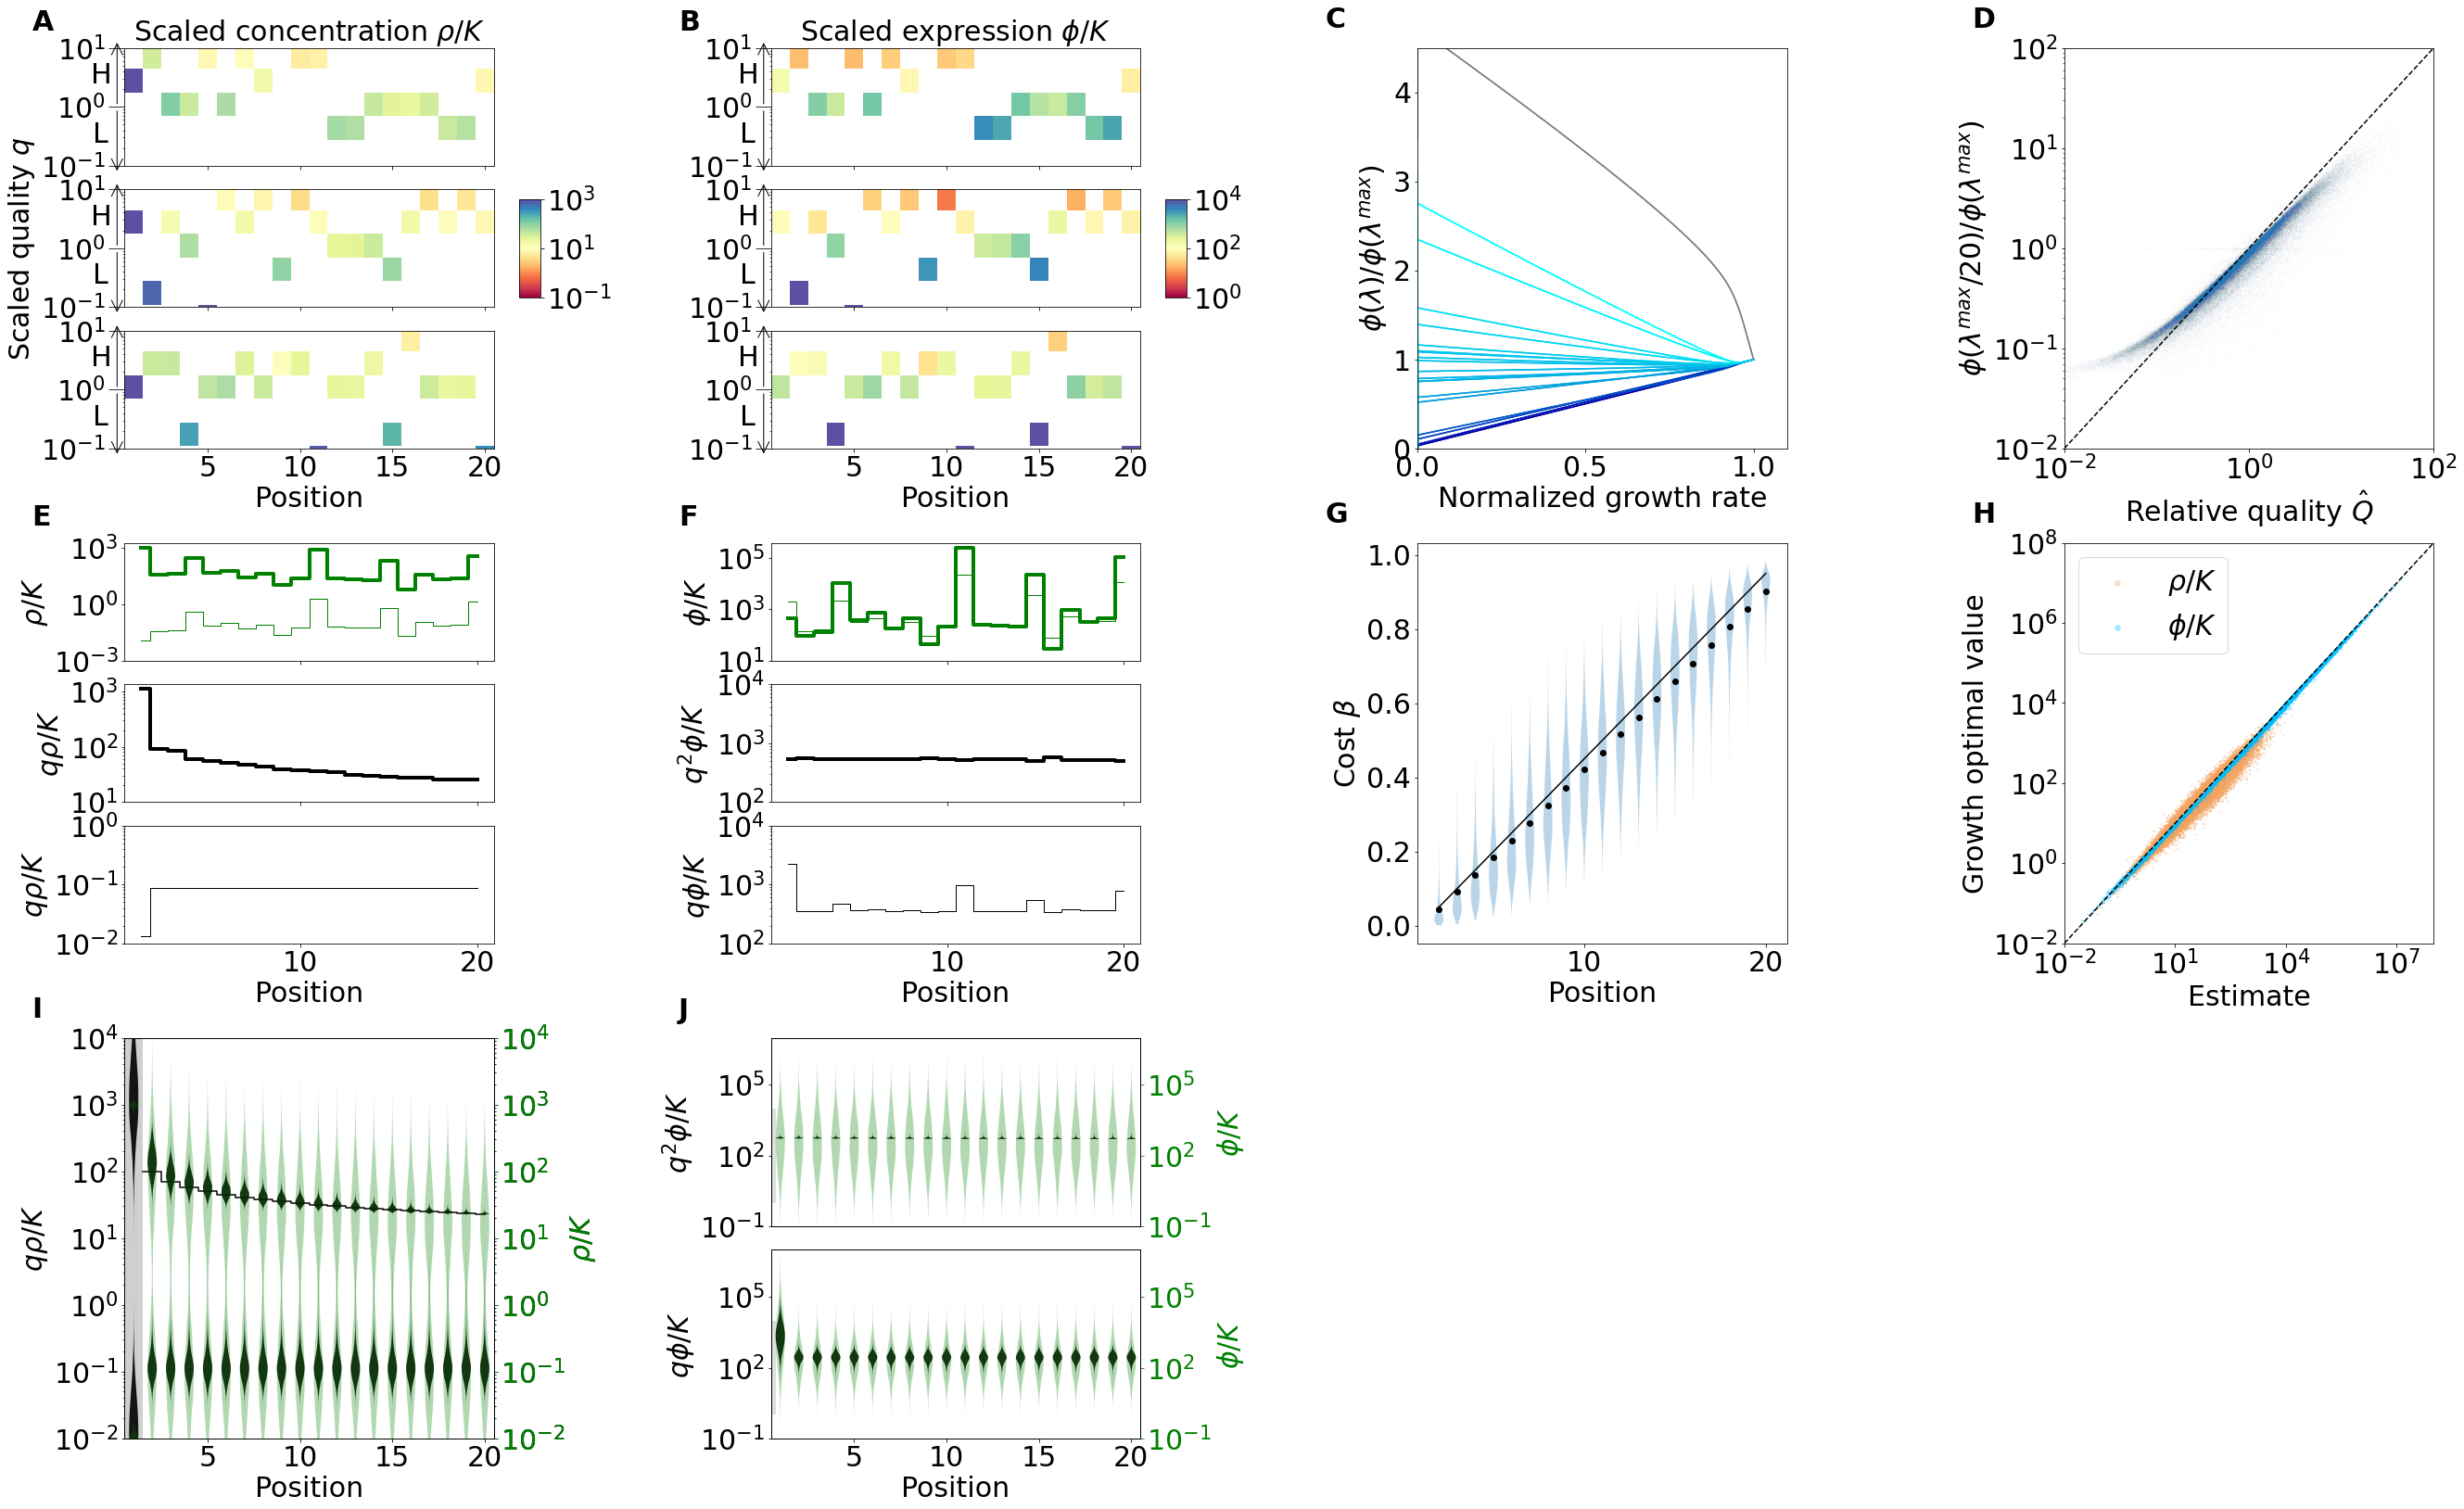

In [902]:
#repeat with tighter spacing of rho_0

#### Nutrient limitation SI
#fig, axs = plt.subplots(2, 2, figsize = (10, 10))
Nenzymes = 20
font = {'size'   : 30} #25#20
plt.rc('font', **font)
fig, axs = plt.subplots(9, 4, figsize = (1, 1))
for ax in axs.flatten():
    ax.axis("off")

fig = plt.figure(figsize = (50, 29))
gs = gridspec.GridSpec(21, 28)
gs.update(wspace=0, hspace=0.5)

axs[0, 0] = plt.subplot(gs[0:2, 0:4])
axs[0, 1] = plt.subplot(gs[0:2, 7:11])
axs[1, 0] = plt.subplot(gs[2:4, 0:4])
axs[1, 1] = plt.subplot(gs[2:4, 7:11])
axs[2, 0] = plt.subplot(gs[4:6, 0:4])
axs[2, 1] = plt.subplot(gs[4:6, 7:11])

axs[3, 0] = plt.subplot(gs[7:9, 0:4])
axs[3, 1] = plt.subplot(gs[7:9, 7:11])
axs[4, 0] = plt.subplot(gs[9:11, 0:4])
axs[4, 1] = plt.subplot(gs[9:11, 7:11])
axs[5, 0] = plt.subplot(gs[11:13, 0:4])
axs[5, 1] = plt.subplot(gs[11:13, 7:11])

axs[0, 2] = plt.subplot(gs[0:6, 14:18])
axs[0, 3] = plt.subplot(gs[0:6, 21:25])

axs[3, 2] = plt.subplot(gs[7:13, 14:18])
axs[3, 3] = plt.subplot(gs[7:13, 21:25])

axs[1, 2] = plt.subplot(gs[14:20, 0:4])
axs[1, 3] = plt.subplot(gs[14:17, 7:11])
axs[2, 3] = plt.subplot(gs[17:20, 7:11])

filename = "PhysiologicalOptimalBalancedGrowthStates_nutrientLimitation.npy"

fullensemble = np.load(data_folder+filename)
parameters = np.load(data_folder+"physiologicalParameterset.npy")
print(np.shape(parameters))
print(np.shape(fullensemble))

parameterensemble = np.ones(np.shape(fullensemble))
parameterensemble[:, :, 0, :] = np.repeat(parameters[:, None, :Nenzymes], np.shape(fullensemble)[1], axis = 1)
parameterensemble[:, :, 1, :] = np.repeat(parameters[:, None, Nenzymes:2*Nenzymes], np.shape(fullensemble)[1], axis = 1)

fullensemble = np.concatenate((parameterensemble, fullensemble), axis = 2)

fullensemble = fullensemble[~np.isnan(fullensemble[:, 70, 3, -1])]

print(np.shape(fullensemble))

KMmean = np.exp(np.mean(np.log(fullensemble[:, 0, 1, :])))

loc = [2, 1, 0]
for ind in range(3):
    filename = "PhysiologicalOptimalBalancedGrowthStates_nutrientLimitation.npy"

    fullensemble = np.load(data_folder+filename)
    parameters = np.load(data_folder+"physiologicalParameterset.npy")
    print(np.shape(parameters))
    print(np.shape(fullensemble))

    parameterensemble = np.ones(np.shape(fullensemble))
    parameterensemble[:, :, 0, :] = np.repeat(parameters[:, None, :Nenzymes], np.shape(fullensemble)[1], axis = 1)
    parameterensemble[:, :, 1, :] = np.repeat(parameters[:, None, Nenzymes:2*Nenzymes], np.shape(fullensemble)[1], axis = 1)

    fullensemble = np.concatenate((parameterensemble, fullensemble), axis = 2)
    fullensemble = fullensemble[loc[ind]][None, :, :, :]
    print(np.shape(fullensemble))


    efficiencybins = np.logspace(-1.4, 1.4, 8)#np.logspace(-1, 1, 6)

    ilocs = []
    ensemble = []

    for j in range(np.shape(fullensemble)[0]):
        maxgr = fullensemble[j, 0, 5, 0]
        halfgrs = (fullensemble[j, :, 5, 0].T-maxgr/2.1).T
        halfgrs[halfgrs<0] = np.max(halfgrs)
        tenthgrs = (fullensemble[j, :, 5, 0].T-maxgr/20.1).T
        tenthgrs[tenthgrs<0] = np.max(tenthgrs)

        iloc = np.where(halfgrs == np.nanmin(halfgrs))
        iloc10 = np.where(tenthgrs == np.nanmin(tenthgrs))
        ilocs.append(iloc[0][0])
        ensemble.append(np.array([fullensemble[j, 0], fullensemble[j, iloc[0][0]], fullensemble[j, iloc10[0][0]]]))
        #print(np.shape(np.array([ensemble[j, 0], ensemble[j, iloc]])))

    ilocs = np.array(ilocs)
    ensemble = np.array(ensemble)[:, :, :, None, :]

    #print(np.shape(smallensemble))
    efficiencies = np.sqrt(fullensemble[:, 0, 0, :].T*fullensemble[:, 0, 1, :].T/fullensemble[:, 0, 5, 0]).T/np.sqrt(KMmean*Nenzymes)
    #efficiencies = (np.sum(fullensemble[:, 0, 0, :]**(-1), 1)/np.sum(np.sqrt(fullensemble[:, 0, 1, :]/fullensemble[:, 0, 0, :]), 1)*np.sqrt(fullensemble[:, 0, 1, :]*fullensemble[:, 0, 0, :]).T).T
    efficiencies = efficiencies[:, None, :]
    print(np.shape(ensemble))
    print(np.shape(efficiencies))

    branch = 0
    colormeshrho = np.zeros((Nenzymes, np.shape(efficiencybins)[0]-1))
    colormeshphi = np.zeros((Nenzymes, np.shape(efficiencybins)[0]-1))
    for i in range(np.shape(efficiencybins)[0]-1):
        mask = (efficiencies[:, branch, :]>efficiencybins[i])*(efficiencies[:, branch, :]<=efficiencybins[i+1])
        fullmask = mask[:, None, None, :]*np.ones((np.shape(ensemble)[1], np.shape(ensemble)[2]))[None, :, :, None]
        maskeddata = np.where(fullmask, ensemble[:, :, :, branch, :], np.nan)
        logsaturation = np.log10(maskeddata[:, 0, 3, :]/maskeddata[:, 0, 1, :])
        logexpression = np.log10(maskeddata[:, 0, 4, :]/maskeddata[:, 0, 1, :])
        colormeshrho[:, i] = np.nanmean(logsaturation, 0)
        colormeshphi[:, i] = np.nanmean(logexpression, 0)

    heatmap = axs[ind, 0].pcolormesh(np.arange(Nenzymes)[::-1]+1, np.sqrt(efficiencybins[1:]*efficiencybins[:-1]), colormeshrho.T, cmap = cm, vmin = -1, vmax = 3)
    heatmap2 = axs[ind, 1].pcolormesh(np.arange(Nenzymes)[::-1]+1, np.sqrt(efficiencybins[1:]*efficiencybins[:-1]), colormeshphi.T, cmap = cm, vmin = 0, vmax = 4)

ind = 1
axs[ind, 0].set_ylabel(r"Scaled quality $q$")

axcb = plt.subplot(gs[2*ind:2*ind+2, 4])
divider = make_axes_locatable(axcb)
cax = divider.append_axes("top", size="-10%").axis('off')
cax = divider.append_axes("bottom", size="-10%").axis('off')
cax = divider.append_axes("left", size="100%", pad=0.05).axis('off')
cax = divider.append_axes("right", size="200%", pad=0.05).axis('off')
cb = fig.colorbar(heatmap, cax=axcb)#, label = r"$\rho/K$")
axcb.set_yticks([-1, 1, 3])
axcb.set_yticklabels([r"$10^{-1}$", r"$10^{1}$", r"$10^{3}$"])

axcb2 = plt.subplot(gs[2*ind:2*ind+2, 11])
divider = make_axes_locatable(axcb2)
cax = divider.append_axes("top", size="-10%").axis('off')
cax = divider.append_axes("bottom", size="-10%").axis('off')
cax = divider.append_axes("left", size="100%", pad=0.05).axis('off')
cax = divider.append_axes("right", size="200%", pad=0.05).axis('off')
fig.colorbar(heatmap2, cax=axcb2)#, label = r"$\phi/K$")
axcb2.set_yticks([0, 2, 4])
axcb2.set_yticklabels([r"$10^{0}$", r"$10^{2}$", r"$10^{4}$"])

axs[0, 0].set_title(r'Scaled concentration $\rho/K$')
axs[0, 1].set_title(r'Scaled expression $\phi/K$')

axs[0, 0].set_xticklabels([])
axs[0, 1].set_xticklabels([])
axs[1, 0].set_xticklabels([])
axs[1, 1].set_xticklabels([])
axs[2, 0].set_xlabel("Position")
axs[2, 1].set_xlabel("Position")

for ax in [axs[0, 0], axs[1, 0], axs[2, 0], axs[0, 1], axs[1, 1], axs[2, 1]]:
    ax.set_yscale("log")
    ax.set_ylim(1e-1, 1e1)
    
    ax.yaxis.set_tick_params(which='major', length=17)
    ax.annotate('', xy=(-0.02, -.06), xycoords='axes fraction', xytext=(-0.02, .48), arrowprops=dict(arrowstyle="->", color='k'))
    ax.annotate('', xy=(-0.02, 1.06), xycoords='axes fraction', xytext=(-0.02, .51), arrowprops=dict(arrowstyle="->", color='k'))
    ax.text(-1.3, 2.5, "H")
    ax.text(-1.2, 1/4, "L")
    

shift = 0
linewidths = [4, 1]
colors = np.array([["k", "k"], ["k", "k"]])#np.array([["chocolate", "chocolate"], ["orange", "orange"]])
#colors = np.array([["k", "chocolate"], ["dimgrey", "orange"]])
colorsPhi = np.array([["k", "k"], ["k", "k"]])#np.array([["darkblue", "darkblue"], ["cyan", "cyan"]])
#colorsPhi = np.array([["k", "darkblue"], ["dimgrey", "cyan"]])
meancolors = ["k", "dimgrey"]
effs = ["L", "H"]
effcolors = ["b", "orange"]

i = 0
for gr in range(2):
    meanN = np.nanmean(np.log10(ensemble[:, :, 4, 0, :]/ensemble[:, :, 1, 0, :]))
    stdN = np.nanstd(np.log10(ensemble[:, :, 4, 0, :]/ensemble[:, :, 1, 0, :]))
    
    efficiencybins = np.logspace(-5, 5, 3)
    meanNs = []
    stdNs = []
    meanNs2 = []
    stdNs2 = []
    piefractions = []
    
    maskeddata = ensemble[:, :, :, branch, :]
    logsaturation = np.log10(maskeddata[:, gr*2, 3, :]/maskeddata[:, 0, 1, :])
    logexpression = np.log10(maskeddata[:, gr*2, 4, :]/maskeddata[:, 0, 1, :])
    meanNs.append(10**np.nanmean(logsaturation, 0))
    stdNs.append(10**np.nanstd(logsaturation, 0))
    meanNs2.append(10**(np.nanmean(logexpression, 0)))
    stdNs2.append(10**(np.nanstd(logexpression, 0)))
    
    axs[3, 0].step(np.arange(20)[::-1]+1+shift, (meanNs[-1]), "g", linewidth = linewidths[gr], where = "mid")
    axs[3, 1].step(np.arange(20)[::-1]+1+shift, (meanNs2[-1]), "g", linewidth = linewidths[gr], where = "mid")
    
    #axs[3, 0].step(np.arange(20)[::-1]+1+shift, ensemble[0, gr*2, 3, 0, :], "g", linewidth = linewidths[gr], where = "mid")
    #axs[3, 1].step(np.arange(20)[::-1]+1+shift, ensemble[0, gr*2, 4, 0, :], "g", linewidth = linewidths[gr], where = "mid")
    
    
    if gr == 0:
        axs[4, 0].step(np.arange(20)[::-1]+1+shift, efficiencies[0, 0, :]*(meanNs[-1]), colors[i][gr], linewidth = linewidths[gr], where = "mid")
        axs[4, 1].step(np.arange(20)[::-1]+1+shift, efficiencies[0, 0, :]**2*(meanNs2[-1]), colorsPhi[i][gr], linewidth = linewidths[gr], where = "mid")

    if gr == 1:
        axs[5, 0].step(np.arange(20)[::-1]+1+shift, efficiencies[0, 0, :]*(meanNs[-1]), colors[i][gr], linewidth = linewidths[gr], where = "mid")
        axs[5, 1].step(np.arange(20)[::-1]+1+shift, efficiencies[0, 0, :]*(meanNs2[-1]), colorsPhi[i][gr], linewidth = linewidths[gr], where = "mid")

    colorQ = (np.log10(efficiencies[0, 0, :])-np.min(np.log10(efficiencies[0, 0, :])))/np.max(np.log10(efficiencies[0, 0, :])-np.min(np.log10(efficiencies[0, 0, :])))
    for j in range(Nenzymes-1):
        axs[0, 2].plot(np.nanmean(fullensemble[:, :, 5, 0]/fullensemble[:, 0, 5, 0][:, None], 0), fullensemble[0, :, 4, j]/fullensemble[0, 0, 4, j], color = cmQ(colorQ[j]), alpha = 1)
    j = Nenzymes-1
    axs[0, 2].plot(np.nanmean(fullensemble[:, :, 5, 0]/fullensemble[:, 0, 5, 0][:, None], 0), fullensemble[0, :, 4, j]/fullensemble[0, 0, 4, j], color = "gray", alpha = 1)

axs[0, 2].set_xlim(0, 1.1)
axs[0, 2].set_ylim(0, 4.5)
axs[0, 2].set_xlabel("Normalized growth rate")
axs[0, 2].set_ylabel(r"$\phi(\lambda)/\phi(\lambda^{max})$")

        
for ax in axs.flatten()[6:]:
    ax.set_yscale("log")
    

axs[3, 0].set_xticklabels([])
axs[3, 1].set_xticklabels([])
axs[4, 0].set_xticklabels([])
axs[4, 1].set_xticklabels([])
axs[5, 0].set_xlabel("Position")
axs[5, 1].set_xlabel("Position")

axs[3, 0].set_yticks([1e-3, 1e0, 1e3])
axs[3, 1].set_yticks([1e1, 1e3, 1e5])
axs[4, 0].set_yticks([1e1, 1e2, 1e3])
axs[4, 1].set_yticks([1e2, 1e3, 1e4])
axs[5, 0].set_yticks([1e-2, 1e-1, 1e0])
axs[5, 1].set_yticks([1e2, 1e3, 1e4])

axs[3, 0].set_ylabel(r"$\rho/K$")
axs[4, 0].set_ylabel(r"$q\rho/K$")
axs[5, 0].set_ylabel(r"$q\rho/K$")

axs[3, 1].set_ylabel(r"$\phi/K$")
axs[4, 1].set_ylabel(r"$q^2\phi/K$")
axs[5, 1].set_ylabel(r"$q\phi/K$")

filename = "PhysiologicalOptimalBalancedGrowthStates_nutrientLimitation.npy"

fullensemble = np.load(data_folder+filename)
parameters = np.load(data_folder+"physiologicalParameterset.npy")
print(np.shape(parameters))
print(np.shape(fullensemble))

parameterensemble = np.ones(np.shape(fullensemble))
parameterensemble[:, :, 0, :] = np.repeat(parameters[:, None, :Nenzymes], np.shape(fullensemble)[1], axis = 1)
parameterensemble[:, :, 1, :] = np.repeat(parameters[:, None, Nenzymes:2*Nenzymes], np.shape(fullensemble)[1], axis = 1)

fullensemble = np.concatenate((parameterensemble, fullensemble), axis = 2)

fullensemble = fullensemble[~np.isnan(fullensemble[:, 70, 3, -1])]

print(np.shape(fullensemble))

shift = 0

efficiencybins = np.logspace(-1.4, 1.4, 8)

ilocs = []
ensemble = []

for j in range(np.shape(fullensemble)[0]):
    maxgr = fullensemble[j, 0, 5, 0]
    halfgrs = (fullensemble[j, :, 5, 0].T-maxgr/2.1).T
    halfgrs[halfgrs<0] = np.max(halfgrs)
    tenthgrs = (fullensemble[j, :, 5, 0].T-maxgr/20.1).T
    tenthgrs[tenthgrs<0] = np.max(tenthgrs)
    
    iloc = np.where(halfgrs == np.nanmin(halfgrs))
    iloc10 = np.where(tenthgrs == np.nanmin(tenthgrs))
    ilocs.append(iloc[0][0])
    ensemble.append(np.array([fullensemble[j, 0], fullensemble[j, iloc[0][0]], fullensemble[j, iloc10[0][0]]]))
    #print(np.shape(np.array([ensemble[j, 0], ensemble[j, iloc]])))

ilocs = np.array(ilocs)
ensemble = np.array(ensemble)[:, :, :, None, :]

#print(np.shape(smallensemble))
efficiencies = np.sqrt(fullensemble[:, 0, 0, :].T*fullensemble[:, 0, 1, :].T/fullensemble[:, 0, 5, 0]).T/np.sqrt(KMmean*Nenzymes)
#efficiencies = (np.sum(fullensemble[:, 0, 0, :]**(-1), 1)/np.sum(np.sqrt(fullensemble[:, 0, 1, :]/fullensemble[:, 0, 0, :]), 1)*np.sqrt(fullensemble[:, 0, 1, :]*fullensemble[:, 0, 0, :]).T).T
efficiencies = efficiencies[:, None, :]
print(np.shape(ensemble))
print(np.shape(efficiencies))

ydata = ensemble[:, 0, 3, 0, :]/ensemble[:, 0, 1, 0, :]*efficiencies[:, 0, :]
axs00 = axs[1, 2].twinx()
axs[1, 2].set_yscale("log")
axs[1, 2].set_ylim(1e-2, 1e4)
axs[1, 2].step(np.arange(20)+1, 1/np.sqrt(np.exp(np.mean(np.log(ensemble[:, 0, 1, 0, :]))))/np.sqrt(np.arange(20)), "k-", where = "mid")
axs00.set_ylim(-2, 4)
axs00.set_yticks([])
parts = axs00.violinplot(np.log10(ydata), np.arange(20)[::-1]+1+shift, showextrema=False)
for pc in parts['bodies']:
    pc.set_alpha(0.9)
    pc.set_facecolor('k')
    

axs00_2 = axs[1, 2].twinx()
axs00_2.set_yscale("log")
axs00_2.set_ylabel(r"$\rho/K$")
axs00_2.set_ylim(1e-2, 1e4)
ydata = ensemble[:, 0, 3, 0, :]/ensemble[:, 0, 1, 0, :]
parts = axs00.violinplot(np.log10(ydata), np.arange(20)[::-1]+1+shift, showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor("g")


axs[1, 2].add_patch(plt.Polygon([[0.5, 1e-2], [0.5, 1e4], [1.5, 1e4], [1.5, 1e-2]],facecolor='silver', clip_on=False, linewidth = 0, alpha = 0.5))
axs[1, 2].set_ylabel(r"$Q\rho/K$")
#axs[1, 2].legend(title = r"$\lambda = \lambda^{max}$")
axs[1, 2].set_xlim(0.5, 20.5)
#axs00.text(2, 3.5, r"$R^2$ before theory: %.3f"%(np.sum((np.log10(ensemble[:, 0, 3, 0, :-1]/ensemble[:, 0, 1, 0, :-1])-np.mean(np.log10(ensemble[:, 0, 3, 0, :-1]/ensemble[:, 0, 1, 0, :-1])))**2)/np.shape(ensemble[:, 0, 3, 0, :-1].flatten())[0]))
#axs00.text(2, 3, r"$R^2$ after theory: %.3f"%(np.sum((np.log10(ensemble[:, 0, 3, 0, :-1]/ensemble[:, 0, 1, 0, :-1]*efficiencies[:, 0, :-1])-np.log10(1/np.sqrt(np.exp(np.mean(np.log(ensemble[:, 0, 1, 0, :-1]))))/np.sqrt(np.arange(19)+1)))**2)/np.shape(ensemble[:, 0, 3, 0, :-1].flatten())[0]))


ydata = ensemble[:, 0, 4, 0, :]/ensemble[:, 0, 1, 0, :]*efficiencies[:, 0, :]**2
axs01 = axs[1, 3].twinx()
axs[1, 3].set_yscale("log")
axs[1, 3].set_ylim(1e-1, 1e7)
axs01.set_ylim(-1, 7)
axs01.set_yticks([])
parts = axs01.violinplot(np.log10(ydata), np.arange(20)[::-1]+1+shift, showextrema=False)
for pc in parts['bodies']:
    pc.set_alpha(0.9)
    pc.set_facecolor('k')

axs01_2 = axs[1, 3].twinx()
axs01_2.set_yscale("log")
axs01_2.set_ylabel(r"$\phi/K$", color = "g")
axs01_2.tick_params(axis='y', colors='g')
axs01_2.set_ylim(1e-1, 1e7)
ydata = ensemble[:, 0, 4, 0, :]/ensemble[:, 0, 1, 0, :]
parts = axs01.violinplot(np.log10(ydata), np.arange(20)[::-1]+1+shift, showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor("g")

axs[1, 3].set_ylabel(r"$q^2\phi/K$")
#axs[1, 3].legend(title = r"$\lambda = \lambda^{max}$")
axs[1, 3].add_patch(plt.Polygon([[0.5, 1e0], [0.5, 1e4], [.75, 1e4], [.75, 1e0]],facecolor='silver', clip_on=False, linewidth = 0, alpha = 0.5))
axs[1, 3].set_xlim(0.5, 20.5)
#axs01.text(2, 3.66, r"$R^2$ before theory: %.3f"%(np.sum((np.log10(ensemble[:, 0, 4, 0, :-1]/ensemble[:, 0, 1, 0, :-1])-np.mean(np.log10(ensemble[:, 0, 4, 0, :-1]/ensemble[:, 0, 1, 0, :-1])))**2)/np.shape(ensemble[:, 0, 3, 0, :-1].flatten())[0]))
#axs01.text(2, 3.33, r"$R^2$ after theory: %.3f"%(np.sum((np.log10(ensemble[:, 0, 4, 0, :-1]/ensemble[:, 0, 1, 0, :-1]*efficiencies[:, 0, :-1]**2)-np.mean(np.log10(ensemble[:, 0, 4, 0, :-1]/ensemble[:, 0, 1, 0, :-1]*efficiencies[:, 0, :-1]**2)))**2)/np.shape(ensemble[:, 0, 3, 0, :-1].flatten())[0]))
axs[1, 3].set_xticks([])



ydata = ensemble[:, 2, 3, 0, :]/ensemble[:, 0, 1, 0, :]*efficiencies[:, 0, :]
axs10 = axs[1, 2].twinx()
axs[1, 2].set_yscale("log")
axs[1, 2].set_ylim(1e-2, 1e4)
axs[1, 2].set_xlabel("Position")
axs10.set_ylim(-2, 4)
axs10.set_yticks([])
parts = axs10.violinplot(np.log10(ydata), np.arange(20)[::-1]+1+shift, showextrema=False)
for pc in parts['bodies']:
    pc.set_alpha(0.9)
    pc.set_facecolor('k')

axs10_2 = axs[1, 2].twinx()
axs10_2.set_yscale("log")
axs10_2.set_ylabel(r"$\rho/K$", color = "g")
axs10_2.tick_params(axis='y', colors='g')
axs10_2.set_ylim(1e-2, 1e4)
ydata = ensemble[:, 2, 3, 0, :]/ensemble[:, 0, 1, 0, :]
parts = axs10.violinplot(np.log10(ydata), np.arange(20)[::-1]+1+shift, showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor("g")

axs[1, 2].add_patch(plt.Polygon([[0.5, 1e-2], [0.5, 1e4], [1.5, 1e4], [1.5, 1e-2]],facecolor='silver', clip_on=False, linewidth = 0, alpha = 0.5))
axs[1, 2].set_ylabel(r"$q\rho/K$")
#axs[1, 2].legend(title = r"$\lambda = \lambda^{max}/10$")
axs[1, 2].set_xlim(0.5, 20.5)
#axs10.text(2, 3.5, r"$R^2$ before theory: %.3f"%(np.sum((np.log10(ensemble[:, 2, 3, 0, :-1]/ensemble[:, 0, 1, 0, :-1])-np.mean(np.log10(ensemble[:, 2, 3, 0, :-1]/ensemble[:, 0, 1, 0, :-1])))**2)/np.shape(ensemble[:, 0, 3, 0, :-1].flatten())[0]))
#axs10.text(2, 3, r"$R^2$ after theory: %.3f"%(np.sum((np.log10(ensemble[:, 2, 3, 0, :-1]/ensemble[:, 0, 1, 0, :-1]*efficiencies[:, 0, :-1])-np.mean(np.log10(ensemble[:, 2, 3, 0, :-1]/ensemble[:, 0, 1, 0, :-1]*efficiencies[:, 0, :-1])))**2)/np.shape(ensemble[:, 0, 3, 0, :-1].flatten())[0]))

ydata = ensemble[:, 2, 4, 0, :]/ensemble[:, 0, 1, 0, :]*efficiencies[:, 0, :]
axs11 = axs[2, 3].twinx()
axs[2, 3].set_yscale("log")
axs[2, 3].set_ylim(1e-1, 1e7)
axs11.set_ylim(-1, 7)
axs11.set_yticks([])
parts = axs11.violinplot(np.log10(ydata), np.arange(20)[::-1]+1+shift, showextrema=False)
for pc in parts['bodies']:
    pc.set_alpha(0.9)
    pc.set_facecolor('k')
    
axs11_2 = axs[2, 3].twinx()
axs11_2.set_yscale("log")
axs11_2.set_ylabel(r"$\phi/K$", color = "g")
axs11_2.tick_params(axis='y', colors='g')
axs11_2.set_ylim(1e-1, 1e7)
ydata = ensemble[:, 2, 4, 0, :]/ensemble[:, 0, 1, 0, :]
parts = axs11.violinplot(np.log10(ydata), np.arange(20)[::-1]+1+shift, showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor("g")

axs[2, 3].set_ylabel(r"$q\phi/K$")
#axs[2, 3].legend(title = r"$\lambda = \lambda^{max}/10$")
axs[2, 3].add_patch(plt.Polygon([[0.5, 1e0], [0.5, 1e4], [.75, 1e4], [.75, 1e0]],facecolor='silver', clip_on=False, linewidth = 0, alpha = 0.5))
axs[2, 3].set_xlim(0.5, 20.5)
axs[2, 3].set_xlabel("Position")
#axs11.text(2, 3.66, r"$R^2$ before theory: %.3f"%(np.sum((np.log10(ensemble[:, 2, 4, 0, :-1]/ensemble[:, 0, 1, 0, :-1])-np.mean(np.log10(ensemble[:, 2, 4, 0, :-1]/ensemble[:, 0, 1, 0, :-1])))**2)/np.shape(ensemble[:, 0, 3, 0, :-1].flatten())[0]))
#axs11.text(2, 3.33, r"$R^2$ after theory: %.3f"%(np.sum((np.log10(ensemble[:, 2, 4, 0, :-1]/ensemble[:, 0, 1, 0, :-1]*efficiencies[:, 0, :-1])-np.mean(np.log10(ensemble[:, 2, 4, 0, :-1]/ensemble[:, 0, 1, 0, :-1]*efficiencies[:, 0, :-1])))**2)/np.shape(ensemble[:, 0, 3, 0, :-1].flatten())[0]))

print(np.shape(efficiencies[:, 0, :]))
print(np.shape(ensemble[:, -1, 4, 0, :]/ensemble[:, 0, 4, 0, :]))

efficiencieshat = (np.sum(fullensemble[:, 0, 0, :]**(-1), 1)/np.sum(np.sqrt(fullensemble[:, 0, 1, :]/fullensemble[:, 0, 0, :]), 1)*np.sqrt(fullensemble[:, 0, 1, :]*fullensemble[:, 0, 0, :]).T).T
efficiencieshat = efficiencieshat[:, None, :]
print(np.shape(ensemble))
print(np.shape(efficiencieshat))
axs[0, 3].plot(np.logspace(-2, 2, 100), np.logspace(-2, 2, 100), "k--")
axs[0, 3].scatter(efficiencieshat[:, 0, :-1].flatten(), (ensemble[:, -1, 4, 0, :-1]/ensemble[:, 0, 4, 0, :-1]).flatten(), s = 1, alpha = 0.01)
axs[0, 3].set_xscale("log")
axs[0, 3].set_yscale("log")
axs[0, 3].set_xlim(1e-2, 1e2)
axs[0, 3].set_ylim(1e-2, 1e2)
axs[0, 3].set_xlabel(r"Relative quality $\hat Q$")
axs[0, 3].set_ylabel(r"$\phi(\lambda^{max}/20)/\phi(\lambda^{max})$")


betas = ensemble[:, 0, 4, 0, :-1]/ensemble[:, 0, 1, 0, :-1]/(ensemble[:, 0, 3, 0, :-1]/ensemble[:, 0, 1, 0, :-1])/(1+ensemble[:, 0, 3, 0, :-1]/ensemble[:, 0, 1, 0, :-1])
print(np.shape(betas))
axs[3, 2].violinplot(betas, np.arange(19)[::-1]+2, showextrema=False)
axs[3, 2].plot(np.arange(19)[::-1]+2, (np.arange(19)[::-1]+2-1)/20, "k-")
axs[3, 2].plot(np.arange(19)[::-1]+2, np.mean(betas,0), "ko")
axs[3, 2].set_xlabel("Position")
axs[3, 2].set_ylabel(r"Cost $\beta$")
axs[3, 2].set_yscale("linear")

for pos in range(Nenzymes-1):
    rhooverKM = np.sqrt(ensemble[:, 0, 5, 0, 0]*Nenzymes/(Nenzymes-pos-1)/ensemble[:, 0, 0, 0, pos]/ensemble[:, 0, 1, 0, pos])
    axs[3, 3].scatter(ensemble[:, 0, 3, 0, pos]/ensemble[:, 0, 1, 0, pos], rhooverKM, s = 1, alpha = 0.3, color = "sandybrown")
    axs[3, 3].scatter(ensemble[:, 0, 4, 0, pos]/ensemble[:, 0, 1, 0, pos], (Nenzymes-pos-1)/Nenzymes*rhooverKM*(1+rhooverKM), s = 1, alpha = 0.3, color = "deepskyblue")

axs[3, 3].plot(np.logspace(-2, 8, 100), np.logspace(-2, 8, 100), "k--")    
axs[3, 3].scatter(ensemble[0, 0, 3, 0, pos]/ensemble[0, 0, 1, 0, pos], rhooverKM[0], s = 30, alpha = 0.3, color = "sandybrown", label = r"$\rho/K$")
axs[3, 3].scatter(ensemble[0, 0, 4, 0, pos]/ensemble[0, 0, 1, 0, pos], (Nenzymes-pos-1)/Nenzymes*rhooverKM[0]*(1+rhooverKM[0]), s = 30, alpha = 0.3, color = "deepskyblue", label = r"$\phi/K$")

axs[3, 3].set_xlim(1e-2, 1e8)
axs[3, 3].set_ylim(1e-2, 1e8)
axs[3, 3].set_xscale("log")
axs[3, 3].set_yscale("log")
axs[3, 3].set_xlabel("Estimate")
axs[3, 3].set_ylabel("Growth optimal value")
axs[3, 3].legend()

for n, ax in enumerate([axs[0, 0], axs[0, 1], axs[0, 2], axs[0, 3], axs[3, 0], axs[3, 1], axs[3, 2], axs[3, 3], axs[1, 2], axs[1, 3]]):  
    ax.text(-0.25, 1.15-0.1*(n%4>1)-0.05*(n==9)-0.1*(n==8), string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')

    
plt.savefig("/Users/leonseeger/Dropbox/EffluxPumpsLeon/Draft/CommentingVersion/SI_rescaling.pdf", bbox_inches="tight", format = 'pdf')

In [903]:
###Analytical solution for the nutrient-limiting boundary condition
def ConstrainedIterator(kappas, KMs, rho0approx, phiup_0, eps):
    rhos = rhoIteratorInternal(kappas, KMs, rho0approx)
    KM1 = KMs[-1]
    kappa1 = kappas[-1]
    phi1 = phiup_0
    Js = np.cumsum(rhos)-rhos+1
    Ms = Js/kappas[:-1]*(1+KMs[:-1]/rhos)
    sumM = np.sum(Ms)
    J1 = Js[-1]+rhos[-1]
    nu = (-J1*KM1-eps*J1*KM1+J1*KM1*phi1+eps*J1*KM1*phi1+eps*J1*KM1*phi1+kappa1*KM1*phi1*sumM+eps*kappa1*KM1*phi1*sumM-np.sqrt(-4*(J1*KM1**2-J1*KM1**2*phi1-eps*J1*KM1**2*phi1)*(eps*J1-eps*J1*phi1-eps*kappa1*phi1*sumM)+(J1*KM1+eps*J1*KM1-J1*KM1*phi1-eps*J1*KM1*phi1-eps*J1*KM1*phi1-kappa1*KM1*phi1*sumM-eps*kappa1*KM1*phi1*sumM)**2))/(2*(eps*J1-eps*J1*phi1-eps*kappa1*phi1*sumM))
    rhos = np.append(rhos, nu)
    return rhos


#fig, axs = plt.subplots(5, 2, figsize = (18, 15))


Nenzymes = 20
font = {'size'   : 25} #25#20
plt.rc('font', **font)

filename = "PhysiologicalOptimalBalancedGrowthStates_nutrientLimitation.npy"

fullensemble = np.load(data_folder+filename)
parameters = np.load(data_folder+"physiologicalParameterset.npy")
print(np.shape(parameters))
print(np.shape(fullensemble))

parameterensemble = np.ones(np.shape(fullensemble))
parameterensemble[:, :, 0, :] = np.repeat(parameters[:, None, :Nenzymes], np.shape(fullensemble)[1], axis = 1)
parameterensemble[:, :, 1, :] = np.repeat(parameters[:, None, Nenzymes:2*Nenzymes], np.shape(fullensemble)[1], axis = 1)

fullensemble = np.concatenate((parameterensemble, fullensemble), axis = 2)

fullensemble = fullensemble[~np.isnan(fullensemble[:, 70, 3, -1])]

print(np.shape(fullensemble))

efficiencybins = np.logspace(-2.2 , 2.2, 12)#np.logspace(-1, 1, 6)
efficiencybins2 = np.copy(efficiencybins)
ilocs = []
ensemble = []

for j in range(np.shape(fullensemble)[0]):
    maxgr = fullensemble[j, 0, 5, 0]
    halfgrs = (fullensemble[j, :, 5, 0].T-maxgr/1.05).T
    halfgrs[halfgrs<0] = np.max(halfgrs)
    tenthgrs = (fullensemble[j, :, 5, 0].T-maxgr/10.1).T
    tenthgrs[tenthgrs<0] = np.max(tenthgrs)
    
    iloc = np.where(halfgrs == np.nanmin(halfgrs))
    iloc10 = np.where(tenthgrs == np.nanmin(tenthgrs))
    ilocs.append(iloc[0][0])
    ensemble.append(np.array([fullensemble[j, 0], fullensemble[j, iloc[0][0]], fullensemble[j, iloc10[0][0]]]))
    #print(np.shape(np.array([ensemble[j, 0], ensemble[j, iloc]])))

ilocs = np.array(ilocs)
ensemble = np.array(ensemble)[:, :, :, None, :]

#print(np.shape(smallensemble))
efficiencies = np.sqrt(fullensemble[:, 0, 0, :].T*fullensemble[:, 0, 1, :].T/fullensemble[:, 0, 5, 0]).T/np.sqrt(KMmean*Nenzymes)
#efficiencies = (np.sum(fullensemble[:, 0, 0, :]**(-1), 1)/np.sum(np.sqrt(fullensemble[:, 0, 1, :]/fullensemble[:, 0, 0, :]), 1)*np.sqrt(fullensemble[:, 0, 1, :]*fullensemble[:, 0, 0, :]).T).T
efficiencies = efficiencies[:, None, :]
print(np.shape(ensemble))
print(np.shape(efficiencies))

shift = 0
colors = ["k", "r"]
effs = ["L", "H"]
effcolors = ["b", "orange"]
linewidths = [4, 1]
colorsPhi = np.array([["darkblue", "darkblue"], ["cyan", "cyan"]])

for gr in range(2):

    branch = 0
    colormeshrho = np.zeros((Nenzymes, np.shape(efficiencybins)[0]-1))
    colormeshphi = np.zeros((Nenzymes, np.shape(efficiencybins)[0]-1))
    for i in range(np.shape(efficiencybins)[0]-1):
        mask = (efficiencies[:, branch, :]>efficiencybins[i])*(efficiencies[:, branch, :]<=efficiencybins[i+1])
        fullmask = mask[:, None, None, :]*np.ones((np.shape(ensemble)[1], np.shape(ensemble)[2]))[None, :, :, None]
        maskeddata = np.where(fullmask, ensemble[:, :, :, branch, :], np.nan)
        logsaturation = np.log10(maskeddata[:, gr, 3, :]/maskeddata[:, 0, 1, :])
        logexpression = np.log10(maskeddata[:, gr, 4, :]/maskeddata[:, 0, 1, :])
        colormeshrho[:, i] = np.nanmean(logsaturation, 0)
        colormeshphi[:, i] = np.nanmean(logexpression, 0)
    

x9, y9, z9 = np.arange(Nenzymes)[::-1]+1, np.sqrt(efficiencybins2[1:]*efficiencybins2[:-1]), colormeshrho.T
x10, y10, z10 = np.arange(Nenzymes)[::-1]+1, np.sqrt(efficiencybins2[1:]*efficiencybins2[:-1]), colormeshphi.T

#### Linear Chain
#fig, axs = plt.subplots(2, 2, figsize = (10, 10))
Nenzymes = 20
font = {'size'   : 25} #25#20
plt.rc('font', **font)

filename = "PhysiologicalOptimalBalancedGrowthStates_nutrientLimitation.npy"

fullensemble = np.load(data_folder+filename)
parameters = np.load(data_folder+"physiologicalParameterset.npy")
print(np.shape(parameters))
print(np.shape(fullensemble))

parameterensemble = np.ones(np.shape(fullensemble))
parameterensemble[:, :, 0, :] = np.repeat(parameters[:, None, :Nenzymes], np.shape(fullensemble)[1], axis = 1)
parameterensemble[:, :, 1, :] = np.repeat(parameters[:, None, Nenzymes:2*Nenzymes], np.shape(fullensemble)[1], axis = 1)

fullensemble = np.concatenate((parameterensemble, fullensemble), axis = 2)

fullensemble = fullensemble[~np.isnan(fullensemble[:, 70, 3, -1])]

print(np.shape(fullensemble))

efficiencybins = np.logspace(-2.2 , 2.2, 12)#np.logspace(-1, 1, 6)
efficiencybins2 = np.copy(efficiencybins)
ilocs = []
ensemble = []

for j in range(np.shape(fullensemble)[0]):
    maxgr = fullensemble[j, 0, 5, 0]
    halfgrs = (fullensemble[j, :, 5, 0].T-maxgr/2.1).T
    halfgrs[halfgrs<0] = np.max(halfgrs)
    tenthgrs = (fullensemble[j, :, 5, 0].T-maxgr/10.1).T
    tenthgrs[tenthgrs<0] = np.max(tenthgrs)
    
    iloc = np.where(halfgrs == np.nanmin(halfgrs))
    iloc10 = np.where(tenthgrs == np.nanmin(tenthgrs))
    ilocs.append(iloc[0][0])
    ensemble.append(np.array([fullensemble[j, 0], fullensemble[j, iloc[0][0]], fullensemble[j, iloc10[0][0]]]))
    #print(np.shape(np.array([ensemble[j, 0], ensemble[j, iloc]])))

ilocs = np.array(ilocs)
ensemble = np.array(ensemble)[:, :, :, None, :]

#print(np.shape(smallensemble))
efficiencies = np.sqrt(fullensemble[:, 0, 0, :].T*fullensemble[:, 0, 1, :].T/fullensemble[:, 0, 5, 0]).T/np.sqrt(KMmean*Nenzymes)
#efficiencies = (np.sum(fullensemble[:, 0, 0, :]**(-1), 1)/np.sum(np.sqrt(fullensemble[:, 0, 1, :]/fullensemble[:, 0, 0, :]), 1)*np.sqrt(fullensemble[:, 0, 1, :]*fullensemble[:, 0, 0, :]).T).T
efficiencies = efficiencies[:, None, :]

for gr in range(2):

    branch = 0
    colormeshrho = np.zeros((Nenzymes, np.shape(efficiencybins)[0]-1))
    colormeshphi = np.zeros((Nenzymes, np.shape(efficiencybins)[0]-1))
    for i in range(np.shape(efficiencybins)[0]-1):
        mask = (efficiencies[:, branch, :]>efficiencybins[i])*(efficiencies[:, branch, :]<=efficiencybins[i+1])
        fullmask = mask[:, None, None, :]*np.ones((np.shape(ensemble)[1], np.shape(ensemble)[2]))[None, :, :, None]
        maskeddata = np.where(fullmask, ensemble[:, :, :, branch, :], np.nan)
        logsaturation = np.log10(maskeddata[:, gr, 3, :]/maskeddata[:, 0, 1, :])
        logexpression = np.log10(maskeddata[:, gr, 4, :]/maskeddata[:, 0, 1, :])
        colormeshrho[:, i] = np.nanmean(logsaturation, 0)
        colormeshphi[:, i] = np.nanmean(logexpression, 0)
    

    meanN = np.nanmean(np.log10(ensemble[:, :, 4, 0, :]/ensemble[:, :, 1, 0, :]))
    stdN = np.nanstd(np.log10(ensemble[:, :, 4, 0, :]/ensemble[:, :, 1, 0, :]))
    
    efficiencybins3 = np.logspace(-5, 5, 3)
    meanNs = []
    stdNs = []
    meanNs2 = []
    stdNs2 = []
    piefractions = []
    for i in range(np.shape(efficiencybins3)[0]-1):
        #if i%6==3:
        mask = (efficiencies[:, branch, :]>efficiencybins3[i])*(efficiencies[:, branch, :]<=efficiencybins3[i+1])
        fullmask = mask[:, None, None, :]*np.ones((np.shape(ensemble)[1], np.shape(ensemble)[2]))[None, :, :, None]
        maskeddata = np.where(fullmask, ensemble[:, :, :, branch, :], np.nan)
        logsaturation = np.log10(maskeddata[:, gr, 3, :]/maskeddata[:, 0, 1, :])
        logexpression = np.log10(maskeddata[:, gr, 4, :]/maskeddata[:, 0, 1, :])
        meanNs.append(10**np.nanmean(logsaturation, 0))
        stdNs.append(10**np.nanstd(logsaturation, 0))
        meanNs2.append(10**(np.nanmean(logexpression, 0)))
        stdNs2.append(10**(np.nanstd(logexpression, 0)))
        
    x7, y7, z7 = np.arange(Nenzymes)[::-1]+1, np.sqrt(efficiencybins2[1:]*efficiencybins2[:-1]), colormeshrho.T
    x8, y8, z8 = np.arange(Nenzymes)[::-1]+1, np.sqrt(efficiencybins2[1:]*efficiencybins2[:-1]), colormeshphi.T


(5000, 42)
(5000, 1000, 3, 20)
(5000, 1000, 6, 20)
(5000, 3, 6, 1, 20)
(5000, 1, 20)
(5000, 42)
(5000, 1000, 3, 20)
(5000, 1000, 6, 20)


-7.349092962517482
-7.349092962517482
[ 3.74309016e+02  2.35033908e+01  2.06279776e+01  3.67105088e+01
  6.16520608e+00  1.91054305e+02  1.90191472e+01  2.06783415e+01
  2.38237651e+01  8.03281817e+02  2.34029602e+01  1.09015517e+01
  3.91256507e+01  2.74067707e+01  6.08864330e+01  4.69354493e+01
  2.71262717e+02  4.12381963e+01  3.83115592e+01 -5.19272199e+04]


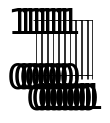

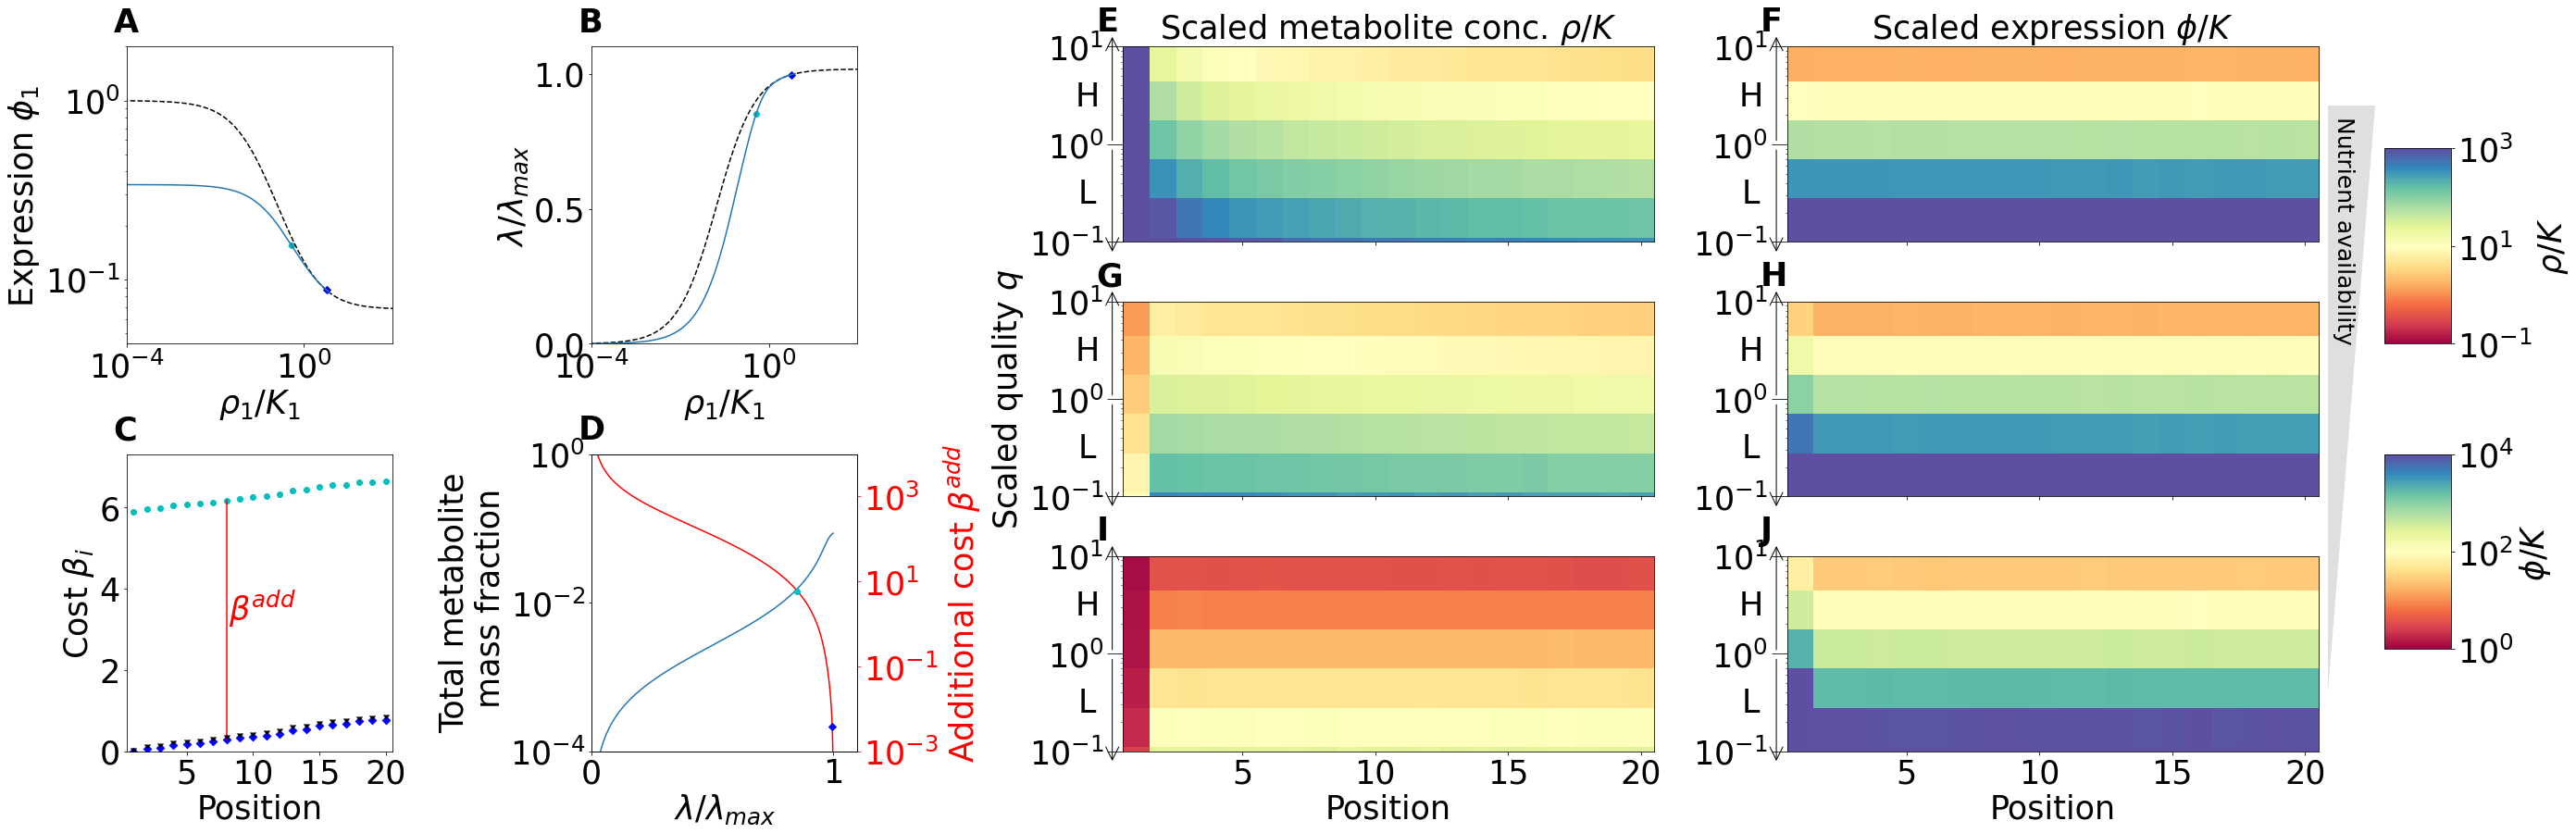

In [915]:
### The role of the nutrient for a single chain
font = {'size'   : 35}
plt.rc('font', **font)

fig, axs =plt.subplots(1, 10, figsize = (1, 1))


fig = plt.figure(figsize = (45, 14))
gs = gridspec.GridSpec(28, 35)
gs.update(wspace=0, hspace=0.5)

axs[0] = plt.subplot(gs[0:12, 0:4])
axs[1] = plt.subplot(gs[0:12, 7:11])
axs[2] = plt.subplot(gs[16:28, 0:4])
axs[3] = plt.subplot(gs[16:28, 7:11])
axs[4] = plt.subplot(gs[0:8, 15:23])
axs[5] = plt.subplot(gs[0:8, 25:33])
axs[6] = plt.subplot(gs[10:18, 15:23])
axs[7] = plt.subplot(gs[10:18, 25:33])
axs[8] = plt.subplot(gs[20:28, 15:23])
axs[9] = plt.subplot(gs[20:28, 25:33])


Nenzymes = 20

kappamean = 130
KMmean = .0001

kappas = fullensemble[0, 0, 0, :]#np.random.lognormal(np.log(kappamean), 3, Nenzymes) #np.ones(Nenzymes)*kappamean #
KMs = fullensemble[0, 0, 1, :]# np.random.lognormal(np.log(KMmean), 2.5, Nenzymes) #np.ones(Nenzymes)*KMmean #
#bs = fullensemble[0, 0, 2, :]#np.ones(Nenzymes)
nu = fullensemble[0, 0, 3, -1]*100#200*KMs[-1] #0.03*KMmean
lamapprox = fullensemble[0, 0, 5, 0]

args = np.array([*kappas, *KMs, nu, lamapprox])
res = minimize(wrapper3, -5, args = args)
rhos = rhoIterator(kappas, KMs, nu, np.exp(res.x[0]))
phis = findPhis(kappas, KMs, rhos)
jouts = calculatejout(rhos, phis, kappas, KMs)

results = []
resultsopt = []
print(res.x[0])
for logrho0 in res.x[0]-np.logspace(-13, 2, 1000):
    rhosC = ConstrainedIterator(kappas, KMs, np.exp(logrho0), phis[-1]/(1+1*5/(1+5*200)), 4)
    phisC = findPhis(kappas, KMs, rhosC)
    #print(phis[-1], phisC[-1])
    joutsC = calculatejout(rhosC, phisC, kappas, KMs)
    results.append([rhosC, phisC, joutsC])
    
    rhosopt = BCIterator(kappas, KMs, np.exp(logrho0))
    phisopt = findPhis(kappas, KMs, rhosopt)
    #print(phis[-1], phisC[-1])
    joutsopt = calculatejout(rhosopt, phisopt, kappas, KMs)
    resultsopt.append([rhosopt, phisopt, joutsopt])
    
    
results = []
print(res.x[0])
for logrho0 in res.x[0]-np.logspace(-13, 2, 1000):#+2.48370e-2:
    rhosC = ConstrainedIterator(kappas, KMs, np.exp(logrho0), phis[-1]/(1+1*5/(1+5*200)), 4)
    phisC = findPhis(kappas, KMs, rhosC)
    #print(phis[-1], phisC[-1])
    joutsC = calculatejout(rhosC, phisC, kappas, KMs)
    results.append([rhosC, phisC, joutsC])

results = np.array(results)
resultsopt = np.array(resultsopt)


i0 = 0
iref = 700
imedium = 870

betaref0 = results[i0, 1, :]/(results[i0, 0, :]*(1+results[i0, 0, :]/KMs))   
betaref0[-1] = 0
betaref = results[iref, 1, :]/(results[iref, 0, :]*(1+results[iref, 0, :]/KMs))   
betaref[-1] = 0
betamedium = results[imedium, 1, :]/(results[imedium, 0, :]*(1+results[imedium, 0, :]/KMs))
betamedium[-1] = betamedium[12]-betaref[12]

axs[2].scatter(np.arange(Nenzymes)[::-1]+1, betaref, marker = "D", c = "b")
axs[2].scatter(np.arange(Nenzymes)[::-1]+1, betamedium, marker = "o", c = "c")
axs[2].plot([Nenzymes-12, Nenzymes-12], [betaref[12], betamedium[12]], "r-")
axs[2].text(Nenzymes-11.8, betaref[12]/2+betamedium[12]/2, r"$\beta^{add}$", color = "r")
#axs[2].set_yscale("log")
axs[2].set_xlim(0.5, Nenzymes+.5)
axs[2].set_ylim(0, 1.1*results[imedium, 1, 0]/(results[imedium, 0, 0]*(1+results[imedium, 0, 0]/KMs[0])))
axs[2].set_xlabel(r"Position")
axs[2].set_xticks([5, 10, 15, 20])
axs[2].set_xticklabels([5, 10, 15, 20])
axs[2].set_ylabel(r"Cost $\beta_i$")
simplebetas = np.cumsum(results[iref, 1, ::-1])[:-1]
simplebetas = np.append(simplebetas[::-1], 0)
axs[2].plot(np.arange(Nenzymes)[::-1]+1, simplebetas, marker = 7, color = "k", linestyle = "none")
#ax1=axs[2].twinx()
#ax1.set_ylim(0, 1.1*results[imedium, 1, 0]/(results[imedium, 0, 0]*(1+results[imedium, 0, 0]/KMs[0])))
#ax1.set_ylabel(r"Cumulative $\Phi = \sum_{k=0}^{i-1} \phi_k$", color = "k")
#ax1.plot(np.arange(Nenzymes)[::-1]+1, simplebetas, marker = 7, color = "k", linestyle = "none")
#ax1.tick_params(axis='y', colors='k')
#ax1.spines['right'].set_color('k')


axs[0].plot(results[iref, 0, -1]/KMs[-1], results[iref, 1, -1], "bD")
axs[0].plot(results[imedium, 0, -1]/KMs[-1], results[imedium, 1, -1], "co")
axs[0].plot(resultsopt[500:, 0, -1]/KMs[-1], resultsopt[500:, 1, -1], "k--")#, label = "optimal expression")
axs[0].plot(results[:, 0, -1]/KMs[-1], results[:, 1, -1])#, label = "constrained expression")
#axs[0].plot(results[:, 0], results[:, 2])
axs[0].set_xscale("log")
#axs[0].set_xlabel(r"Nutrient saturation $\rho_1/K_1$")
axs[0].set_xlabel(r"$\rho_1/K_1$")
axs[0].set_ylabel(r"Expression $\phi_1$")
axs[0].set_yscale("log")
#axs[0].legend(loc = "upper left")
axs[0].set_xlim(1/10000, 100)
axs[0].set_ylim(results[iref, 1, -1]/2, 2)

axs[1].plot(results[iref, 0, -1]/KMs[-1], results[iref, 2, 0]/results[0, 2, 0], "bD")
axs[1].plot(results[imedium, 0, -1]/KMs[-1], results[imedium, 2, 0]/results[0, 2, 0], "co")
axs[1].plot(resultsopt[500:, 0, -1]/KMs[-1], resultsopt[500:, 2, 0]/results[0, 2, 0], "k--")#, label = "optimal expression")
axs[1].plot(results[:, 0, -1]/KMs[-1], results[:, 2, 0]/results[0, 2, 0])#, label = "constrained expression")
axs[1].set_xscale("log")
axs[1].set_ylabel(r"$\lambda/\lambda_{max}$")
#axs[1].set_xlabel(r"Nutrient saturation $\rho_1/K_1$")
axs[1].set_xlabel(r"$\rho_1/K_1$")
axs[1].set_xlim(1/10000, 100)
axs[1].set_ylim(0, 1.1)

axs[3].plot(results[:, 2, 0]/results[0, 2, 0], np.sum(results[:, 0, :], 1)-results[:, 0, -1])
#axs[3].plot(resultsopt[:, 2, 0]/resultsopt[0, 2, 0], np.sum(resultsopt[:, 0, :], 1)-resultsopt[:, 0, -1], "k--")
axs[3].set_yscale("log")
axs[3].set_xlabel(r"$\lambda/\lambda_{max}$")
axs[3].set_ylabel("Total metabolite\n mass fraction")
axs[3].set_xlim(0, 1.1)
axs[3].set_ylim(1e-4, 1e0)

ax2 = axs[3].twinx()
ax2.plot(results[:, 2, 0]/results[0, 2, 0], results[:, 1, 12]/(results[:, 0, 12]*(1+results[:, 0, 12]/KMs[12]))-betaref0[12], "r-")
ax2.set_yscale("log")
#ax2.set_xlabel(r"Growth rate $\lambda$")
ax2.set_ylabel(r"Additional cost $\beta^{add}$", color = "r")
ax2.tick_params(axis='y', colors='r')
#ax2.set_xlim(0, 1.1*np.max(resultsopt[:, 2, 0]))
ax2.set_ylim(1e-3, 1e4)
ax2.plot(results[iref, 2, 0]/results[0, 2, 0], results[iref, 1, 12]/(results[iref, 0, 12]*(1+results[iref, 0, 12]/KMs[12]))-betaref0[12], "bD")
ax2.plot(results[imedium, 2, 0]/results[0, 2, 0], results[imedium, 1, 12]/(results[imedium, 0, 12]*(1+results[imedium, 0, 12]/KMs[12]))-betaref0[12], "co")

fig.tight_layout()
for n, ax in enumerate(axs): 
    if n < 4:
        ax.text(-0.05, 1.05, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')
    else: 
        ax.text(-0.05, 1.08, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')

print(resultsopt[0, 0, :]/KMs)
    
heatmap = axs[4].pcolormesh(x5, y5, z5, cmap = cm, vmin = -1, vmax = 3)
heatmap2 = axs[5].pcolormesh(x6, y6, z6, cmap = cm, vmin = 0, vmax = 4)

heatmap = axs[6].pcolormesh(x9, y9, z9, cmap = cm, vmin = -1, vmax = 3)
heatmap2 = axs[7].pcolormesh(x10, y10, z10, cmap = cm, vmin = 0, vmax = 4)

heatmap = axs[8].pcolormesh(x7, y7, z7, cmap = cm, vmin = -1, vmax = 3)
heatmap2 = axs[9].pcolormesh(x8, y8, z8, cmap = cm, vmin = 0, vmax = 4)
    
for ax in axs.flatten()[4:]:
    ax.set_yscale("log")
    ax.set_ylim(0.1, 10)
    ax.set_xlim(0.5, 20.5)
    ax.set_xticks([5, 10, 15, 20])
    ax.set_xticklabels([])
    #ax.set_xlabel("Position")
    #ax.set_title(r"Expression $\phi/K$")
    ax.yaxis.set_tick_params(which='major', length=17)
    ax.annotate('', xy=(-0.02, -.06), xycoords='axes fraction', xytext=(-0.02, .48), arrowprops=dict(arrowstyle="->", color='k'))
    ax.annotate('', xy=(-0.02, 1.06), xycoords='axes fraction', xytext=(-0.02, .51), arrowprops=dict(arrowstyle="->", color='k'))
    ax.text(-1.3, 2.5, "H")
    ax.text(-1.2, 1/4, "L")

for ax in [axs[6]]:#[axs[4], axs[6], axs[8]]:
    ax.set_ylabel("Scaled quality $q$")
    #ax.set_title(r"Saturation $\rho/K$")

axs[8].set_xlabel("Position")
axs[9].set_xlabel("Position")
axs[8].set_xticklabels([5, 10, 15, 20])
axs[9].set_xticklabels([5, 10, 15, 20])
axs[4].set_title(r"Scaled metabolite conc. $\rho/K$")
axs[5].set_title(r"Scaled expression $\phi/K$")    

axcb = plt.subplot(gs[4:12, 34])
axcb2 = plt.subplot(gs[16:24, 34])

#axcb = plt.subplot(gs[3:5, 5])
#divider = make_axes_locatable(axcb)
#cax = divider.append_axes("top", size="-10%").axis('off')
#cax = divider.append_axes("bottom", size="-10%").axis('off')
#cax = divider.append_axes("left", size="100%", pad=0.05).axis('off')
#cax = divider.append_axes("right", size="200%", pad=0.05).axis('off')
cb = fig.colorbar(heatmap, cax=axcb)#, label = r"$\rho/K$")
axcb.set_yticks([-1, 1, 3])
axcb.set_yticklabels([r"$10^{-1}$", r"$10^{1}$", r"$10^{3}$"])
axcb.set_ylabel(r"$\rho/K$")

#axcb2 = plt.subplot(gs[3:5, 11])
#divider = make_axes_locatable(axcb2)
#cax = divider.append_axes("top", size="-10%").axis('off')
#cax = divider.append_axes("bottom", size="-10%").axis('off')
#cax = divider.append_axes("left", size="100%", pad=0.05).axis('off')
#cax = divider.append_axes("right", size="200%", pad=0.05).axis('off')
fig.colorbar(heatmap2, cax=axcb2)#, label = r"$\phi/K$")
axcb2.set_yticks([0, 2, 4])
axcb2.set_yticklabels([r"$10^{0}$", r"$10^{2}$", r"$10^{4}$"])
axcb2.set_ylabel(r"$\phi/K$") 

axtr = plt.subplot(gs[:, 33])
axtr.add_patch(plt.Polygon([[0,0], [0, 1], [1, 1]],facecolor='silver', clip_on=False, linewidth = 0, alpha = 0.5))
axtr.set_xlim(-0.2, 1.2)
axtr.set_ylim(-0.1, 1.1)
axtr.axis("off")
axtr.text(0.1, 0.6, "Nutrient availability", rotation = 270, fontsize = 25)

plt.savefig("/Users/leonseeger/Dropbox/EffluxPumpsLeon/Draft/CommentingVersion/SI_constraints.pdf", bbox_inches="tight", format = 'pdf')

(5000, 42)
(5000, 1000, 3, 20)
(5000, 500, 6, 20)


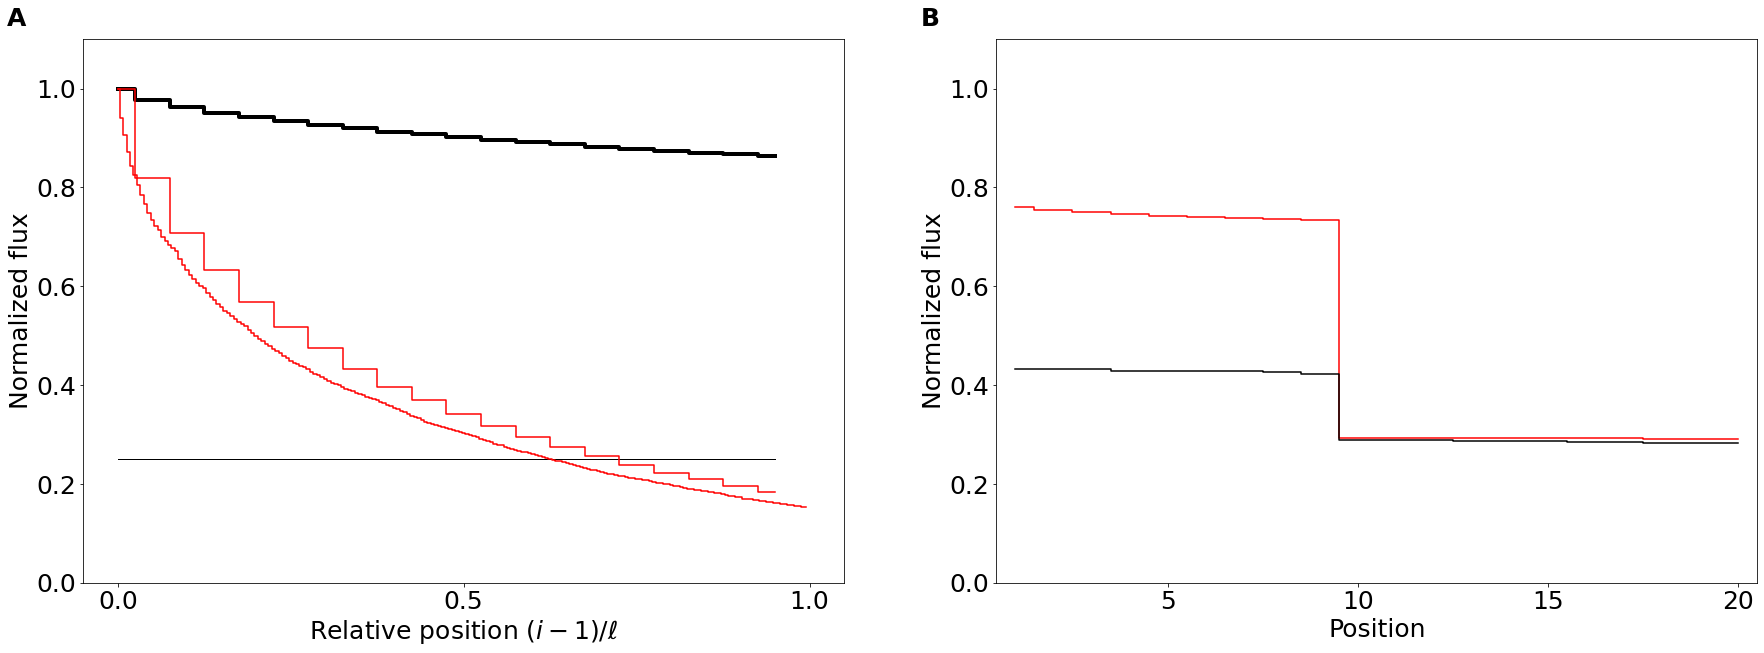

In [917]:
font = {'size'   : 25}
plt.rc('font', **font)
fig, axs = plt.subplots(1, 2, figsize = (30, 10))

filename = "PhysiologicalOptimalBalancedGrowthStates_nutrientLimitation.npy"

fullensemble = np.load(data_folder+filename)
parameters = np.load(data_folder+"physiologicalParameterset.npy")
print(np.shape(parameters))
print(np.shape(fullensemble))

parameterensemble = np.ones(np.shape(fullensemble))
parameterensemble[:, :, 0, :] = np.repeat(parameters[:, None, :Nenzymes], np.shape(fullensemble)[1], axis = 1)
parameterensemble[:, :, 1, :] = np.repeat(parameters[:, None, Nenzymes:2*Nenzymes], np.shape(fullensemble)[1], axis = 1)

fullensemble = np.concatenate((parameterensemble, fullensemble), axis = 2)

fullensemble = fullensemble[~np.isnan(fullensemble[:, 70, 3, -1])]
fullensemble = fullensemble[np.sum(fullensemble[:, 0, 3, :-1], 1)>1e-4]

green = np.min(np.where(np.nanmean((fullensemble[:, :, 5, 0].T/fullensemble[:, 0, 5, 0]), axis = 1)<0.3))

axs[0].step((np.arange(20)[::-1])/20, np.nanmean((fullensemble[:, 0, 5, :].T/fullensemble[:, 0, 5, -1]), axis = 1), where = 'mid', color = "k", linewidth = 4)
axs[0].step((np.arange(20)[::-1])/20, np.nanmean((fullensemble[:, green, 5, :].T/fullensemble[:, 0, 5, -1]), axis = 1), where = 'mid', color = "k", linewidth = 1)

sigma = "kappathird_Monod_veryHighKM"#_thirdkappa"#"phys_true"
filename = "Ensemble_Rich_sigma_%s.npy"%sigma#"Ensemble_Rich_sigma_%s.npy"%sigma

fullensemble = np.load(data_folder+filename)
fullensemble = fullensemble[~np.isnan(fullensemble[:, 70, 3, -1])]
fullensemble = fullensemble[np.sum(fullensemble[:, 0, 3, :-1], 1)>1e-4]

axs[0].step((np.arange(20)[::-1])/20, np.nanmean((fullensemble[:, 0, 5, :].T/fullensemble[:, 0, 5, -1]), axis = 1), where = 'mid', color = "r")#, linewidth = 0.6)

sigma = "kappathird_Monod_veryHighKM_100"#_thirdkappa"#"phys_true"
filename = "Ensemble_Rich_sigma_%s.npy"%sigma#"Ensemble_Rich_sigma_%s.npy"%sigma

fullensemble = np.load(data_folder+filename)
fullensemble = fullensemble[~np.isnan(fullensemble[:, 70, 3, -1])]
fullensemble = fullensemble[np.sum(fullensemble[:, 0, 3, :-1], 1)>1e-4]
#ax0 = plt.twiny(axs[0])
axs[0].step((np.arange(200)[::-1])/200, np.nanmean((fullensemble[:, 0, 5, :].T/fullensemble[:, 0, 5, -1]), axis = 1), where = 'mid', color = "r")#, linewidth = 0.6)


Nenzymes = 20
filename = "AntibioticInhibition_Monod3.npy"#_highKM.npy"
fullensemble = np.load(data_folder+filename)
print(np.shape(fullensemble))

green = np.min(np.where(np.nanmean((fullensemble[:, :, 5, 0].T/fullensemble[:, 0, 5, 0]), axis = 1)<0.3))
axs[1].step(np.arange(20)[::-1]+1, np.nanmean((fullensemble[:, green, 5, :].T/fullensemble[:, 0, 5, 0]), axis = 1), where = 'mid', color = "r")
#axs[1,0].set_title("Avg Antibiotic")

results_Stress = np.load("Stress_response.npy")
#print(np.shape(results_Stress))
green = np.min(np.where((results_Stress[:, 5, 0]/results_Stress[0, 5, 0])<0.285))
axs[1].step(np.arange(20)[::-1]+1, results_Stress[green, 5, :]/results_Stress[0, 5, 0], where = 'mid', color = "k")
#axs[1,2].set_title("One A with Stress")

#ax0.set_xlim(-4, 205)
for ax in axs:
    ax.set_ylim(0, 1.1)
    ax.set_xlim(0.5, 20.5)
    ax.set_xlabel("Position")
    ax.set_xticks([5, 10, 15, 20])
    ax.set_ylabel("Normalized flux")
    
axs[0].set_xlim(-0.05, 1.05)
axs[0].set_xlabel(r"Relative position $(i-1)/\ell$")
axs[0].set_xticks([0, 0.5, 1])
    
for n, ax in enumerate(axs):  
    ax.text(-0.1, 1.024, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')
    
#axs[0].plot(np.arange(20)+1, 1-2*np.sqrt(KMmean*(np.arange(20))))

plt.savefig("/Users/leonseeger/Dropbox/EffluxPumpsLeon/Draft/CommentingVersion/SI_fluxbalance.pdf", bbox_inches="tight", format = 'pdf')

In [936]:
data_folder = "/Users/leonseeger/Desktop/largeDBFiles/"

sigma = "kappathird_Monod"
filename = "Ensemble_Rich_sigma_%s.npy"%sigma

fullensemble = np.load(data_folder+filename)

onechain = fullensemble[0]

def Pproduction(rho, KM, kappa, sumoverkappa, sumKMoverkappa):
    return 1/kappa*(rho+KM)/(rho*sumoverkappa+np.sqrt(KM/kappa)*sumKMoverkappa)

def Rproduction(phi, rho, KM, kappa):
    return kappa*phi/(1+KM/rho)

def iterate(phistart, KMs, kappas, nu, phiUptake):
    sumoverkappa = np.sum(1/kappas)
    sumKMoverkappa = np.sum(np.sqrt(KMs/kappas))
    phis = phistart
    phis = phis/np.sum(phis)
    lam = 0
    rhos = KMs*np.sqrt(phistart/KMs)
    rhos[-1] = nu
    
    dt = 1e-5
    savephis = [phis]
    saverhos = [rhos]
    times = [0]
    steps = np.arange(600000)
    for i in steps:
        fluxes = Rproduction(phis, rhos, KMs, kappas)
        shiftedfluxes = np.append(fluxes[1:], np.zeros(1))
        drhos = -lam*rhos-fluxes+shiftedfluxes
        
        dMs = Pproduction(rhos, KMs, kappas, sumoverkappa, sumKMoverkappa)*(1-phiUptake)
        dMs[-1] = phiUptake
        
        phis += (-lam*phis+lam*dMs/np.sum(dMs))*dt
        phis = phis/np.sum(phis)
        rhos += drhos*dt
        
        lam = fluxes[0]
        rhos[-1] = nu
        rhos[rhos<0] = 1e-15
        if i%100 == 0:
            times.append(dt*steps[i])
            savephis.append(phis)
            saverhos.append(np.copy(rhos))
            
    savephis = np.array(savephis)
    saverhos = np.array(saverhos)
    
    #fig, axs = plt.subplots(1, 2, figsize = (15, 5))
    allrhos = np.logspace(-3, 3, 100)
    productions = []
    
    for rho in allrhos:
        productions.append(Pproduction(rho*KMs, KMs, kappas, sumoverkappa, sumKMoverkappa))
    productions = np.array(productions)
    
    return times, saverhos, savephis, allrhos, productions[:, 0]/productions[-1, 0], rhos, phis, fluxes

richref = onechain[0]
kappas = richref[0]
KMs = richref[1]
phistart = richref[4]*np.random.lognormal(0, 2, 20)
nu = richref[3, -1]
phimin = richref[4, -1]
phimax = 5*phimin/(1+(5-1)*phimin)
phiUptake = (1/phimax+(1/phimin-1/phimax)*nu/(nu+KMs[-1]))**(-1)


times, saverhos, savephis, allrhos, normproductions, rhos, phis, fluxes = iterate(phistart, KMs, kappas, nu, phiUptake)

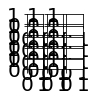

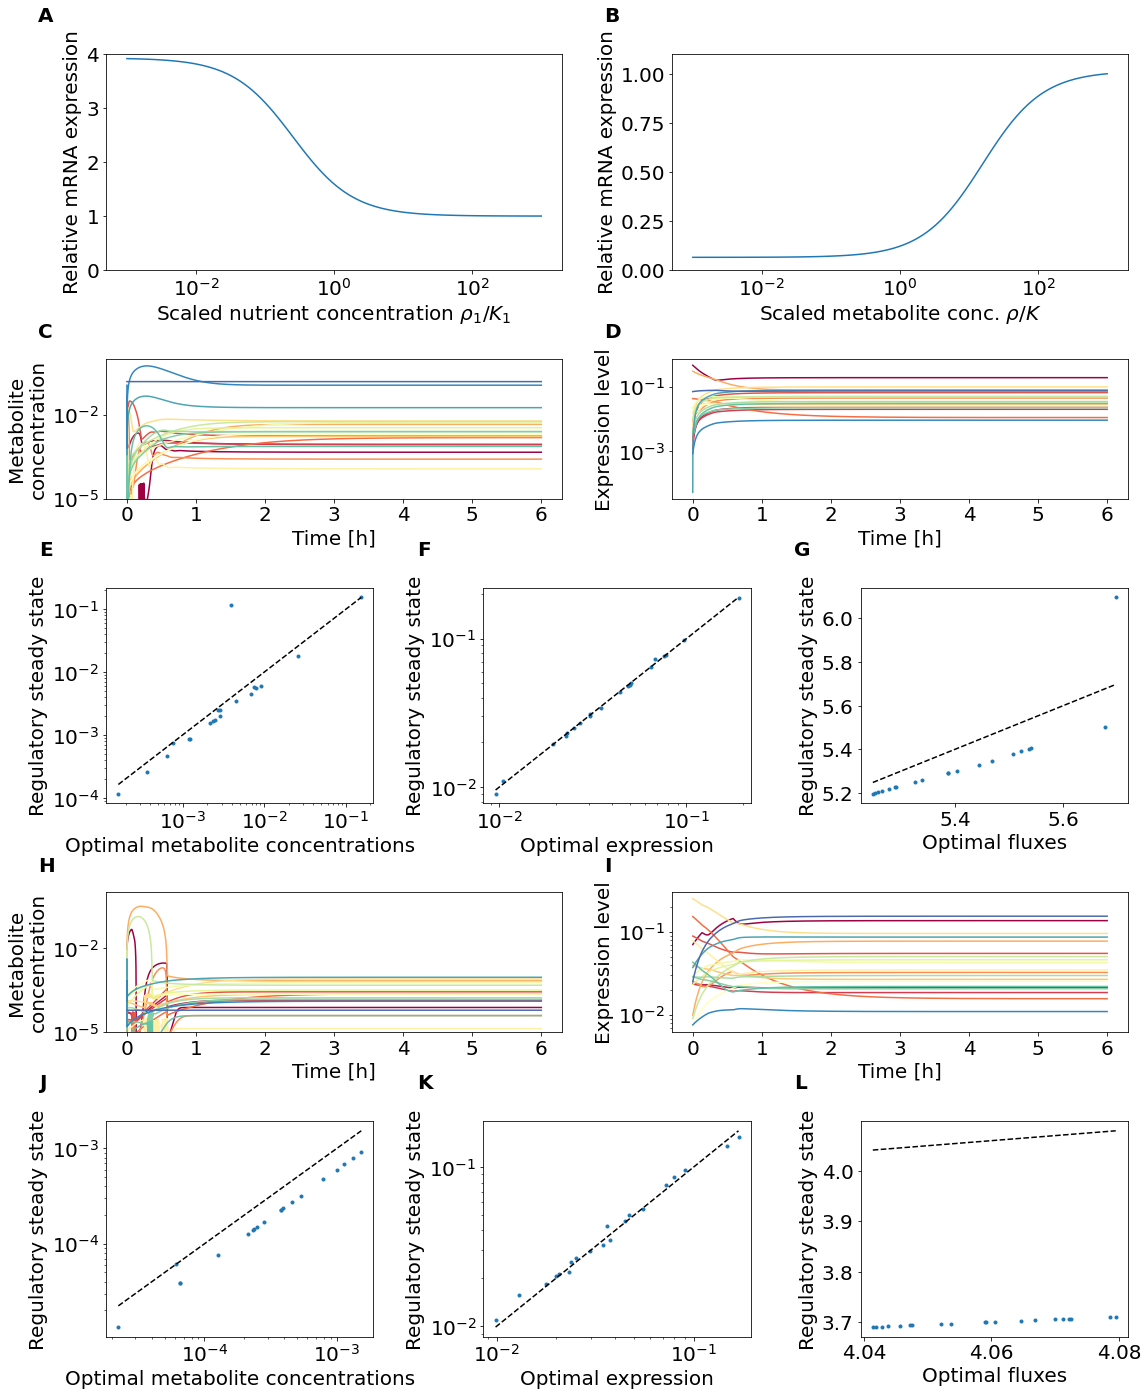

In [935]:
richref = onechain[0]
kappas = richref[0]
KMs = richref[1]
phistart = richref[4]*np.random.lognormal(0, 2, 20)
nu = richref[3, -1]
phimin = richref[4, -1]
phimax = 5*phimin/(1+(5-1)*phimin)
phiUptake = (1/phimax+(1/phimin-1/phimax)*nu/(nu+KMs[-1]))**(-1)

times, saverhos, savephis, allrhos, normproductions, rhos, phis, fluxes = iterate(phistart, KMs, kappas, nu, phiUptake)


font = {'size'   : 20}
plt.rc('font', **font)
dt = 1e-5
fig, axs = plt.subplots(5, 3, figsize = (1, 1))
fig = plt.figure(figsize = (20, 25))
gs = gridspec.GridSpec(18, 12)
#gs.update(wspace=0, hspace=0.15)
axs[0, 0] = plt.subplot(gs[0:3, 1:6])
axs[0, 1] = plt.subplot(gs[0:3, 7:])
axs[1, 0] = plt.subplot(gs[4:6, 1:6])
axs[1, 1] = plt.subplot(gs[4:6, 7:])
axs[2, 0] = plt.subplot(gs[7:10, 1:4])
axs[2, 1] = plt.subplot(gs[7:10, 5:8])
axs[2, 2] = plt.subplot(gs[7:10, 9:])
axs[3, 0] = plt.subplot(gs[11:13, 1:6])
axs[3, 1] = plt.subplot(gs[11:13, 7:])
axs[4, 0] = plt.subplot(gs[14:17, 1:4])
axs[4, 1] = plt.subplot(gs[14:17, 5:8])
axs[4, 2] = plt.subplot(gs[14:17, 9:])


allnus = np.logspace(-3, 3, 100)
productions = []
for rho in allnus:
    nu = rho*KMs[-1]
    productions.append((1/phimax+(1/phimin-1/phimax)*nu/(nu+KMs[-1]))**(-1))
productions = np.array(productions)
axs[0, 0].plot(allnus, productions/productions[-1])
axs[0, 0].set_xscale("log")
axs[0, 0].set_xlabel(r"Scaled nutrient concentration $\rho_1/K_1$")
axs[0, 0].set_ylabel("Relative mRNA expression")
axs[0, 0].set_ylim(0,4)

axs[0, 1].plot(allrhos, normproductions)
axs[0, 1].set_xscale("log")
axs[0, 1].set_xlabel(r"Scaled metabolite conc. $\rho/K$")
axs[0, 1].set_ylabel("Relative mRNA expression")
axs[0, 1].set_ylim(0,1.1)

for q in range(20):
    axs[1, 1].plot(times, savephis[:, q], color = cm(q/20))
    axs[1, 1].set_xlabel("Time [h]")
    axs[1, 1].set_ylabel("Expression level")
    axs[1, 1].set_yscale("log")
    axs[1, 0].plot(times, saverhos[:, q], color = cm(q/20))
    axs[1, 0].set_ylim(dt, 1)
    axs[1, 0].plot(times, -saverhos, "--")
    axs[1, 0].set_xlabel("Time [h]")
    axs[1, 0].set_ylabel("Metabolite\nconcentration")
    axs[1, 0].set_yscale("log")
    
    
axs[2, 0].plot(richref[3], rhos, ".")
#axs[2, 0].plot(richref[3], KMs*np.sqrt(phistart/KMs), ".")
axs[2, 0].plot(np.linspace(np.min(richref[3]), np.max(richref[3]), 10), np.linspace(np.min(richref[3]), np.max(richref[3]), 10), "k--")
axs[2, 0].set_xscale("log")
axs[2, 0].set_yscale("log")
axs[2, 0].set_xlabel("Optimal metabolite concentrations")
axs[2, 0].set_ylabel("Regulatory steady state")

axs[2, 1].plot(richref[4], phis, ".")
#axs[2, 1].plot(richref[4], phistart, ".")
axs[2, 1].plot(np.linspace(np.min(richref[4]), np.max(richref[4]), 10), np.linspace(np.min(richref[4]), np.max(richref[4]), 10), "k--")
axs[2, 1].set_xscale("log")
axs[2, 1].set_yscale("log")
axs[2, 1].set_xlabel("Optimal expression")
axs[2, 1].set_ylabel("Regulatory steady state")

axs[2, 2].plot(richref[5], fluxes, ".")
#axs[2, 2].plot(kappas*phistart/(1+1/np.sqrt(phistart/KMs)), richref[5], ".")
axs[2, 2].plot(np.linspace(np.min(richref[5]), np.max(richref[5]), 10), np.linspace(np.min(richref[5]), np.max(richref[5]), 10), "k--")
axs[2, 2].set_xlabel("Optimal fluxes")
axs[2, 2].set_ylabel("Regulatory steady state")



richref = onechain[0]
ref = onechain[80]
kappas = richref[0]
KMs = richref[1]
phistart = richref[4]*np.random.lognormal(0, 1, 20)*ref[5, 0]/richref[5, 0]

nu = ref[3, -1]
phimin = richref[4, -1]
phimax = 5*phimin/(1+(5-1)*phimin)
phiUptake = (1/phimax+(1/phimin-1/phimax)*nu/(nu+KMs[-1]))**(-1)

#print(richref[3], richref[4], richref[5])
times, saverhos, savephis, allrhos, normproductions, rhos, phis, fluxes = iterate(phistart, KMs, kappas, nu, phiUptake)

for q in range(20):
    axs[3, 1].plot(times, savephis[:, q], color = cm(q/20))
    axs[3, 1].set_xlabel("Time [h]")
    axs[3, 1].set_ylabel("Expression level")
    axs[3, 1].set_yscale("log")
    axs[3, 0].plot(times, saverhos[:, q], color = cm(q/20))
    axs[3, 0].set_ylim(dt, 1)
    axs[3, 0].plot(times, -saverhos, "--")
    axs[3, 0].set_xlabel("Time [h]")
    axs[3, 0].set_ylabel("Metabolite\nconcentration")
    axs[3, 0].set_yscale("log")
    
    
axs[4, 0].plot(ref[3], rhos, ".")
#axs[4, 0].plot(richref[3], KMs*np.sqrt(phistart/KMs), ".")
axs[4, 0].plot(np.linspace(np.min(ref[3]), np.max(ref[3]), 10), np.linspace(np.min(ref[3]), np.max(ref[3]), 10), "k--")
axs[4, 0].set_xscale("log")
axs[4, 0].set_yscale("log")
axs[4, 0].set_xlabel("Optimal metabolite concentrations")
axs[4, 0].set_ylabel("Regulatory steady state")

axs[4, 1].plot(ref[4], phis, ".")
#axs[4, 1].plot(richref[4], phistart, ".")
axs[4, 1].plot(np.linspace(np.min(ref[4]), np.max(ref[4]), 10), np.linspace(np.min(ref[4]), np.max(ref[4]), 10), "k--")
axs[4, 1].set_xscale("log")
axs[4, 1].set_yscale("log")
axs[4, 1].set_xlabel("Optimal expression")
axs[4, 1].set_ylabel("Regulatory steady state")

axs[4, 2].plot(ref[5], fluxes, ".")
#axs[4, 2].plot(kappas*phistart/(1+1/np.sqrt(phistart/KMs)), richref[5], ".")
axs[4, 2].plot(np.linspace(np.min(ref[5]), np.max(ref[5]), 10), np.linspace(np.min(ref[5]), np.max(ref[5]), 10), "k--")
axs[4, 2].set_xlabel("Optimal fluxes")
axs[4, 2].set_ylabel("Regulatory steady state")

for n, ax in enumerate([axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1], axs[2, 0], axs[2, 1], axs[2, 2], axs[3, 0], axs[3, 1], axs[4, 0], axs[4, 1], axs[4, 2]]):  
    if n in [0, 1, 2, 3, 7, 8]:
        ax.text(-0.15, 1.15, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')
    else:
        ax.text(-0.25, 1.15, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')
#plt.savefig("/Users/leonseeger/Dropbox/EffluxPumpsLeon/Draft/CommentingVersion/SI_regulation.pdf", bbox_inches="tight", format = 'pdf')

In [444]:
def makegrid(Branched = False):
    fig, axs = plt.subplots(8+Branched, 2, figsize = (1, 1))
    for ax in axs.flatten():
        ax.axis("off")
    
    fig = plt.figure(figsize = (25, 31))
    gs = gridspec.GridSpec(25, 14)
    gs.update(wspace=0, hspace=0.15)

    #axs[0, 0] = plt.subplot(gs[3:5, 0:4])
    #axs[0, 1] = plt.subplot(gs[3:5, 7:11])
    #axs[1, 0] = plt.subplot(gs[6:10, 0:4])
    #axs[1, 1] = plt.subplot(gs[6:10, 7:11])
    #axs[2, 0] = plt.subplot(gs[11:15, 0:4])
    #axs[2, 1] = plt.subplot(gs[11:15, 7:11])
    #axs[3, 0] = plt.subplot(gs[16:21, 0:2])
    #axs[3, 1] = plt.subplot(gs[16:21, 2:4])
    #axs[3, 0] = plt.subplot(gs[18:21, :2])
    #axs[3, 1] = plt.subplot(gs[18:21, 3:5])
    #axs[4+Branched, 0] = plt.subplot(gs[17:21, 7:11])
    
    axs[0, 0] = plt.subplot(gs[7:9, 1:5])
    axs[0, 1] = plt.subplot(gs[7:9, 7:11])
    axs[1, 0] = plt.subplot(gs[10:14, 1:5])
    axs[1, 1] = plt.subplot(gs[10:14, 7:11])
    axs[2, 0] = plt.subplot(gs[15:19, 1:5])
    axs[2, 1] = plt.subplot(gs[15:19, 7:11])
    #axs[3, 0] = plt.subplot(gs[16:21, 0:2])
    #axs[3, 1] = plt.subplot(gs[16:21, 2:4])
    axs[3, 0] = plt.subplot(gs[21:25, :2])
    axs[3, 1] = plt.subplot(gs[21:25, 3:5])
    axs[4+Branched, 0] = plt.subplot(gs[20:24, 7:11])
    
    if Branched:
        axs[4, 0] = plt.subplot(gs[4:6, 1:3])
        axs[4, 1] = plt.subplot(gs[4:6, 7:9])
        
        axs[7, 0] = plt.subplot(gs[0:4, 1:11])
        axs[7, 0].axis("off")

    for ax in axs.flatten():
        ax.set_xlim(0.5, 20.5)
        ax.set_xlabel("Position")

    axs[0, 0].set_ylim(1e-1, 1e1)
    axs[0, 1].set_ylim(1e-1, 1e1)
    
    axs[1, 0].set_ylim(1e-1, 1e5)
    axs[1, 1].set_ylim(1e1, 1.5e4)
    #axs[1, 1].set_ylim(1e0, 1e4)
    axs[1, 0].add_patch(plt.Polygon([[0.5, 1e-3], [0.5, 1e5], [1.3, 1e5], [1.3, 1e-3]],facecolor='silver', clip_on=True, linewidth = 0, alpha = 0.5))
    #axs[1, 0].add_patch(plt.Polygon([[0.5, 1e-1], [0.5, 1e4], [1.3, 1e4], [1.3, 1e-1]],facecolor='silver', clip_on=False, linewidth = 0, alpha = 0.5))
    axs[1, 1].add_patch(plt.Polygon([[0.5, 1e-1], [0.5, 1.5e4], [.8, 1.5e4], [.8, 1e-1]],facecolor='silver', clip_on=True, linewidth = 0, alpha = 0.5))
    #axs[1, 1].add_patch(plt.Polygon([[0.5, 1e0], [0.5, 1e4], [.8, 1e4], [.8, 1e0]],facecolor='silver', clip_on=False, linewidth = 0, alpha = 0.5))


    axs[0, 0].set_yscale("log")
    axs[0, 1].set_yscale("log")
    axs[1, 0].set_yscale("log")
    axs[1, 1].set_yscale("log")
    
    axs[0, 0].set_ylabel(r"                             Scaled quality $q$")
    #axs[0, 1].set_ylabel(r"Quality $Q$")
    axs[1, 0].set_ylabel(r"Scaled metabolite conc. $\rho/K$")
    axs[1, 1].set_ylabel(r"Scaled expression $\phi/K$")
    
    axs[0, 0].yaxis.set_tick_params(which='major', length=17)
    axs[0, 0].annotate('', xy=(-0.02, -.06), xycoords='axes fraction', xytext=(-0.02, .48), arrowprops=dict(arrowstyle="->", color='k'))
    axs[0, 0].annotate('', xy=(-0.02, 1.06), xycoords='axes fraction', xytext=(-0.02, .51), arrowprops=dict(arrowstyle="->", color='k'))
    axs[0, 0].text(-1.3, 2.5, "H")
    axs[0, 0].text(-1.2, 1/4, "L")
    axs[0, 1].yaxis.set_tick_params(which='major', length=17)
    axs[0, 1].annotate('', xy=(-0.02, -.06), xycoords='axes fraction', xytext=(-0.02, .48), arrowprops=dict(arrowstyle="->", color='k'))
    axs[0, 1].annotate('', xy=(-0.02, 1.06), xycoords='axes fraction', xytext=(-0.02, .51), arrowprops=dict(arrowstyle="->", color='k'))
    axs[0, 1].text(-1.3, 2.5, "H")
    axs[0, 1].text(-1.2, 1/4, "L")

    axs[2, 0].set_ylim(0, 1.5)
    axs[2, 0].set_ylabel("Relative flux")
    axs[2, 0].add_patch(plt.Polygon([[0.5, 0], [0.5, 1.5], [.8, 1.5], [.8, 0]],facecolor='silver', clip_on=False, linewidth = 0, alpha = 0.5))

    axs[2, 1].set_xlabel(r"$j/\lambda_{max}$")
    axs[2, 1].set_ylim(0, 4)
    axs[2, 1].set_xlim(0, 1.1)
    axs[2, 1].set_xlabel(r"$\lambda/\lambda_{max}$")
    axs[2, 1].set_ylabel(r"$\phi(\lambda)/\phi(\lambda_{max})$")

    axs[3, 0].axis("off")
    axs[3, 1].axis("off")
    
    if Branched:
        for q in range(2):
            axs[4, q].set_ylim(1e-1, 1e1)
            axs[4, q].set_yscale("log")
            axs[4, q].set_xlim(0.5, 10.5)
            #axs[4, q].set_ylabel(r"Quality $Q$")
            axs[4, q].annotate('', xy=(1, -.7), xycoords='axes fraction', xytext=(1, 0), arrowprops=dict(arrowstyle="-|>", color='k'))

            axs[4, q].yaxis.set_tick_params(which='major', length=17)
            axs[4, q].annotate('', xy=(-0.04, -.06), xycoords='axes fraction', xytext=(-0.04, .48), arrowprops=dict(arrowstyle="->", color='k'))
            axs[4, q].annotate('', xy=(-0.04, 1.06), xycoords='axes fraction', xytext=(-0.04, .51), arrowprops=dict(arrowstyle="->", color='k'))
            axs[4, q].text(-1.3, 2.5, "H")
            axs[4, q].text(-1.2, 1/4, "L")
            
        #axs[4, 0].set_ylabel(r"Scaled quality $q$")
    cm = plt.cm.get_cmap('RdYlGn')
    
    return fig, axs, gs

#fig, axs, gs = makegrid(Branched = True)

[3.1475596  3.11584849 2.98785201 2.83196947 2.20328718 1.57569244
 0.94427968 0.31475702 0.15737787 0.03147569]
(5000, 3, 6, 3, 10)
[ 8.43119389 11.4477007  12.759859    6.3425433   7.45475155  9.18274733
 11.48731861  6.43606513  6.77604296  3.41984645] [15.84404038 21.20465474 19.92498366 16.89299135 16.50998344 20.09810118
 20.28924868 17.24420649 18.76003376 16.89695529]
(5000, 3, 10)
(5000, 3, 6, 3, 10)
(5000, 3, 10)
a 0 0 0
a 0 1 0
(4928, 100, 6, 10)
(4928, 3, 6, 1, 10)
(4928, 1, 10)
[0.50399534 1.31830923 1.5441619  0.25228418 0.79297881 0.69034426
 1.05346653 2.00746956 0.84950215 0.59735387]
1.048448281859614


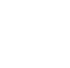

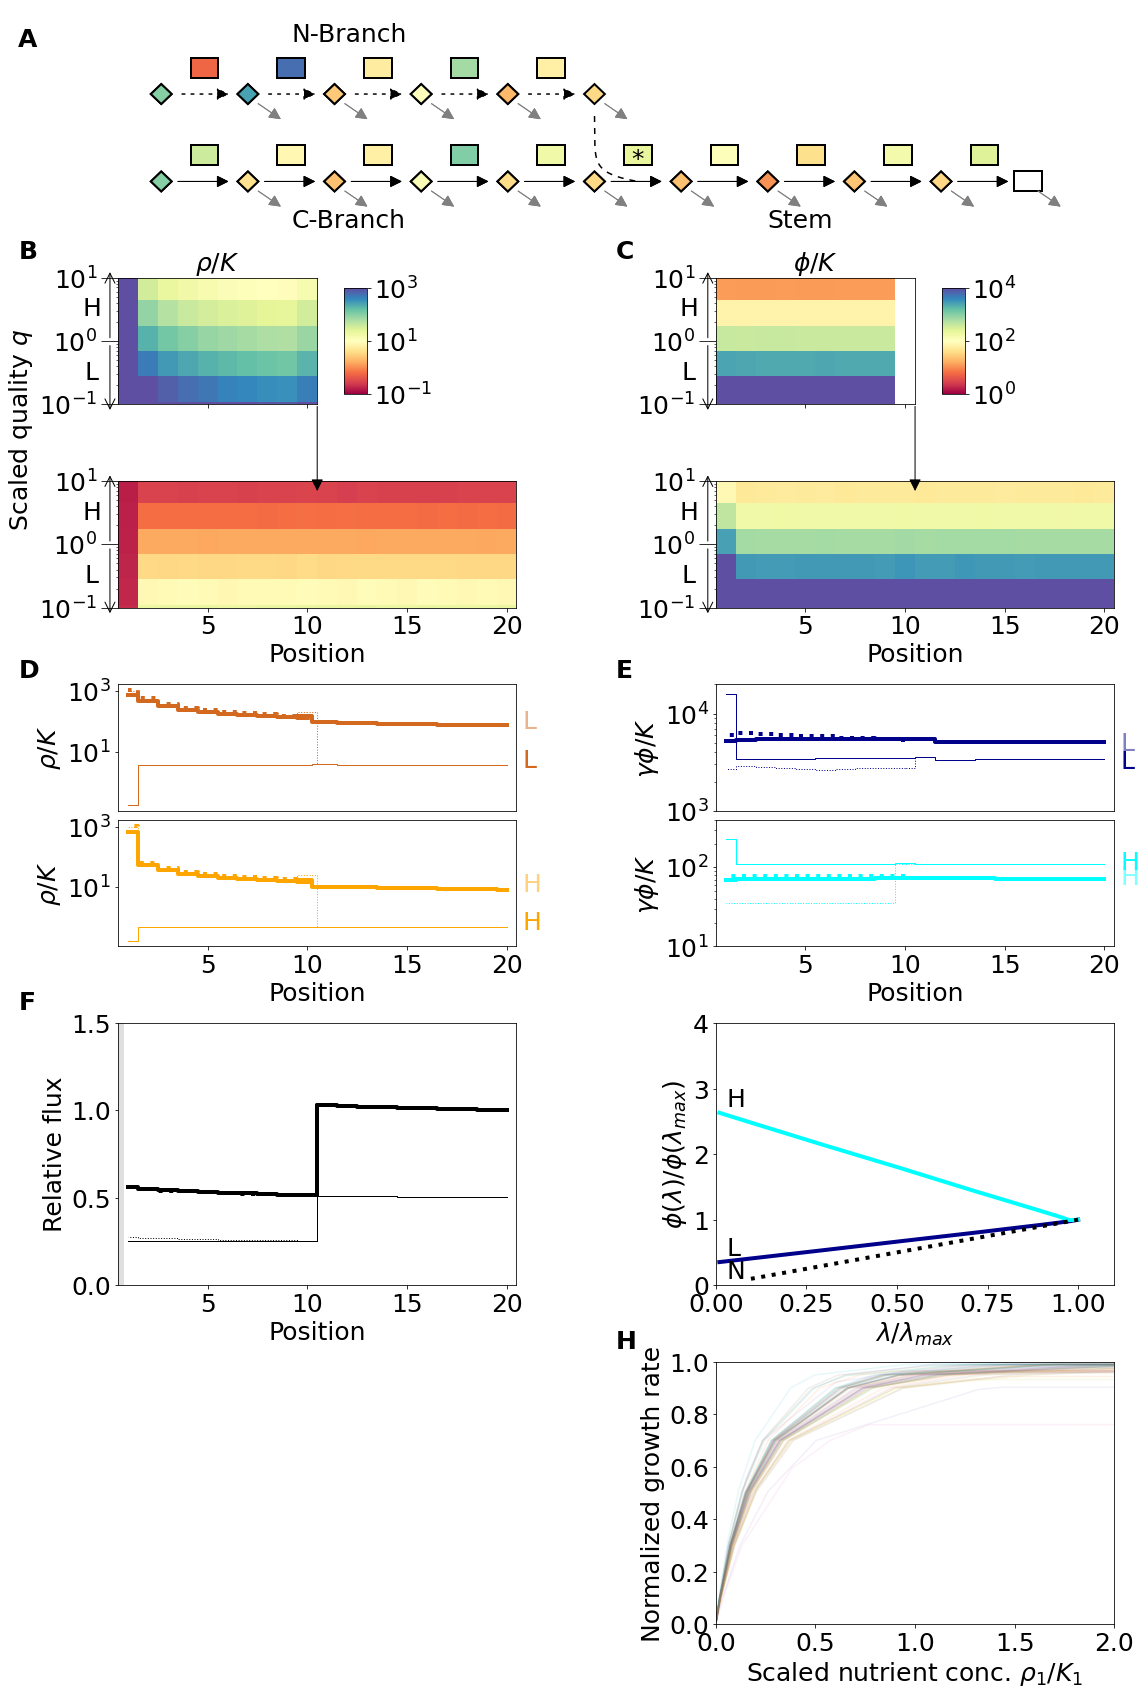

In [872]:
#### Branched Chain

fig, axs, gs = makegrid(Branched = True)

font = {'size'   : 25}
plt.rc('font', **font)
Nenzymes = 10

#before #realization, nutrient, type, position
#iter, gr, type, branch, pos
ConstrainedResultsArray = np.load("ConstrainedYChain_10grs_Monod.npy")

saveargsYArray = np.load("ConstrainedYChainParameters_10grs_Monod.npy")
#iter, branch, [kappas, KMs, bs, ..]
KMmean = np.exp(np.mean(np.log(saveargsYArray[:, :, Nenzymes:2*Nenzymes])))

kappas = np.repeat(saveargsYArray[:, None, None, :, :Nenzymes], 10, axis=1)
KMs = np.repeat(saveargsYArray[:, None, None, :, Nenzymes:2*Nenzymes], 10, axis=1)
bs = np.repeat(saveargsYArray[:, None, None, :, 2*Nenzymes:3*Nenzymes], 10, axis=1)

params = np.concatenate((kappas, KMs, bs), axis = 2)

fullensemble = ConstrainedResultsArray
fullensemble = np.concatenate((params, fullensemble), axis = 2)
print(fullensemble[0, :, 5, 0, 0])
ensemble=fullensemble[:, [0, 5, 7]]
print(np.shape(ensemble))

### calculate efficiencies based on the whole network
Normalization_old = np.sum(saveargsYArray[:, :, :Nenzymes]**(-1), (1, 2))/np.sum(np.sqrt(saveargsYArray[:, :, Nenzymes:2*Nenzymes]/saveargsYArray[:, :, :Nenzymes]), (1, 2))
Normalization = np.sqrt(1/fullensemble[:, 0, 5, 0, 0]/KMmean/20)
print(Normalization_old[:10], Normalization[:10])
efficiencies = (Normalization * np.sqrt(saveargsYArray[:, :, Nenzymes:2*Nenzymes]*saveargsYArray[:, :, :Nenzymes]).T).T
print(np.shape(efficiencies))

efficiencybins = np.logspace(-1.4, 1.4, 8)

print(np.shape(ensemble))

ensemble[:, :, 3, 1, -1] = ensemble[:, :, 1, 1, -1]*1000
print(np.shape(efficiencies))

colormeshrho = np.zeros((2*Nenzymes, np.shape(efficiencybins)[0]-1))
colormeshphi = np.zeros((2*Nenzymes, np.shape(efficiencybins)[0]-1))
colormeshrhoN = np.zeros((Nenzymes, np.shape(efficiencybins)[0]-1))
colormeshphiN = np.zeros((Nenzymes, np.shape(efficiencybins)[0]-1))

gr = 1

branch = 0
for i in range(np.shape(efficiencybins)[0]-1):
    mask = (efficiencies[:, branch, :]>efficiencybins[i])*(efficiencies[:, branch, :]<=efficiencybins[i+1])
    fullmask = mask[:, None, None, :]*np.ones((np.shape(ensemble)[1], np.shape(ensemble)[2]))[None, :, :, None]
    maskeddata = np.where(fullmask, ensemble[:, :, :, branch, :], np.nan)
    logsaturation = np.log10(maskeddata[:, gr, 3, :]/maskeddata[:, 0, 1, :])
    logexpression = np.log10(maskeddata[:, gr, 4, :]/maskeddata[:, 0, 1, :])
    colormeshrho[:Nenzymes, i] = np.nanmean(logsaturation, 0)
    colormeshphi[:Nenzymes, i] = np.nanmean(logexpression, 0)
    
branch = 2
for i in range(np.shape(efficiencybins)[0]-1):
    mask = (efficiencies[:, branch, :]>efficiencybins[i])*(efficiencies[:, branch, :]<=efficiencybins[i+1])
    fullmask = mask[:, None, None, :]*np.ones((np.shape(ensemble)[1], np.shape(ensemble)[2]))[None, :, :, None]
    maskeddata = np.where(fullmask, ensemble[:, :, :, branch, :], np.nan)
    logsaturation = np.log10(maskeddata[:, gr, 3, :]/maskeddata[:, 0, 1, :])
    logexpression = np.log10(maskeddata[:, gr, 4, :]/maskeddata[:, 0, 1, :])
    colormeshrho[Nenzymes:, i] = np.nanmean(logsaturation, 0)
    colormeshphi[Nenzymes:, i] = np.nanmean(logexpression, 0)
    
branch = 1
for i in range(np.shape(efficiencybins)[0]-1):
    mask = (efficiencies[:, branch, :]>efficiencybins[i])*(efficiencies[:, branch, :]<=efficiencybins[i+1])
    fullmask = mask[:, None, None, :]*np.ones((np.shape(ensemble)[1], np.shape(ensemble)[2]))[None, :, :, None]
    maskeddata = np.where(fullmask, ensemble[:, :, :, branch, :], np.nan)
    logsaturation = np.log10(maskeddata[:, gr, 3, :]/maskeddata[:, 0, 1, :])
    logexpression = np.log10(maskeddata[:, gr, 4, :]/maskeddata[:, 0, 1, :])
    colormeshrhoN[:, i] = np.nanmean(logsaturation, 0)
    colormeshphiN[:, i] = np.nanmean(logexpression, 0)
    
    
heatmap = axs[0, 0].pcolormesh(np.arange(2*Nenzymes)[::-1]+1, np.sqrt(efficiencybins[1:]*efficiencybins[:-1]), colormeshrho.T, cmap = cm, vmin = -1, vmax = 3)
heatmap2 = axs[0, 1].pcolormesh(np.arange(2*Nenzymes)[::-1]+1, np.sqrt(efficiencybins[1:]*efficiencybins[:-1]), colormeshphi.T, cmap = cm, vmin = 0, vmax = 4)
#axs[0, 0].set_title(r'$\rho/K$')
#axs[0, 1].set_title(r'$\phi/K$')

heatmapN = axs[4, 0].pcolormesh(np.arange(Nenzymes)[::-1]+1, np.sqrt(efficiencybins[1:]*efficiencybins[:-1]), colormeshrhoN.T, cmap = cm, vmin = -1, vmax = 3)
axs[4, 1].pcolormesh(np.arange(Nenzymes)[::-1]+1, np.sqrt(efficiencybins[1:]*efficiencybins[:-1]), colormeshphiN.T, cmap = cm, vmin = 0, vmax = 4)
axs[4, 0].set_title(r'$\rho/K$')
axs[4, 1].set_title(r'$\phi/K$')
axs[4, 0].set_xlabel("")
axs[4, 1].set_xlabel("")
axs[4, 0].set_xticklabels([])
axs[4, 1].set_xticklabels([])

axcb = plt.subplot(gs[4:6, 3])
divider = make_axes_locatable(axcb)
cax = divider.append_axes("top", size="-10%").axis('off')
cax = divider.append_axes("bottom", size="-10%").axis('off')
cax = divider.append_axes("left", size="100%", pad=0.05).axis('off')
cax = divider.append_axes("right", size="200%", pad=0.05).axis('off')
cb = fig.colorbar(heatmap, cax=axcb)#, label = r"$\rho/K$")
axcb.set_yticks([-1, 1, 3])
axcb.set_yticklabels([r"$10^{-1}$", r"$10^{1}$", r"$10^{3}$"])

axcb2 = plt.subplot(gs[4:6, 9])
divider = make_axes_locatable(axcb2)
cax = divider.append_axes("top", size="-10%").axis('off')
cax = divider.append_axes("bottom", size="-10%").axis('off')
cax = divider.append_axes("left", size="100%", pad=0.05).axis('off')
cax = divider.append_axes("right", size="200%", pad=0.05).axis('off')
fig.colorbar(heatmap2, cax=axcb2)#, label = r"$\phi/K$")
axcb2.set_yticks([0, 2, 4])
axcb2.set_yticklabels([r"$10^{0}$", r"$10^{2}$", r"$10^{4}$"])

yshifts = np.array([[-0.08, 0], [-0.08, 0]])
linewidths = [4, 1]
linestyles = ["-", ":"]
colors = np.array([["chocolate", "chocolate"], ["orange", "orange"]])
#colors = np.array([["k", "chocolate"], ["dimgrey", "orange"]])
colorsPhi = np.array([["darkblue", "darkblue"], ["cyan", "cyan"]])
#colorsPhi = np.array([["k", "darkblue"], ["dimgrey", "cyan"]])
meancolors = ["k", "dimgrey"]
effs = ["L", "H"]
effcolors = ["darkblue", "cyan"]

axs[1, 0] = plt.subplot(gs[10:12, 1:5])
axs[1, 1] = plt.subplot(gs[10:12, 7:11])

axs[6, 0] = plt.subplot(gs[12:14, 1:5])
axs[6, 1] = plt.subplot(gs[12:14, 7:11])

for gr in range(2):
    meanN = np.nanmean(np.log10(ensemble[:, :, 4, 0, :]/ensemble[:, :, 1, 0, :]))
    stdN = np.nanstd(np.log10(ensemble[:, :, 4, 0, :]/ensemble[:, :, 1, 0, :]))
    
    efficiencybins = np.logspace(-5, 5, 3)
    meanNs = []
    stdNs = []
    meanNs2 = []
    stdNs2 = []
    piefractions = []
    
    for branch in [0, 2, 1]:
        for i in range(np.shape(efficiencybins)[0]-1):
            #if i%6==3:
            mask = (efficiencies[:, branch, :]>efficiencybins[i])*(efficiencies[:, branch, :]<=efficiencybins[i+1])
            fullmask = mask[:, None, None, :]*np.ones((np.shape(ensemble)[1], np.shape(ensemble)[2]))[None, :, :, None]
            maskeddata = np.where(fullmask, ensemble[:, :, :, branch, :], np.nan)
            logsaturation = np.log10(maskeddata[:, gr, 3, :]/maskeddata[:, 0, 1, :])
            logexpression = np.log10(maskeddata[:, gr, 4, :]/maskeddata[:, 0, 1, :])
            meanNs.append(10**np.nanmean(logsaturation, 0))
            stdNs.append(10**np.nanstd(logsaturation, 0))
            meanNs2.append(10**(np.nanmean(logexpression, 0)))
            stdNs2.append(10**(np.nanstd(logexpression, 0)))
            
            if branch == 1:
                meanNs2[-1][0] = saveold[0][i][0]
                stdNs2[-1][0] = saveold[1][i][0]
            
    
            axs[1+5*i, 0].step(np.arange(Nenzymes)[::-1]+1+Nenzymes*(branch==0), filtered(meanNs[-1])*np.exp((yshifts[i, gr]*(1-2*(branch==1)))*(branch!=0)), colors[i][gr], linewidth = linewidths[gr], where = "mid", linestyle = linestyles[branch%2])
            axs[1+5*i, 1].step(np.arange(Nenzymes)[::-1]+1+Nenzymes*(branch==0), filtered(meanNs2[-1])*np.exp((-yshifts[i, gr]*(branch==1))), colorsPhi[i][gr], linewidth = linewidths[gr], where = "mid", linestyle = linestyles[branch%2])

            if branch == 0:
                axs[1+5*i, 0].text(20.8, meanNs[-1][0]/1.2, effs[i], color = colors[i][gr], alpha = 1/2+gr/2)
                axs[1+5*i, 1].text(20.8, meanNs2[-1][0]/1.2, effs[i], color = colorsPhi[i][gr], alpha = 1/2+gr/2)

            
            
            if branch != 1:
                
                mask = (efficiencies[:, branch, :]>efficiencybins[i])*(efficiencies[:, branch, :]<=efficiencybins[i+1])
                fullmask = mask[:, None, None, :]*np.ones((np.shape(fullensemble)[1], np.shape(fullensemble)[2]))[None, :, :, None]
                maskeddata = np.where(fullmask, fullensemble[:, :, :, branch, :], np.nan)
                if branch == 0 and gr == 0:
                    print("a", branch, i, gr)
                    axs[2, 1].text(0.03, np.nanmean(maskeddata[:, -1, 4, :]/maskeddata[:, 0, 4, :])+.1, effs[i])
                    axs[2, 1].plot(np.nanmean(maskeddata[:, :, 5, 0]/maskeddata[:, 0, 5, 0][:, None], 0), np.nanmean(maskeddata[:, :, 4, :]/maskeddata[:, 0, 4, :][:, None, :], (0, 2)), colorsPhi[i, 0], linewidth = 4, linestyle = linestyles[branch%2])
                ydata = (maskeddata[:, :, 4, :-1]/maskeddata[:, 0, 4, :-1][:, None, :]).swapaxes(0, 1).reshape(np.shape(fullensemble)[1], -1)
                #axs[2, 1].plot(np.nanmean(maskeddata[:, :, 5, 0]/maskeddata[:, 0, 5, 0][:, None], 0), ydata[:, ::1653], colorsPhi[i][1], alpha = 0.1*(i+.3))
                piefractions.append(np.nanmean(np.nansum(maskeddata[:, gr, 4, :], -1)))
                
            if (branch == 1 and gr == 0) and i == 0:
                axs[2, 1].text(0.03, 0.1, "N")
                axs[2, 1].plot(np.nanmean(maskeddata[:, :, 5, 0]/maskeddata[:, 0, 5, 0][:, None], 0), np.nanmean(maskeddata[:, :, 4, :]/maskeddata[:, 0, 4, :][:, None, :], (0, 2)), "k", linewidth = 4, linestyle = linestyles[branch%2])
            #if branch == 0:
            #    axs[2, 1].text(0.03, np.nanmean(maskeddata[:, -1, 4, :]/maskeddata[:, 0, 4, :]), effs[i])
        
        #print(piefractions)
        
        saveold = [meanNs2, stdNs2]
        
    piefractions.append(np.nanmean(np.nansum(ensemble[:, gr, 4, 1, :], -1)))
    #axs[2, 1].plot(np.nanmean(maskeddata[:, :, 5, 0]/maskeddata[:, 0, 5, 0][:, None], 0), np.nanmean(ensemble[:, :, 4, 1, :]/ensemble[:, 0, 4, 1, :][:, None, :], (0, 2)), "k")
    
    metaboliteMassFractions = np.nansum(ensemble[:, gr, 3, 0, :], 1)+1/2*(np.nansum(ensemble[:, gr, 3, 1, :-1], 1)+np.nansum(ensemble[:, gr, 3, 2, :-1], 1))
    piefractions.append(np.nanmean(metaboliteMassFractions))
    #piefractions.append(10**np.nanmean(np.log10(np.nansum(ensemble[:, gr, 3, branch, :-1], -1))))
    
    meanNs = np.array(meanNs)
    meanNs2 = np.array(meanNs2)
    
    for i in range(np.shape(efficiencybins)[0]-1):
        axs[1+5*i, 0].step([11, 9.5], [filtered(meanNs[0+i])[-1], filtered(meanNs[2+i])[0]*np.exp(yshifts[i, gr]*(1-2*(branch==1))*(gr == 0))], colors[i][gr], linewidth = linewidths[gr], where = "mid", linestyle = linestyles[0])
        axs[1+5*i, 0].step([11, 9.5], [filtered(meanNs[0+i])[-1], filtered(meanNs[2+i])[0]*np.exp(-yshifts[i, gr]*(1-2*(branch==1))*(gr == 0))], colors[i][gr], linewidth = linewidths[gr], where = "mid", linestyle = linestyles[1])

        if gr==1:
            axs[1+5*i, 0].step([11, 10], [filtered(meanNs[0+i])[-1], filtered(meanNs[4+i])[0]], colors[i][gr], linewidth = linewidths[gr], where = "mid", linestyle = linestyles[1])

        axs[1+5*i, 1].step([11, 10], [filtered(meanNs2[0+i])[-1], filtered(meanNs2[2+i])[0]], colorsPhi[i][gr], linewidth = linewidths[gr], where = "mid", linestyle = linestyles[0])
        #axs[1+5*i, 1].step([11, 9.5], [filtered(meanNs2[0+i])[-1], filtered(meanNs2[2+i])[0]*np.exp(-yshifts[i, gr]*(1-2*(branch==1))*(gr == 0))], colorsPhi[i][gr], linewidth = linewidths[gr], where = "mid")
        if gr==1:
            axs[1+5*i, 1].step([11, 10], [filtered(meanNs2[0+i])[-1], filtered(meanNs2[4+i])[0]], colorsPhi[i][gr], linewidth = linewidths[gr], where = "mid", linestyle = linestyles[1])
            
        axs[1+5*i, 0].set_xlim(0.5, 20.5)
        axs[1+5*i, 0].set_ylabel(r"$\rho/K$")
        axs[1+5*i, 0].set_yscale("log")
        axs[1+5*i, 1].set_xlim(0.5, 20.5)
        axs[1+5*i, 1].set_ylabel(r"$\gamma\phi/K$")
        axs[1+5*i, 1].set_yscale("log")
    
    axs[1, 0].set_xlabel("")
    axs[1, 1].set_xlabel("")
    axs[1, 0].set_xticks([])
    axs[1, 1].set_xticks([])
    axs[6, 0].set_xlabel("Position")
    axs[6, 1].set_xlabel("Position")
    axs[1, 1].set_ylim(1e3, 2e4)
    axs[6, 1].set_ylim(1e1, 4e2)
    axs[1, 1].set_yticks([1000, 10000])
    axs[6, 1].set_yticks([10, 100])
    axs[1, 1].get_yaxis().get_major_formatter().labelOnlyBase = False
    axs[6, 1].get_yaxis().get_major_formatter().labelOnlyBase = False
    
    fluxmeans = []
    for branch in [0, 2, 1]:  
        fluxmeans.append(np.nanmean(ensemble[:, gr, 5, branch, :].T/ensemble[:, 0, 5, 0, 0], 1)/2*(1+(branch==0)))
        axs[2, 0].step(np.arange(Nenzymes)[::-1]+1+Nenzymes*(branch==0), fluxmeans[-1], "k", linewidth = linewidths[gr], where = "mid", linestyle = linestyles[branch%2])
    fluxmeans = np.array(fluxmeans)
    
    axs[2, 0].step([11, 10], [fluxmeans[0, -1], fluxmeans[1, 0]], "k", linewidth = linewidths[gr], where = "mid")
    axs[2, 0].step([11, 10], [fluxmeans[0, -1], fluxmeans[2, 0]], "k", linewidth = linewidths[gr], where = "mid")
    
    #patches, texts = axs[3, gr].pie(piefractions, colors = [colorsPhi[0, 1], colorsPhi[1, 1],colorsPhi[0, 1], colorsPhi[1, 1], "darkturquoise", colors[1, 1]])#, labels = ["Low Quality C", "High Quality C", "Low Quality Stem", "High Quality Stem", "N"])
    #patches[2].set(hatch = "///")
    #patches[2].set_edgecolor('white')
    #patches[3].set(hatch = "///")
    #patches[3].set_edgecolor('white')
#axs[3, 0].annotate('', xy=(1.6, 0.5), xycoords='axes fraction', xytext=(0.9, 0.5), arrowprops=dict(arrowstyle="->", color='k'))
#axs[3, 0].text(1.4, 0.1, "C-lim")
#axs[3, 0].legend(patches, labels = ["Low Quality C", "High Quality C", "Low Quality Stem", "High Quality Stem", "N-branch", "Metabolites"], ncol = 2, bbox_to_anchor=(0, 1), loc = "lower left", fontsize = "20")

axs[5, 0].plot((fullensemble[::101, :, 3, 2, -1]/fullensemble[::101, :, 1, 2, -1]).T, (fullensemble[::101, :, 5, 0, 0].T/fullensemble[::101, 0, 5, 0, 0]), alpha = 0.1)
#axs[5, 0].set_xlim(1e-2, 100)    
axs[5, 0].set_ylim(0, 1)  
#axs[5, 0].set_xscale("log")
axs[5, 0].set_xlim(0, 2) 
axs[5, 0].set_xlabel(r"Scaled nutrient conc. $\rho_1/K_1$")
axs[5, 0].set_ylabel("Normalized growth rate")

#axs[2, 1].plot(fullensemble[0, :, 5, 0]/fullensemble[0, 0, 5, 0], fullensemble[0, :, 4, :]/fullensemble[0, 0, 4, :])

sigma = "phys_10"
filename = "Ensemble_Rich_sigma_%s.npy"%sigma

fullensemble = np.load(data_folder+filename)

fullensemble = fullensemble[~np.isnan(fullensemble[:, 70, 3, -1])]
print(np.shape(fullensemble))


efficiencybins = np.logspace(-1.4, 1.4, 58)#8

ilocs = []
ensemble = []

for j in range(np.shape(fullensemble)[0]):
    maxgr = fullensemble[j, 0, 5, 0]
    halfgrs = (fullensemble[j, :, 5, 0].T-maxgr/2.1).T
    halfgrs[halfgrs<0] = np.max(halfgrs)
    tenthgrs = (fullensemble[j, :, 5, 0].T-maxgr/10.1).T
    tenthgrs[tenthgrs<0] = np.max(tenthgrs)
    
    iloc = np.where(halfgrs == np.nanmin(halfgrs))
    iloc10 = np.where(tenthgrs == np.nanmin(tenthgrs))
    ilocs.append(iloc[0][0])
    ensemble.append(np.array([fullensemble[j, 0], fullensemble[j, iloc[0][0]], fullensemble[j, iloc10[0][0]]]))
    #print(np.shape(np.array([ensemble[j, 0], ensemble[j, iloc]])))

ilocs = np.array(ilocs)
ensemble = np.array(ensemble)[:, :, :, None, ::-1]

#print(np.shape(smallensemble))
efficiencies = (np.sum(fullensemble[:, 0, 0, :]**(-1), 1)/np.sum(np.sqrt(fullensemble[:, 0, 1, :]/fullensemble[:, 0, 0, :]), 1)*np.sqrt(fullensemble[:, 0, 1, :]*fullensemble[:, 0, 0, :]).T).T
efficiencies = efficiencies[:, None, ::-1]
print(np.shape(ensemble))
print(np.shape(efficiencies))

axs[7,0].set_yscale("log")
axs[7,0].set_xlim(0.5, Nenzymes+2)
axs[7,0].set_ylim(0.1, 100)

efficiencybins = np.logspace(-1.4, 1.4, 8)

#isample = 5
findGood = np.copy(efficiencies)
findGood[findGood<0.15] = np.nan
findGood[findGood>1/0.15] = np.nan
findGood2 = np.copy(efficiencies[:, 0, 0])
findGood2[np.any(np.isnan(findGood[:, 0, :]), axis = 1)] = np.nan
isample = np.random.choice(np.where(~np.isnan(findGood2))[0])
print(efficiencies[isample, 0, :])

for i in [0, 2]:
    for j in range(int(Nenzymes/2)):
        #axs[7,0].add_patch(plt.Polygon([[j+.83, efficiencybins[height[j]]*1.1], [j+.83, efficiencybins[height[j]+1]*.9], [j+1.17, efficiencybins[height[j]+1]*.9], [j+1.17, efficiencybins[height[j]]*1.1]],facecolor=(0, 0, 0, 0), edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2))
        axs[7,0].add_patch(plt.Polygon([[j+.88, 10*1], [j+1, 10*1.3], [j+1.12, 10*1], [j+1, 10*1/1.3]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2, facecolor=cm(np.log10(ensemble[isample+1, 0, 3, 0, j]/ensemble[isample+1, 0, 1, 0, j])/4)))
        axs[7,0].add_patch(plt.Polygon([[j+.84+.5, 10*2*1.3], [j+.84+.5, 10*2/1.3], [j+1.16+.5, 10*2/1.3], [j+1.16+.5, 10*2*1.3]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2, facecolor=cm(np.log10(ensemble[isample+1, 0, 4, 0, j]/ensemble[isample+1, 0, 1, 0, j])/5)))
        axs[7,0].annotate("", xy = (j+1.8, 10*1), xytext = (j+1.17, 10*1), arrowprops=dict(arrowstyle="-|>", color='k', linestyle=(5, (3,6))))
        axs[7,0].annotate("", xy = (j+2.4, 10*.5), xytext = (j+2.1, 10*0.8), arrowprops=dict(arrowstyle="-|>", color='grey'))

j = 5
axs[7,0].add_patch(plt.Polygon([[j+.88, 10*1], [j+1, 10*1.3], [j+1.12, 10*1], [j+1, 10*1/1.3]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2, facecolor=cm(np.log10(ensemble[isample, 0, 3, 0, j]/ensemble[isample, 0, 1, 0, j])/4)))


for i in [0, 2]:
    for j in range(Nenzymes):
        #axs[7,0].add_patch(plt.Polygon([[j+.83, efficiencybins[height[j]]*1.1], [j+.83, efficiencybins[height[j]+1]*.9], [j+1.17, efficiencybins[height[j]+1]*.9], [j+1.17, efficiencybins[height[j]]*1.1]],facecolor=(0, 0, 0, 0), edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2))
        axs[7,0].add_patch(plt.Polygon([[j+.88, 1], [j+1, 1.3], [j+1.12, 1], [j+1, 1/1.3]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2, facecolor=cm(np.log10(ensemble[isample, 0, 3, 0, j]/ensemble[isample, 0, 1, 0, j])/4)))
        axs[7,0].add_patch(plt.Polygon([[j+.84+.5, 2*1.3], [j+.84+.5, 2/1.3], [j+1.16+.5, 2/1.3], [j+1.16+.5, 2*1.3]], edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2, facecolor=cm(np.log10(ensemble[isample, 0, 4, 0, j]/ensemble[isample, 0, 1, 0, j])/5)))
        axs[7,0].annotate("", xy = (j+1.8, 1), xytext = (j+1.17, 1), arrowprops=dict(arrowstyle="-|>", color='k'))
        axs[7,0].annotate("", xy = (j+2.4, .5), xytext = (j+2.1, 0.8), arrowprops=dict(arrowstyle="-|>", color='grey'))

axs[7,0].add_patch(plt.Polygon([[j+.84+1, 1*1.3], [j+.84+1, 1/1.3], [j+1.16+1, 1/1.3], [j+1.16+1, 1*1.3]],facecolor=(0, 0, 0, 0), edgecolor=(0, 0, 0, 1), clip_on=False, linewidth = 2))
xs = np.linspace(6, 6.5, 100)
ys = (0.5/(xs-6+0.00005))**(0.2)
axs[7,0].plot(xs, ys, "k", linestyle=(5, (4,4)))

axs[7,0].axis("off")

axs[7,0].annotate("*", xy = (6.425, 1.475), xytext = (6.425, 1.475), color='k')
axs[7,0].annotate("N-Branch", xy = (2.5, 40), xytext = (2.5, 40), color='k')
axs[7,0].annotate("C-Branch", xy = (2.5, 0.3), xytext = (2.5, 0.3), color='k')
axs[7,0].annotate("Stem", xy = (8, 0.3), xytext = (8, 0.3), color='k')

for n, ax in enumerate([axs[7, 0], axs[4, 0], axs[4, 1], axs[1, 0], axs[1, 1], axs[2, 0], axs[2, 1], axs[5, 0]]):  
    if n == 0:
        ax.text(-0.1, 0.85, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')
    elif n == 6:
        ax.text(-0.0, 1.55, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')
    else:
        ax.text(-0.25-0.25*(n<3), 1.15-0.1*(n>2), string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')

print(np.exp(np.mean(np.log(efficiencies))))
plt.savefig("/Users/leonseeger/Dropbox/EffluxPumpsLeon/Draft/CommentingVersion/SI_branched.pdf", bbox_inches="tight", format = 'pdf')

In [873]:
Phimax = 1

Nenzymes = 5
kappas = np.random.lognormal(3, 1, Nenzymes)
KMs = np.random.lognormal(0, 1, Nenzymes)
bs = np.ones(Nenzymes)

def wrapperRhosWithStress(logrhos2, args):
    logrhos = logrhos2[:-1]
    return wrapperRhos(logrhos, args)*(1-np.exp(logrhos2[-1]))*(1-0.4/1.4+np.exp(logrhos2[-1])*0.4/1.4)

def responsefunction(rho, phi0, rho0, up = 0):
    upreal = up
    n = 5
    eps = n/((n-1)*phi0+1)-1
    upreal = eps*phi0
    return 1/(1/(phi0+upreal)+(1/phi0-1/(phi0+upreal))*(rho0/rho)**2)

Npoints = 1000

cm2 = plt.cm.get_cmap('viridis')
def calculatePhiandRhoSpecialResponse(args, ispecial, rhosref, tol = 1e-6):
    
    lamref, rhosref, phisref, joutsref = simulateRhos(rhosref, args)
    kappaspecialref = args[ispecial]
    kappas = args[:Nenzymes]
    KMs = args[Nenzymes:2*Nenzymes]
    phispecial = phisref[ispecial]
    rhospecial = rhosref[ispecial]
    up =  0.1
    p0 = np.log(rhosref[:-1])
    
    results = []
    kappaspecials = kappaspecialref*np.linspace(1e-3, 1, Npoints)[::-1]
    counter = 0
    inputs = []
    responseCoeffs = []
    slope = 0*rhosref[:-1]
    
    for kappaspecial in kappaspecials:
        argslocal = np.copy(args)
        argslocal[ispecial] = kappaspecial
        cons2 = ({'type': 'eq', 'fun': lambda x:  responsefunction(simulateRhos(np.append(np.exp(x), argslocal[3*Nenzymes]), argslocal)[1][ispecial], phispecial, rhospecial, up) - simulateRhos(np.append(np.exp(x), argslocal[3*Nenzymes]), argslocal)[2][ispecial]})
        res = minimize(wrapperRhos, p0, args = argslocal, method='SLSQP',constraints=cons2, tol = tol)
        
        lamopt, rhosopt, phisopt, joutsopt = simulateRhos(np.append(np.exp(res.x), argslocal[3*Nenzymes]), argslocal)
        slope = (slope+.05*(res.x-p0))/1.05
        p0 = res.x+slope
        
        #argslocal[-1] = lamopt
        #cons3 = ({'type': 'eq', 'fun': lambda x:  responsefunction(simulateInDetail(x, argslocal)[1][ispecial], phispecial, rhospecial, up) - x[ispecial]})
        #res2 = minimize(wrapperPhis, phisopt, args = argslocal, method='SLSQP',constraints=cons3, tol = tol)
        #print(res2)
        #lamopt = -res2.fun
        #argslocal[-1] = lamopt
        
        #phisopt, rhosopt, joutsopt = simulateInDetail(res2.x, argslocal)
        phispecialopt = phisopt[ispecial]
        
        results.append([rhosopt, phisopt, joutsopt])
        
        dphi = 1e-3
        cons2 = ({'type': 'eq', 'fun': lambda x:  responsefunction(simulateRhos(np.append(np.exp(x), argslocal[3*Nenzymes]), argslocal)[1][ispecial], phispecial, rhospecial, up)+dphi - simulateRhos(np.append(np.exp(x), argslocal[3*Nenzymes]), argslocal)[2][ispecial]})
        res = minimize(wrapperRhos, res.x, args = argslocal, method='SLSQP',constraints=cons2, tol = tol)
        lamopt2, rhosopt, phisopt, joutsopt = simulateRhos(np.append(np.exp(res.x), argslocal[3*Nenzymes]), argslocal)
        
        responseCoeffs.append(phispecialopt/lamopt*(lamopt-lamopt2*phispecialopt/(phispecialopt+dphi))/dphi)
        
        
        
    results = np.array(results)
    #inputs = np.array(inputs)
    #print(np.shape(bounds))
    
    #plt.figure()
    #plt.plot(kappaspecials[::-1], results[::-1, 2, 0])
    ##plt.plot(kappaspecials[::-1], resultsold[::-1, 2, 0])
    
    #plt.figure()
    #for i in range(Nenzymes-1):
    #    plt.plot(inputs[::-1, i], inputs[::-1, i]-np.log(results[::-1, 0, i]))
    
    
    #plt.figure()
    #for i in range(Nenzymes-1):
    #    plt.plot(results[::-1, 2, 0], np.log(results[::-1, 0, i]))
    
    return results, responseCoeffs

Npoints = 1000

cm2 = plt.cm.get_cmap('viridis')
def calculatePhiandRhoSpecialResponseStress(args, ispecial, rhosref, tol = 1e-6):
    
    lamref, rhosref, phisref, joutsref = simulateRhos(rhosref, args)
    kappaspecialref = args[ispecial]
    kappas = args[:Nenzymes]
    KMs = args[Nenzymes:2*Nenzymes]
    phispecial = phisref[ispecial]
    rhospecial = rhosref[ispecial]
    up =  0.1
    p0 = np.log(rhosref)
    print(p0)
    
    results = []
    kappaspecials = kappaspecialref*np.linspace(1e-3, 1, Npoints)[::-1]
    counter = 0
    inputs = []
    responseCoeffs = []
    slope = 0*rhosref
    phistress = []
    
    for kappaspecial in kappaspecials:
        argslocal = np.copy(args)
        argslocal[ispecial] = kappaspecial
        cons2 = ({'type': 'eq', 'fun': lambda x:  responsefunction(simulateRhos(np.append(np.exp(x[:-1]), argslocal[3*Nenzymes]), argslocal)[1][ispecial], phispecial, rhospecial, up) - (1-np.exp(x[-1]))*simulateRhos(np.append(np.exp(x[:-1]), argslocal[3*Nenzymes]), argslocal)[2][ispecial]})
        res = minimize(wrapperRhosWithStress, p0, args = argslocal, method='SLSQP',constraints=cons2, tol = tol)
        
        lamopt, rhosopt, phisopt, joutsopt = simulateRhos(np.append(np.exp(res.x[:-1]), argslocal[3*Nenzymes]), argslocal)
        lamopt = -wrapperRhosWithStress(res.x, argslocal)
        phisopt = phisopt*(1-np.exp(res.x[-1]))
        joutsopt = joutsopt*(1-np.exp(res.x[-1]))
        phistress.append(np.exp(res.x[-1]))
        slope = (slope+.05*(res.x-p0))/1.05
        p0 = res.x+slope
        p0[-1] = -1
        
        #argslocal[-1] = lamopt
        #cons3 = ({'type': 'eq', 'fun': lambda x:  responsefunction(simulateInDetail(x, argslocal)[1][ispecial], phispecial, rhospecial, up) - x[ispecial]})
        #res2 = minimize(wrapperPhis, phisopt, args = argslocal, method='SLSQP',constraints=cons3, tol = tol)
        #print(res2)
        #lamopt = -res2.fun
        #argslocal[-1] = lamopt
        
        #phisopt, rhosopt, joutsopt = simulateInDetail(res2.x, argslocal)
        phispecialopt = phisopt[ispecial]
        
        results.append([rhosopt, phisopt, joutsopt])
        
        
    results = np.array(results)
    print(res.x)
    #inputs = np.array(inputs)
    #print(np.shape(bounds))
    
    #plt.figure()
    #plt.plot(kappaspecials[::-1], results[::-1, 2, 0])
    ##plt.plot(kappaspecials[::-1], resultsold[::-1, 2, 0])
    
    #plt.figure()
    #for i in range(Nenzymes-1):
    #    plt.plot(inputs[::-1, i], inputs[::-1, i]-np.log(results[::-1, 0, i]))
    
    
    #plt.figure()
    #for i in range(Nenzymes-1):
    #    plt.plot(results[::-1, 2, 0], np.log(results[::-1, 0, i]))
    
    return results, phistress

In [874]:
#optimization based on Rhos
def simulateRhos(rhos, args=np.ones(3*Nenzymes+2)):
    """Calculates js and rhos from given phis"""
    kappas = args[0:Nenzymes]
    KMs = args[Nenzymes:2*Nenzymes]
    bs = args[2*Nenzymes:3*Nenzymes]
    nu = args[3*Nenzymes]
    
    Jouts = np.cumsum(rhos)-rhos+1
    Ms = Jouts/kappas*(1+KMs/rhos)
    lam = Jouts[0]/np.sum(Ms)
    
    return lam, rhos, Ms/np.sum(Ms), Jouts/np.sum(Ms)


def wrapperRhos(logrhos, args=np.ones(3*Nenzymes+2)):
    rhos = np.exp(logrhos)
    rhos = np.append(rhos, args[3*Nenzymes])
    #print(rhos)
    return -simulateRhos(rhos, args)[0]

def wrapperRhosWithStress(logrhos2, args):
    logrhos = logrhos2[:-1]
    return wrapperRhos(logrhos, args)*(1-np.exp(logrhos2[-1]))*(0.8+np.exp(logrhos2[-1])*0.2)


In [875]:
ensemble = []
data_folder = "/Users/leonseeger/Desktop/largeDBFiles/"
sigma = "kappathird_Monod"
#sigma = "kappathird_Monod_highKM"
filename = "Ensemble_Rich_sigma_%s.npy"%sigma#"Ensemble_Rich_sigma_%s.npy"%sigma

reference = np.load(data_folder+filename)
for i in [9]:#range(np.shape(reference)[0]):
    print(i)
    Nenzymes = 20

    #kappamean = 10
    #KMmean = .0001

    #kappas = np.random.lognormal(np.log(kappamean), 3/3, Nenzymes) #kappamean*np.ones(Nenzymes) #3
    #kappas[0] = 1/np.sum(kappas**(-1))
    #KMs = np.random.lognormal(np.log(KMmean), 2.5, Nenzymes) #KMmean*np.ones(Nenzymes) #2
    #bs = np.ones(Nenzymes)
    kappas = reference[i, 0, 0, :]
    KMs = reference[i, 0, 1, :]
    bs = reference[i, 0, 2, :]
    nu = reference[i, 0, 3, -1]
    lamapprox = reference[i, 0, 5, 0]
    
    #nu = 200*KMmean #0.03*KMmean
    #lamapprox = .1

    args = np.array([*kappas, *KMs, *bs, nu, lamapprox])
    #res = minimize(wrapper3, -5, args = args)
    #rhosref = rhoIterator(kappas, KMs, bs, nu, np.exp(res.x[0]))
    rhosref = reference[i, 0, 3, :]

    ispecial = 10

    results_old, responseCoeffs = calculatePhiandRhoSpecialResponse(args, ispecial, rhosref, tol = 1e-7)
    params = np.concatenate((kappas[None, :], KMs[None, :], bs[None, :]), axis = 0)
    params = np.repeat(params[None, :, :], Npoints, axis=0)
    
    #results = np.concatenate((params, results), axis = 1)
    print(np.shape(results_old))
    #ensemble.append(results)
    
    
#ensemble = np.array(ensemble)

ensemble = []

data_folder = "/Users/leonseeger/Desktop/largeDBFiles/"
sigma = "kappathird_Monod"
#sigma = "kappathird_Monod_highKM"
filename = "Ensemble_Rich_sigma_%s.npy"%sigma#"Ensemble_Rich_sigma_%s.npy"%sigma

fullensemble = np.load(data_folder+filename)

for i in [9]:#range(np.shape(reference)[0]):
    print(i)
    Nenzymes = 20

    #kappamean = 10
    #KMmean = .0001

    #kappas = np.random.lognormal(np.log(kappamean), 3/3, Nenzymes) #kappamean*np.ones(Nenzymes) #3
    #kappas[0] = 1/np.sum(kappas**(-1))
    #KMs = np.random.lognormal(np.log(KMmean), 2.5, Nenzymes) #KMmean*np.ones(Nenzymes) #2
    #bs = np.ones(Nenzymes)
    kappas = reference[i, 0, 0, :]
    KMs = reference[i, 0, 1, :]
    bs = reference[i, 0, 2, :]
    nu = reference[i, 0, 3, -1]
    lamapprox = reference[i, 0, 5, 0]
    phirefs = reference[i, 0, 4, :]
    
    #nu = 200*KMmean #0.03*KMmean
    #lamapprox = .1

    args = np.array([*kappas, *KMs, *bs, nu, lamapprox])
    #res = minimize(wrapper3, -5, args = args)
    #rhosref = rhoIterator(kappas, KMs, bs, nu, np.exp(res.x[0]))
    rhosref = reference[i, 0, 3, :]

    ispecial = 10

    results, phistress = calculatePhiandRhoSpecialResponseStress(args, ispecial, rhosref, tol = 1e-7)
    params = np.concatenate((kappas[None, :], KMs[None, :], bs[None, :]), axis = 0)
    params = np.repeat(params[None, :, :], Npoints, axis=0)
    
    results = np.concatenate((params, results), axis = 1)
    print(np.shape(results))
    ensemble.append(results)
    
    
ensemble = np.array(ensemble)

9
(1000, 3, 20)
9
[-6.66159607 -5.43359214 -5.02818432 -4.1900638  -3.73970798 -6.74600975
 -7.7194022  -4.39866308 -4.56737486 -5.91257052 -3.74027694 -4.04378833
 -5.55317382 -8.06565233 -7.37047964 -7.23268126 -4.81324846 -6.00296704
 -5.75744508 -2.73394537]
[-8.64528135 -7.73363464 -7.4331194  -6.85488557 -6.56962596 -8.83775499
 -9.56186629 -7.11559932 -7.25953213 -8.34703739  0.79845526 -3.77295577
 -5.35064709 -7.92129153 -7.21754622 -7.08161661 -4.60817695 -5.83600876
 -5.58761943 -0.34501762]
(1000, 6, 20)


(5000, 500, 6, 20)
219
367
416
587
851
1015
1516
1535
1557
1807
1835
1859
1880
1972
2800
2902
3026
3055
3154
3224
3238
3378
3451
3507
3675
3714
3887
3946
3995
4167
4185
4207
4458
4556
4647
4719
849
8.70903918171815e-07


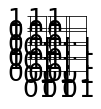

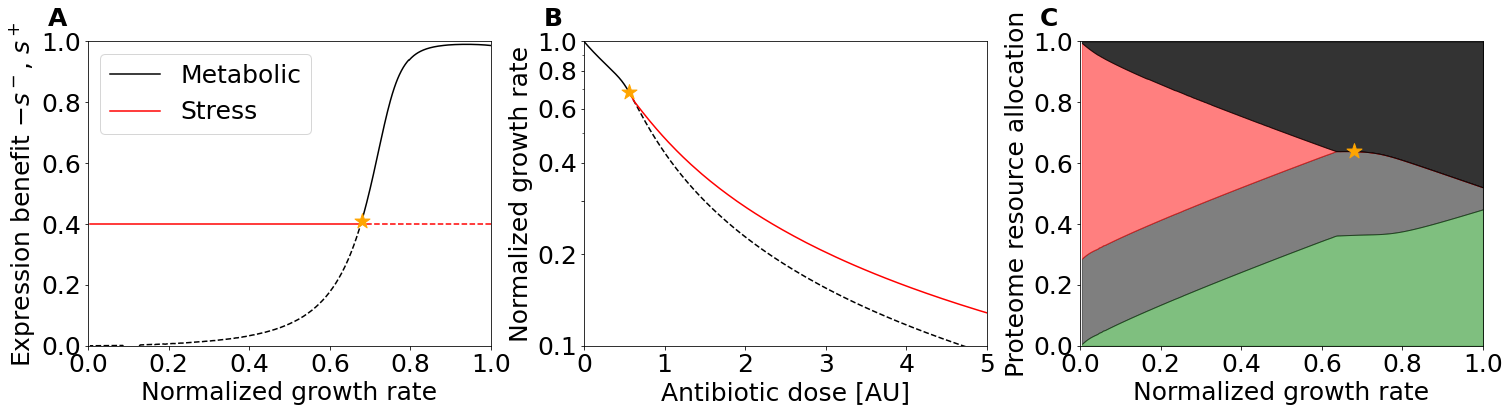

In [876]:
font = {'size'   : 25}

abcolors = ["k-", "k--", "k-"]

filename = "AntibioticInhibition_Monod3.npy"#_highKM.npy"

fullensemble = np.load(data_folder+filename)
#fullensemble = fullensemble[0][None, :, :, :]

#fullensemble = fullensemble[~np.isnan(fullensemble[:, 70, 3, -1])]
print(np.shape(fullensemble))



efficiencybins = np.logspace(-2.2 , 2.2, 12)#np.logspace(-1, 1, 6)
efficiencybins2 = np.copy(efficiencybins)

ilocs = []
ensembleref = []

faultyindices = []
for j in range(np.shape(fullensemble)[0]):
    maxgr = fullensemble[j, 0, 5, 0]
    halfgrs = (fullensemble[j, :, 5, 0].T-maxgr/1.05).T
    #halfgrs = (fullensemble[j, :, 5, 0].T-maxgr/1.2).T
    halfgrs[halfgrs<0] = np.max(halfgrs)
    tenthgrs = (fullensemble[j, :, 5, 0].T-maxgr/10.1).T
    #tenthgrs = (fullensemble[j, :, 5, 0].T-maxgr/2.1).T
    tenthgrs[tenthgrs<0] = np.max(tenthgrs)
    
    try:
        iloc = np.where(halfgrs == np.nanmin(halfgrs))
        iloc10 = np.where(tenthgrs == np.nanmin(tenthgrs))
        ilocs.append(iloc[0][0])
        ensembleref.append(np.array([fullensemble[j, 0], fullensemble[j, iloc[0][0]], fullensemble[j, iloc10[0][0]]]))
    except:
        print(j)
        faultyindices.append(j)
    #print(np.shape(np.array([ensemble[j, 0], ensemble[j, iloc]])))

ilocs = np.array(ilocs)
ensembleref = np.array(ensembleref)[:, :, :, None, :]




plt.rc('font', **font)
dt = 1e-5
fig, axs = plt.subplots(4, 3, figsize = (1, 1))
fig = plt.figure(figsize = (25, 28))
gs = gridspec.GridSpec(20, 12)
gs.update(wspace=3, hspace=0)

#axs[0, 0] = plt.subplot(gs[0:4, 1:5])
#axs[0, 1] = plt.subplot(gs[0:4, 7:11])
#axs[1, 0] = plt.subplot(gs[5:9, 1:5])
#axs[1, 1] = plt.subplot(gs[5:9, 7:11])
#axs[2, 0] = plt.subplot(gs[10:14, 1:5])
axs[2, 1] = plt.subplot(gs[15:19, 0:4])
axs[3, 0] = plt.subplot(gs[15:19, 4:8])
axs[3, 1] = plt.subplot(gs[15:19, 8:12])


#axs[0, 0].set_xlim(0.5, 20.5)
#axs[1, 0].set_xlim(0.5, 20.5)
#axs[0, 0].set_xlabel("Position")
#axs[1, 0].set_xlabel("Position")

#axs[0, 0].set_ylim(1e-1, 1e5)
#axs[1, 0].set_ylim(1e1, 1.5e4)
#axs[0, 0].add_patch(plt.Polygon([[0.5, 1e-3], [0.5, 1e5], [1.3, 1e5], [1.3, 1e-3]],facecolor='silver', clip_on=True, linewidth = 0, alpha = 0.5))
#axs[1, 0].add_patch(plt.Polygon([[0.5, 1e-1], [0.5, 1.5e4], [.8, 1.5e4], [.8, 1e-1]],facecolor='silver', clip_on=True, linewidth = 0, alpha = 0.5))
#axs[0, 0].add_patch(plt.Polygon([[9.5, 1e-3], [9.5, 1e5], [10.5, 1e5], [10.5, 1e-3]],facecolor='silver', clip_on=True, linewidth = 0, alpha = 0.5))
#axs[1, 0].add_patch(plt.Polygon([[9.5, 1e-1], [9.5, 1.5e4], [10.5, 1.5e4], [10.5, 1e-1]],facecolor='silver', clip_on=True, linewidth = 0, alpha = 0.5))


#axs[0, 0].set_yscale("log")
#axs[0, 1].set_yscale("log")
#axs[1, 0].set_yscale("log")
#axs[1, 1].set_yscale("log")

#axs[0, 0].set_ylabel(r"Saturation $\rho/K$")
#axs[0, 1].set_ylabel(r"Saturation $\rho/K$")
#axs[1, 0].set_ylabel(r"Expression $\phi/K$")
#axs[1, 1].set_ylabel(r"Expression $\phi/K$")

#axs[0, 1].set_xscale("log")
#axs[1, 1].set_xscale("log")

#axs[0, 0].set_xlabel("Position")
#axs[1, 0].set_xlabel("Position")
#axs[0, 1].set_xlabel(r"Quality $Q$")
#axs[1, 1].set_xlabel(r"Quality $Q$")

#axs[0, 1].set_xlim(.05, 20)
#axs[1, 1].set_xlim(.05, 20)
#axs[0, 1].set_ylim(1e-3, 1e3)
#axs[1, 1].set_ylim(1e-1, 1e5)

#axs[1, 0].step(np.arange(20)[::-1]+1+shift, filtered(meanNs[-1]), meancolors[i], where = "mid", linewidth = 4)
#axs[2, 0].step(np.arange(20)[::-1]+1+shift, filtered(meanNs2[-1]), meancolors[i], where = "mid", linewidth = 4)
        
#axs[0, 1].plot(y5, 10**np.mean(z5, 1), abcolors[0], linewidth = 0.6)
#axs[0, 1].plot(y1, 10**np.mean(z1, 1), abcolors[1], linewidth = 2)
#axs[0, 1].plot(y3, 10**np.mean(z3, 1), abcolors[2], linewidth = 4)

#axs[1, 1].plot(y6, 10**np.mean(z6, 1), abcolors[0], linewidth = 0.6)
#axs[1, 1].plot(y2, 10**np.mean(z2, 1), abcolors[1], linewidth = 2)
#axs[1, 1].plot(y4, 10**np.mean(z4, 1), abcolors[2], linewidth = 4)


#print(np.shape(raw3), x3, np.nanmean(raw3, 0))

logrhoref = np.log10(ensembleref[:, 0, 3, 0, :]/ensembleref[:, 0, 1, 0, :])
logphiref = np.log10(ensembleref[:, 0, 4, 0, :]/ensembleref[:, 0, 1, 0, :])
#axs[0, 0].step(x1, 10**np.nanmean(logrhoref, 0), abcolors[0], linewidth = 0.6, where = "mid")
#axs[1, 0].step(x3, 10**np.nanmean(logphiref, 0), abcolors[0], linewidth = 0.6, where = "mid")
#axs[0, 0].step(x1, 10**np.nanmean(raw1, 0), abcolors[1], linewidth = 2, where = "mid")
#axs[0, 0].step(x3, 10**np.nanmean(raw3, 0), abcolors[2], linewidth = 4, where = "mid")
#axs[1, 0].step(x2, 10**np.nanmean(raw2, 0), abcolors[1], linewidth = 2, where = "mid")
#axs[1, 0].step(x4, 10**np.nanmean(raw4, 0), abcolors[2], linewidth = 4, where = "mid")

responseCoeffs = np.array(responseCoeffs)
iloc = np.where(responseCoeffs==np.min(responseCoeffs[responseCoeffs>0.4]))[0][0]
axs[2, 1].plot(results_old[:iloc, 2, 0]/results_old[0, 2, 0], responseCoeffs[:iloc], "k-", zorder=0, label = "Metabolic")
axs[2, 1].plot(results_old[:iloc, 2, 0]/results_old[0, 2, 0], 0*results_old[:iloc, 2, 0]+0.4, "r--", zorder=1)
axs[2, 1].plot(results_old[iloc:, 2, 0]/results_old[0, 2, 0], responseCoeffs[iloc:], "k--", zorder=2)
axs[2, 1].plot(results_old[iloc:, 2, 0]/results_old[0, 2, 0], 0*results_old[iloc:, 2, 0]+0.4, "r-", zorder=3, label = "Stress")
axs[2, 1].scatter(results_old[iloc, 2, 0]/results_old[0, 2, 0], responseCoeffs[iloc], marker = "*", color = "orange", s = 250, zorder=4)
axs[2, 1].set_ylim(0, 1)
axs[2, 1].set_xlim(0, 1)
axs[2, 1].set_xlabel("Normalized growth rate")
axs[2, 1].set_ylabel(r"Expression benefit $-s^-$, $s^+$")
axs[2, 1].legend()
#ax = plt.twinx()
#ax.set_ylim(0, 1) 
#ax.set_ylabel("Expression benefit")
#ax.spines['right'].set_color('red')
#ax.tick_params(axis='y', colors='red')
#ax.yaxis.label.set_color('red')

print(iloc)


kappaspecials = np.linspace(1e-3, 1, 1000)[::-1]*kappas[ispecial]
lammax = results[0, 5, 0]
alpha = 1
for index in [0, 650, iloc, 880, 930, 980]:
    kappalocal = kappaspecials[index]
    phirefs = results[0, 4, :]
    kappaslocal = np.copy(kappas)
    kappaslocal[ispecial] = kappalocal
    lams = []
    weights = np.linspace(0, 1-results[index, 4, ispecial], 100)
    if index>820:
        marker = "k--"
    else:
        marker = "k-"
    for weight in weights:
        phis_local = np.copy(phirefs)
        phidown = np.sum(phirefs[:ispecial])
        phiup = np.sum(phirefs[ispecial+1:])
        phis_local[ispecial+1:] = phirefs[ispecial+1:]/phiup*weight
        phis_local[:ispecial] = phirefs[:ispecial]/phidown*(1-results[index, 4, ispecial]-weight)
        phis_local[ispecial] = results[index, 4, ispecial]
        #plt.scatter([weight]*Nenzymes, phis_local)
        lams.append(simulate(phis_local, kappaslocal, KMs, nu, lamapprox)/lammax)
    
    #axs[2, 0].plot(weights, lams, marker, alpha = alpha)
    alpha = alpha*0.8
#axs[2, 0].set_xlim(0, 1)
#axs[2, 0].set_ylim(0, 1.1)
#axs[2, 0].set_xlabel("Proteome resource allocation")
#axs[2, 0].set_ylabel("Normalized growth rate")


kappaspecials = np.linspace(1e-3, 1, 1000)[::-1]*kappas[ispecial]
lammax = results[0, 5, 0]
alpha = 1

axs[3, 1].set_xlim(0, 1)
axs[3, 1].set_ylim(0, 1)
axs[3, 1].set_ylabel("Proteome resource allocation")
axs[3, 1].set_xlabel("Normalized growth rate")

first = np.sum(ensemble[0, :, 4, ispecial+1:], axis = 1)
second = np.sum(ensemble[0, :, 4, :ispecial], axis = 1)
#plt.plot(first, ensemble[0, :, 5, 0]/ensemble[0, 0, 5, 0], "r--")#/ensemble[0, 0, 4, ispecial])
#plt.plot((first+phistress)[::-1], (ensemble[0, :, 5, 0]/ensemble[0, 0, 5, 0])[::-1], "r--")#/ensemble[0, 0, 4, ispecial])
axs[3, 1].fill_between(ensemble[0, :, 5, 0]/ensemble[0, 0, 5, 0], first*0, first, color = "g", alpha = 0.5, zorder = 0)
axs[3, 1].fill_between(ensemble[0, :, 5, 0]/ensemble[0, 0, 5, 0], first, first+ensemble[0, :, 4, ispecial], color = "k", alpha = 0.5, zorder = 0)
axs[3, 1].fill_between(ensemble[0, :, 5, 0]/ensemble[0, 0, 5, 0], first+ensemble[0, :, 4, ispecial], first+phistress+ensemble[0, :, 4, ispecial], color = "red", alpha = 0.5, zorder = 0)
axs[3, 1].fill_between(ensemble[0, :, 5, 0]/ensemble[0, 0, 5, 0], first+phistress+ensemble[0, :, 4, ispecial], first*0+1, color = "k", alpha = 0.8, zorder = 0)

print(phistress[iloc-1])
#plt.scatter(np.sum(results_old[iloc, 1, ispecial+1:]), results_old[iloc, 2, 0]/results_old[0, 2, 0], marker = "*", color = "orange", s = 250)
axs[3, 1].scatter(ensemble[0, iloc, 5, 0]/ensemble[0, 0, 5, 0], np.sum(ensemble[0, iloc, 4, ispecial:]), marker = "*", color = "orange", s = 250, zorder = 10)
    
    
ax = axs[3, 0]
ax.plot(((1/np.linspace(1e-3, 1, Npoints)[::-1]-1)/10)[:iloc], results_old[:iloc, 2, 0]/results_old[0, 2, 0], "k-", zorder = 0)
ax.plot(((1/np.linspace(1e-3, 1, Npoints)[::-1]-1)/10)[iloc:], results_old[iloc:, 2, 0]/results_old[0, 2, 0], "k--", zorder = 1)
ax.plot(((1/np.linspace(1e-3, 1, Npoints)[::-1]-1)/10)[iloc:], results[iloc:, 5, 0]*(0.6+np.array(phistress)[iloc:]*0.4)/(results[0, 5, 0]*(0.6+np.array(phistress)[0]*0.4)), "r-", zorder = 2)
ax.scatter(((1/np.linspace(1e-3, 1, Npoints)[::-1]-1)/10)[iloc], results_old[iloc, 2, 0]/results_old[0, 2, 0], marker = "*", color = "orange", s = 250, zorder=4)

#ax.plot((1/np.linspace(1e-3, 1, Npoints)[::-1]-1)/10, results[:, 5, 0]/(results[0, 5, 0]), "k:")
ax.set_xlim(0, 5)
#ax.ylim(0, 1)
ax.set_xlabel("Antibiotic dose [AU]")
ax.set_ylabel("Normalized growth rate")
ax.set_yscale("log")
#ax.xscale("log")
#ax.xlim(1, 1e3)
ax.set_ylim(1e-1, 1)
ax.set_yticks([0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0.1, 0.2, "", 0.4, 0.6, 0.8, 1.0])
#plt.xscale("log")

for n, ax in enumerate([axs[2, 1], axs[3, 0], axs[3, 1]]):  
    ax.text(-0.10, 1.05, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')

#plt.savefig("/Users/leonseeger/Dropbox/EffluxPumpsLeon/Draft/CommentingVersion/MainText4-3.pdf", bbox_inches="tight", format = 'pdf')


In [877]:
def findMinimal(reference, iloc):
    Nenzymes = np.shape(reference)[1]
    #print(Nenzymes)
    results_j = np.copy(reference)
    args = reference[:3, :].flatten()
    args = np.append(args, reference[3, -1])
    args = np.append(args, reference[5, 0])

    kappas = args[0:Nenzymes]
    KMs = args[Nenzymes:2*Nenzymes]
    bs = args[2*Nenzymes:3*Nenzymes]
    nu = args[3*Nenzymes]
    
    kappaspecials = np.linspace(1e-3, 1, 500)[::-1]*kappas[ispecial]
    kappaspecial = kappaspecials[iloc]

    argslocal = np.copy(args)
    argslocal[ispecial] = kappaspecial
    kappaslocal = np.copy(kappas)
    kappaslocal[ispecial] = kappaspecial

    res = minimize(wrapper3, -5, args = argslocal)
    rhos = rhoIterator(kappaslocal, KMs, nu, np.exp(res.x[0]))
    phis = findPhis(kappaslocal, KMs, rhos)
    jouts = calculatejout(rhos, phis, kappaslocal, KMs)

    jouts = jouts*reference[4, ispecial]/phis[ispecial]
    phis = phis*reference[4, ispecial]/phis[ispecial]

    results_j[3, :] = rhos
    results_j[4, :] = phis
    results_j[5, :] = jouts
    
    return results_j

In [878]:
#### Antibiotic inhibition

#### Linear Chain
#fig, axs = plt.subplots(2, 2, figsize = (10, 10))
Nenzymes = 20
#fig, axs, gs = makegrid()

filename = "AntibioticInhibition_Monod3.npy"#_highKM.npy"

fullensemble = np.load(data_folder+filename)
#fullensemble = fullensemble[0][None, :, :, :]

#fullensemble = fullensemble[~np.isnan(fullensemble[:, 70, 3, -1])]
print(np.shape(fullensemble))

efficiencybins = np.logspace(-2.2 , 2.2, 12)#np.logspace(-1, 1, 6)
efficiencybins2 = np.copy(efficiencybins)

ilocs = []
ensemble = []

faultyindices = []
for j in range(np.shape(fullensemble)[0]):
    maxgr = fullensemble[j, 0, 5, 0]
    halfgrs = (fullensemble[j, :, 5, 0].T-maxgr/1.05).T
    #halfgrs = (fullensemble[j, :, 5, 0].T-maxgr/1.2).T
    halfgrs[halfgrs<0] = np.max(halfgrs)
    tenthgrs = (fullensemble[j, :, 5, 0].T-maxgr/10.1).T
    #tenthgrs = (fullensemble[j, :, 5, 0].T-maxgr/2.1).T
    tenthgrs[tenthgrs<0] = np.max(tenthgrs)
    
    try:
        iloc = np.where(halfgrs == np.nanmin(halfgrs))
        iloc10 = np.where(tenthgrs == np.nanmin(tenthgrs))
        ilocs.append(iloc[0][0])
        ensemble.append(np.array([fullensemble[j, 0], fullensemble[j, iloc[0][0]], fullensemble[j, iloc10[0][0]]]))
    except:
        print(j)
        faultyindices.append(j)
    #print(np.shape(np.array([ensemble[j, 0], ensemble[j, iloc]])))

ilocs = np.array(ilocs)
ensemble = np.array(ensemble)[:, :, :, None, :]

#print(np.shape(smallensemble))
efficiencies = (np.sum(fullensemble[:, 0, 0, :]**(-1), 1)/np.sum(np.sqrt(fullensemble[:, 0, 1, :]/fullensemble[:, 0, 0, :]), 1)*np.sqrt(fullensemble[:, 0, 1, :]*fullensemble[:, 0, 0, :]).T).T
fullefficiencies = efficiencies[:, None, :]
efficiencies = np.delete(fullefficiencies, faultyindices, axis = 0)
print(np.shape(ensemble))
print(np.shape(efficiencies))

branch = 0
colormeshrho = np.zeros((Nenzymes, np.shape(efficiencybins)[0]-1))
colormeshphi = np.zeros((Nenzymes, np.shape(efficiencybins)[0]-1))
for i in range(np.shape(efficiencybins)[0]-1):
    mask = (efficiencies[:, branch, :]>efficiencybins[i])*(efficiencies[:, branch, :]<=efficiencybins[i+1])
    fullmask = mask[:, None, None, :]*np.ones((np.shape(ensemble)[1], np.shape(ensemble)[2]))[None, :, :, None]
    maskeddata = np.where(fullmask, ensemble[:, :, :, branch, :], np.nan)
    logsaturation = np.log10(maskeddata[:, 1, 3, :]/maskeddata[:, 0, 1, :])
    logexpression = np.log10(maskeddata[:, 1, 4, :]/maskeddata[:, 0, 1, :])
    colormeshrho[:, i] = np.nanmean(logsaturation, 0)
    colormeshphi[:, i] = np.nanmean(logexpression, 0)
    
#heatmap = axs[0, 0].pcolormesh(np.arange(Nenzymes)[::-1]+1, np.sqrt(efficiencybins[1:]*efficiencybins[:-1]), colormeshrho.T, cmap = cm, vmin = -1, vmax = 3)
#heatmap2 = axs[0, 1].pcolormesh(np.arange(Nenzymes)[::-1]+1, np.sqrt(efficiencybins[1:]*efficiencybins[:-1]), colormeshphi.T, cmap = cm, vmin = 0, vmax = 4)
#axs[0, 0].set_title(r'Saturation $\rho/K$')
#axs[0, 1].set_title(r'Expression $\phi/K$')

raw1 = np.log10(ensemble[:, 1, 3, branch, :]/ensemble[:, 0, 1, branch, :])
raw2 = np.log10(ensemble[:, 1, 4, branch, :]/ensemble[:, 0, 1, branch, :])
x1, y1, z1 = np.arange(Nenzymes)[::-1]+1, np.sqrt(efficiencybins[1:]*efficiencybins[:-1]), colormeshrho.T
x2, y2, z2 = np.arange(Nenzymes)[::-1]+1, np.sqrt(efficiencybins[1:]*efficiencybins[:-1]), colormeshphi.T


(5000, 500, 6, 20)
219
367
416
587
851
1015
1516
1535
1557
1807
1835
1859
1880
1972
2800
2902
3026
3055
3154
3224
3238
3378
3451
3507
3675
3714
3887
3946
3995
4167
4185
4207
4458
4556
4647
4719
(4964, 3, 6, 1, 20)
(4964, 1, 20)


In [879]:
#### Antibiotic inhibition

#### Linear Chain
#fig, axs = plt.subplots(2, 2, figsize = (10, 10))
Nenzymes = 20

filename = "AntibioticInhibition_Monod3.npy"#_highKM.npy"

fullensemble = np.load(data_folder+filename)


#fullensemble = fullensemble[~np.isnan(fullensemble[:, 70, 3, -1])]
print(np.shape(fullensemble))



efficiencybins = np.logspace(-2.2 , 2.2, 12)#np.logspace(-1, 1, 6)
efficiencybins2 = np.copy(efficiencybins)

ilocs = []
ensemble = []
ensemble2 = []

faultyindices = []
for j in range(np.shape(fullensemble)[0]):
    maxgr = fullensemble[j, 0, 5, 0]
    halfgrs = (fullensemble[j, :, 5, 0].T-maxgr/3.1).T
    #halfgrs = (fullensemble[j, :, 5, 0].T-maxgr/1.2).T
    halfgrs[halfgrs<0] = np.max(halfgrs)
    tenthgrs = (fullensemble[j, :, 5, 0].T-maxgr/10.1).T
    #tenthgrs = (fullensemble[j, :, 5, 0].T-maxgr/2.1).T
    tenthgrs[tenthgrs<0] = np.max(tenthgrs)
    
    try:
        iloc = np.where(halfgrs == np.nanmin(halfgrs))
        iloc10 = np.where(tenthgrs == np.nanmin(tenthgrs))
        ilocs.append(iloc[0][0])
        ensemble.append(np.array([fullensemble[j, 0], fullensemble[j, iloc[0][0]], fullensemble[j, iloc10[0][0]]]))
        
        results_j = findMinimal(fullensemble[j, iloc[0][0]], iloc[0][0])
        ensemble2.append(results_j)
    except:
        print(j)
        faultyindices.append(j)
    #print(np.shape(np.array([ensemble[j, 0], ensemble[j, iloc]])))

ilocs = np.array(ilocs)
ensemble = np.array(ensemble)[:, :, :, None, :]


#print(np.shape(smallensemble))
efficiencies = (np.sum(fullensemble[:, 0, 0, :]**(-1), 1)/np.sum(np.sqrt(fullensemble[:, 0, 1, :]/fullensemble[:, 0, 0, :]), 1)*np.sqrt(fullensemble[:, 0, 1, :]*fullensemble[:, 0, 0, :]).T).T
fullefficiencies = efficiencies[:, None, :]
efficiencies = np.delete(fullefficiencies, faultyindices, axis = 0)

print(np.shape(ensemble))
print(np.shape(ensemble2))
print(np.shape(efficiencies))

ensemble2 = np.array(ensemble2)
ensemble2_shaped = np.repeat(ensemble2[:, None, :, None, :], 3, axis = 1)
ensemble2_shaped[:, 0, :, :, :] = ensemble[:, 0, :, :, :]
ensemble2 = ensemble2_shaped

(5000, 500, 6, 20)
219
367
416
587
851
1015
1516
1535
1557
1807
1835
1859
1880
1972
2800
2902
3026
3055
3154
3224
3238
3378
3451
3507
3675
3714
3887
3946
3995
4167
4185
4207
4458
4556
4647
4719
(4964, 3, 6, 1, 20)
(4964, 6, 20)
(4964, 1, 20)


In [880]:
#fig, axs, gs = makegrid()
#print(np.shape(smallensemble2))
efficiencybins = np.logspace(-2.2 , 2.2, 12)#np.logspace(-1, 1, 6)
efficiencybins2 = np.copy(efficiencybins)
branch = 0
colormeshrho = np.zeros((Nenzymes, np.shape(efficiencybins)[0]-1))
colormeshphi = np.zeros((Nenzymes, np.shape(efficiencybins)[0]-1))
for i in range(np.shape(efficiencybins)[0]-1):
    mask = (efficiencies[:, branch, :]>efficiencybins[i])*(efficiencies[:, branch, :]<=efficiencybins[i+1])
    fullmask = mask[:, None, None, :]*np.ones((np.shape(ensemble2)[1], np.shape(ensemble2)[2]))[None, :, :, None]
    maskeddata = np.where(fullmask, ensemble2[:, :, :, branch, :], np.nan)
    logsaturation = np.log10(maskeddata[:, 1, 3, :]/maskeddata[:, 0, 1, :])
    logexpression = np.log10(maskeddata[:, 1, 4, :]/maskeddata[:, 0, 1, :])
    colormeshrho[:, i] = np.nanmean(logsaturation, 0)
    colormeshphi[:, i] = np.nanmean(logexpression, 0)
    
#heatmap = axs[0, 0].pcolormesh(np.arange(Nenzymes)[::-1]+1, np.sqrt(efficiencybins[1:]*efficiencybins[:-1]), colormeshrho.T, cmap = cm, vmin = -1, vmax = 3)
#heatmap2 = axs[0, 1].pcolormesh(np.arange(Nenzymes)[::-1]+1, np.sqrt(efficiencybins[1:]*efficiencybins[:-1]), colormeshphi.T, cmap = cm, vmin = 0, vmax = 4)
#axs[0, 0].set_title(r'Saturation $\rho/K$')
#axs[0, 1].set_title(r'Expression $\phi/K$')

raw3 = np.log10(ensemble2[:, 1, 3, branch, :]/ensemble2[:, 0, 1, branch, :])
raw4 = np.log10(ensemble2[:, 1, 4, branch, :]/ensemble2[:, 0, 1, branch, :])
x3, y3, z3 = np.arange(Nenzymes)[::-1]+1, np.sqrt(efficiencybins[1:]*efficiencybins[:-1]), colormeshrho.T
x4, y4, z4 = np.arange(Nenzymes)[::-1]+1, np.sqrt(efficiencybins[1:]*efficiencybins[:-1]), colormeshphi.T

In [881]:
ensemble = []
data_folder = "/Users/leonseeger/Desktop/largeDBFiles/"
sigma = "kappathird_Monod"
#sigma = "kappathird_Monod_highKM"
filename = "Ensemble_Rich_sigma_%s.npy"%sigma#"Ensemble_Rich_sigma_%s.npy"%sigma

reference = np.load(data_folder+filename)
for i in [9]:#range(np.shape(reference)[0]):
    print(i)
    Nenzymes = 20

    #kappamean = 10
    #KMmean = .0001

    #kappas = np.random.lognormal(np.log(kappamean), 3/3, Nenzymes) #kappamean*np.ones(Nenzymes) #3
    #kappas[0] = 1/np.sum(kappas**(-1))
    #KMs = np.random.lognormal(np.log(KMmean), 2.5, Nenzymes) #KMmean*np.ones(Nenzymes) #2
    #bs = np.ones(Nenzymes)
    kappas = reference[i, 0, 0, :]
    KMs = reference[i, 0, 1, :]
    bs = reference[i, 0, 2, :]
    nu = reference[i, 0, 3, -1]
    lamapprox = reference[i, 0, 5, 0]
    
    #nu = 200*KMmean #0.03*KMmean
    #lamapprox = .1

    args = np.array([*kappas, *KMs, *bs, nu, lamapprox])
    #res = minimize(wrapper3, -5, args = args)
    #rhosref = rhoIterator(kappas, KMs, bs, nu, np.exp(res.x[0]))
    rhosref = reference[i, 0, 3, :]

    ispecial = 10

    results_old, responseCoeffs = calculatePhiandRhoSpecialResponse(args, ispecial, rhosref, tol = 1e-7)
    params = np.concatenate((kappas[None, :], KMs[None, :], bs[None, :]), axis = 0)
    params = np.repeat(params[None, :, :], Npoints, axis=0)
    
    #results = np.concatenate((params, results), axis = 1)
    print(np.shape(results_old))
    #ensemble.append(results)
    
    
#ensemble = np.array(ensemble)

ensemble = []

data_folder = "/Users/leonseeger/Desktop/largeDBFiles/"
sigma = "kappathird_Monod"
#sigma = "kappathird_Monod_highKM"
filename = "Ensemble_Rich_sigma_%s.npy"%sigma#"Ensemble_Rich_sigma_%s.npy"%sigma

fullensemble = np.load(data_folder+filename)

for i in [9]:#range(np.shape(reference)[0]):
    print(i)
    Nenzymes = 20

    #kappamean = 10
    #KMmean = .0001

    #kappas = np.random.lognormal(np.log(kappamean), 3/3, Nenzymes) #kappamean*np.ones(Nenzymes) #3
    #kappas[0] = 1/np.sum(kappas**(-1))
    #KMs = np.random.lognormal(np.log(KMmean), 2.5, Nenzymes) #KMmean*np.ones(Nenzymes) #2
    #bs = np.ones(Nenzymes)
    kappas = reference[i, 0, 0, :]
    KMs = reference[i, 0, 1, :]
    bs = reference[i, 0, 2, :]
    nu = reference[i, 0, 3, -1]
    lamapprox = reference[i, 0, 5, 0]
    phirefs = reference[i, 0, 4, :]
    
    #nu = 200*KMmean #0.03*KMmean
    #lamapprox = .1

    args = np.array([*kappas, *KMs, *bs, nu, lamapprox])
    #res = minimize(wrapper3, -5, args = args)
    #rhosref = rhoIterator(kappas, KMs, bs, nu, np.exp(res.x[0]))
    rhosref = reference[i, 0, 3, :]

    ispecial = 10

    results, phistress = calculatePhiandRhoSpecialResponseStress(args, ispecial, rhosref, tol = 1e-7)
    params = np.concatenate((kappas[None, :], KMs[None, :], bs[None, :]), axis = 0)
    params = np.repeat(params[None, :, :], Npoints, axis=0)
    
    results = np.concatenate((params, results), axis = 1)
    print(np.shape(results))
    ensemble.append(results)
    
    
ensemble = np.array(ensemble)

9
(1000, 3, 20)
9
[-6.66159607 -5.43359214 -5.02818432 -4.1900638  -3.73970798 -6.74600975
 -7.7194022  -4.39866308 -4.56737486 -5.91257052 -3.74027694 -4.04378833
 -5.55317382 -8.06565233 -7.37047964 -7.23268126 -4.81324846 -6.00296704
 -5.75744508 -2.73394537]
[-8.64528135 -7.73363464 -7.4331194  -6.85488557 -6.56962596 -8.83775499
 -9.56186629 -7.11559932 -7.25953213 -8.34703739  0.79845526 -3.77295577
 -5.35064709 -7.92129153 -7.21754622 -7.08161661 -4.60817695 -5.83600876
 -5.58761943 -0.34501762]
(1000, 6, 20)


[1.16458095e+01 1.61569647e+00 5.47376371e-01 3.96294430e-01
 5.33787432e-01 6.13694472e+00 2.74882168e+02 6.52775934e+00
 1.75731695e+00 7.58970895e+01 5.94598368e+00 1.86675658e+00
 1.04148267e+02 8.45586493e+02 1.05675696e+03 3.08875811e+03
 1.11016882e+01 1.73710062e+02 2.59833311e+01 2.52588035e+04]
(5000, 500, 6, 20)
219
367
416
587
851
1015
1516
1535
1557
1807
1835
1859
1880
1972
2800
2902
3026
3055
3154
3224
3238
3378
3451
3507
3675
3714
3887
3946
3995
4167
4185
4207
4458
4556
4647
4719


Text(0.1, 0.05, 'Antibiotic dose')

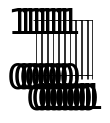

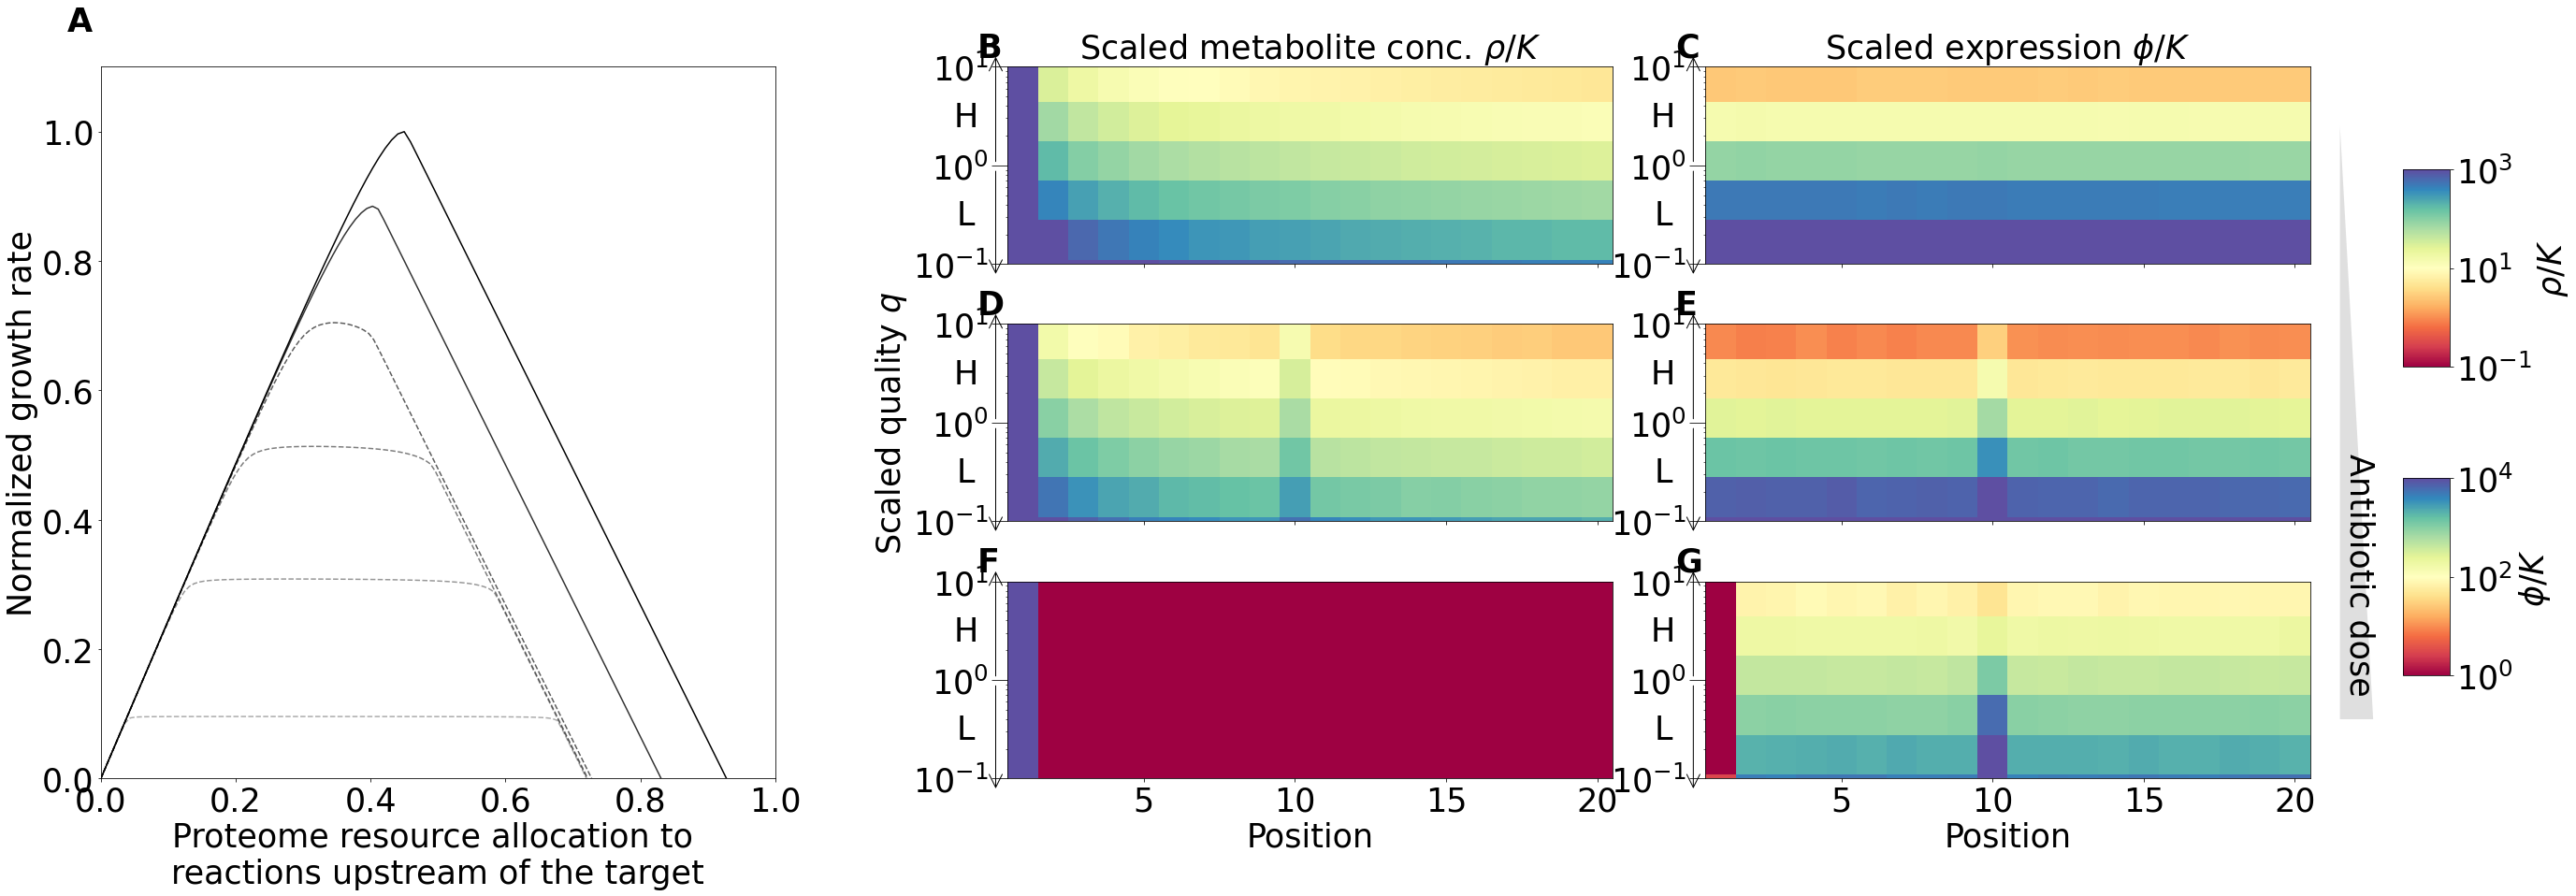

In [882]:
### The role of an antibiotic
font = {'size'   : 35}
plt.rc('font', **font)

fig, axs =plt.subplots(1, 10, figsize = (1, 1))


fig = plt.figure(figsize = (45, 14))
gs = gridspec.GridSpec(28, 34)
gs.update(wspace=0.5, hspace=0.5)

axs[0] = plt.subplot(gs[0:28, 0:10])
axs[4] = plt.subplot(gs[0:8, 13:22])
axs[5] = plt.subplot(gs[0:8, 23:32])
axs[6] = plt.subplot(gs[10:18, 13:22])
axs[7] = plt.subplot(gs[10:18, 23:32])
axs[8] = plt.subplot(gs[20:28, 13:22])
axs[9] = plt.subplot(gs[20:28, 23:32])

for n, ax in enumerate([axs[0], axs[4], axs[5], axs[6], axs[7], axs[8], axs[9]]):  
    ax.text(-0.05, 1.05, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')

print(resultsopt[0, 0, :]/KMs)
    
heatmap = axs[4].pcolormesh(x5, y5, z5, cmap = cm, vmin = -1, vmax = 3)
heatmap2 = axs[5].pcolormesh(x6, y6, z6, cmap = cm, vmin = 0, vmax = 4)

heatmap = axs[6].pcolormesh(x1, y1, z1, cmap = cm, vmin = -1, vmax = 3)
heatmap2 = axs[7].pcolormesh(x2, y2, z2, cmap = cm, vmin = 0, vmax = 4)

heatmap = axs[8].pcolormesh(x3, y3, z3, cmap = cm, vmin = -1, vmax = 3)
heatmap2 = axs[9].pcolormesh(x4, y4, z4, cmap = cm, vmin = 0, vmax = 4)
    
for ax in axs.flatten()[4:]:
    ax.set_yscale("log")
    ax.set_ylim(0.1, 10)
    ax.set_xlim(0.5, 20.5)
    ax.set_xticks([5, 10, 15, 20])
    ax.set_xticklabels([])
    #ax.set_xlabel("Position")
    #ax.set_title(r"Expression $\phi/K$")
    ax.yaxis.set_tick_params(which='major', length=17)
    ax.annotate('', xy=(-0.02, -.06), xycoords='axes fraction', xytext=(-0.02, .48), arrowprops=dict(arrowstyle="->", color='k'))
    ax.annotate('', xy=(-0.02, 1.06), xycoords='axes fraction', xytext=(-0.02, .51), arrowprops=dict(arrowstyle="->", color='k'))
    ax.text(-1.3, 2.5, "H")
    ax.text(-1.2, 1/4, "L")

axs[6].set_ylabel("Scaled quality $q$")
#ax.set_title(r"Saturation $\rho/K$")

axs[8].set_xlabel("Position")
axs[9].set_xlabel("Position")
axs[8].set_xticklabels([5, 10, 15, 20])
axs[9].set_xticklabels([5, 10, 15, 20])
axs[4].set_title(r"Scaled metabolite conc. $\rho/K$")
axs[5].set_title(r"Scaled expression $\phi/K$")    

font = {'size'   : 25}

abcolors = ["k-", "k--", "k-"]

filename = "AntibioticInhibition_Monod3.npy"#_highKM.npy"

fullensemble = np.load(data_folder+filename)
#fullensemble = fullensemble[0][None, :, :, :]

#fullensemble = fullensemble[~np.isnan(fullensemble[:, 70, 3, -1])]
print(np.shape(fullensemble))



efficiencybins = np.logspace(-2.2 , 2.2, 12)#np.logspace(-1, 1, 6)
efficiencybins2 = np.copy(efficiencybins)

ilocs = []
ensembleref = []

faultyindices = []
for j in range(np.shape(fullensemble)[0]):
    maxgr = fullensemble[j, 0, 5, 0]
    halfgrs = (fullensemble[j, :, 5, 0].T-maxgr/1.05).T
    #halfgrs = (fullensemble[j, :, 5, 0].T-maxgr/1.2).T
    halfgrs[halfgrs<0] = np.max(halfgrs)
    tenthgrs = (fullensemble[j, :, 5, 0].T-maxgr/10.1).T
    #tenthgrs = (fullensemble[j, :, 5, 0].T-maxgr/2.1).T
    tenthgrs[tenthgrs<0] = np.max(tenthgrs)
    
    try:
        iloc = np.where(halfgrs == np.nanmin(halfgrs))
        iloc10 = np.where(tenthgrs == np.nanmin(tenthgrs))
        ilocs.append(iloc[0][0])
        ensembleref.append(np.array([fullensemble[j, 0], fullensemble[j, iloc[0][0]], fullensemble[j, iloc10[0][0]]]))
    except:
        print(j)
        faultyindices.append(j)
    #print(np.shape(np.array([ensemble[j, 0], ensemble[j, iloc]])))

ilocs = np.array(ilocs)
ensembleref = np.array(ensembleref)[:, :, :, None, :]


kappaspecials = np.linspace(1e-3, 1, 1000)[::-1]*kappas[ispecial]
lammax = results[0, 5, 0]
alpha = 1
iloc = 840
for index in [0, 650, iloc, 890, 935, 980]:
    kappalocal = kappaspecials[index]
    phirefs = results[0, 4, :]
    kappaslocal = np.copy(kappas)
    kappaslocal[ispecial] = kappalocal
    lams = []
    weights = np.linspace(0, 1-results[index, 4, ispecial], 100)
    if index>820:
        marker = "k--"
    else:
        marker = "k-"
    for weight in weights:
        phis_local = np.copy(phirefs)
        phidown = np.sum(phirefs[:ispecial])
        phiup = np.sum(phirefs[ispecial+1:])
        phis_local[ispecial+1:] = phirefs[ispecial+1:]/phiup*weight
        phis_local[:ispecial] = phirefs[:ispecial]/phidown*(1-results[index, 4, ispecial]-weight)
        phis_local[ispecial] = results[index, 4, ispecial]
        #plt.scatter([weight]*Nenzymes, phis_local)
        lams.append(simulate(phis_local, kappaslocal, KMs, nu, lamapprox)/lammax)
    
    axs[0].plot(weights, lams, marker, alpha = alpha)
    alpha = alpha*0.8
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1.1)
axs[0].set_xlabel("Proteome resource allocation to \nreactions upstream of the target")
axs[0].set_ylabel("Normalized growth rate")

axcb = plt.subplot(gs[4:12, 33])
axcb2 = plt.subplot(gs[16:24, 33])

#axcb = plt.subplot(gs[3:5, 5])
#divider = make_axes_locatable(axcb)
#cax = divider.append_axes("top", size="-10%").axis('off')
#cax = divider.append_axes("bottom", size="-10%").axis('off')
#cax = divider.append_axes("left", size="100%", pad=0.05).axis('off')
#cax = divider.append_axes("right", size="200%", pad=0.05).axis('off')
cb = fig.colorbar(heatmap, cax=axcb)#, label = r"$\rho/K$")
axcb.set_yticks([-1, 1, 3])
axcb.set_yticklabels([r"$10^{-1}$", r"$10^{1}$", r"$10^{3}$"])
axcb.set_ylabel(r"$\rho/K$")

#axcb2 = plt.subplot(gs[3:5, 11])
#divider = make_axes_locatable(axcb2)
#cax = divider.append_axes("top", size="-10%").axis('off')
#cax = divider.append_axes("bottom", size="-10%").axis('off')
#cax = divider.append_axes("left", size="100%", pad=0.05).axis('off')
#cax = divider.append_axes("right", size="200%", pad=0.05).axis('off')
fig.colorbar(heatmap2, cax=axcb2)#, label = r"$\phi/K$")
axcb2.set_yticks([0, 2, 4])
axcb2.set_yticklabels([r"$10^{0}$", r"$10^{2}$", r"$10^{4}$"])
axcb2.set_ylabel(r"$\phi/K$") 

axtr = plt.subplot(gs[:, 32])
axtr.add_patch(plt.Polygon([[0,0], [0, 1], [1, 0]],facecolor='silver', clip_on=False, linewidth = 0, alpha = 0.5))
axtr.set_xlim(-0.2, 1.2)
axtr.set_ylim(-0.1, 1.1)
axtr.axis("off")
axtr.text(0.1, 0.05, "Antibiotic dose", rotation = 270)

#plt.savefig("/Users/leonseeger/Dropbox/EffluxPumpsLeon/Draft/CommentingVersion/SI_Antibiotic.pdf", bbox_inches="tight", format = 'pdf')

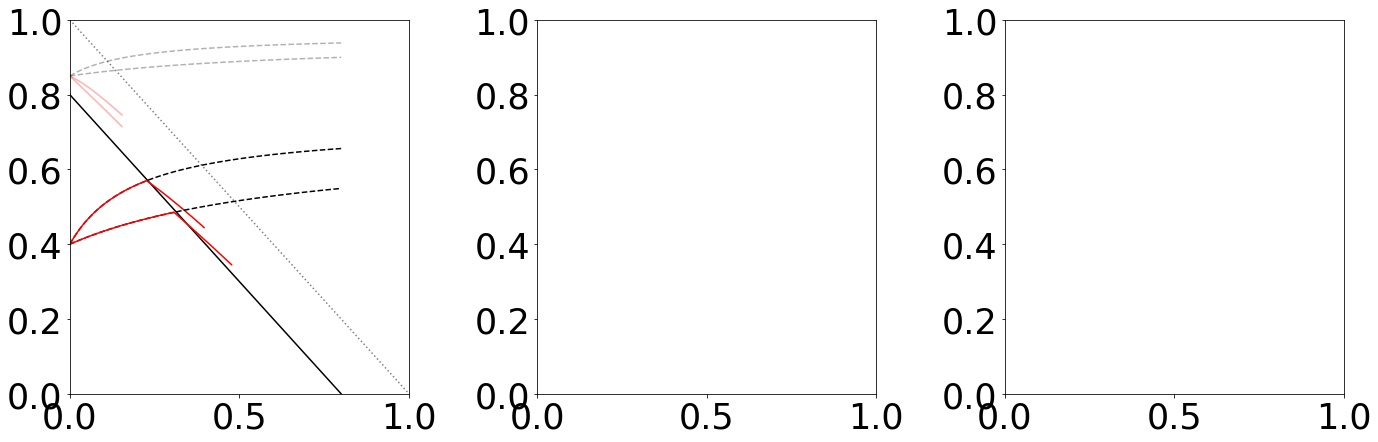

In [883]:
font = {'size'   : 35}
plt.rc('font', **font)

fig, axs =plt.subplots(1, 3, figsize = (20, 7))
fig.tight_layout()

phimax = 0.2
Nsteps = 100
phiS = np.linspace(0, 1-phimax, Nsteps)
phiS2 = np.linspace(0, 1, Nsteps)

axs[0].plot(phiS, 1-phimax-phiS, color = "k")
axs[0].plot(phiS2, 1-phiS2, color = "k", linestyle = ":", alpha = 0.5)

axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)

response1 = 0.4*(1+.8/(1+.2/phiS))
response2 = 0.4*(1+.7/(1+.7/phiS))

response3 = 0.85*(1+.13/(1+.2/phiS))
response4 = 0.85*(1+.11/(1+.7/phiS))

#diff1 = response1[1:]-response1[:-1]
#recalculated = response1[0]+np.array([0, *np.cumsum(diff1)])
#print(recalculated)

diff1 = response1[1:]-response1[:-1]
diff1_adjusted = diff1-((response1[1:]-(1-phimax-phiS[1:]))>0)*(1-phimax)/Nsteps
recalculated1 = response1[0]+np.array([0, *np.cumsum(diff1_adjusted)])
axs[0].plot(phiS, response1, color = "k", linestyle = "--")
axs[0].plot(phiS[:50], recalculated1[:50], color = "r")

diff2 = response2[1:]-response2[:-1]
diff2_adjusted = diff2-((response2[1:]-(1-phimax-phiS[1:]))>0)*(1-phimax)/Nsteps
recalculated2 = response2[0]+np.array([0, *np.cumsum(diff2_adjusted)])
axs[0].plot(phiS, response2, color = "k", linestyle = "--")
axs[0].plot(phiS[:60], recalculated2[:60], color = "r")

diff3 = response3[1:]-response3[:-1]
diff3_adjusted = diff3-((response3[1:]-(1-phimax-phiS[1:]))>0)*(1-phimax)/Nsteps
recalculated3 = response3[0]+np.array([0, *np.cumsum(diff3_adjusted)])
axs[0].plot(phiS, response3, color = "k", linestyle = "--", alpha = 0.3)
axs[0].plot(phiS[:20], recalculated3[:20], color = "r", alpha = 0.3)

diff4 = response4[1:]-response4[:-1]
diff4_adjusted = diff4-((response4[1:]-(1-phimax-phiS[1:]))>0)*(1-phimax)/Nsteps
recalculated4 = response4[0]+np.array([0, *np.cumsum(diff4_adjusted)])
axs[0].plot(phiS, response4, color = "k", linestyle = "--", alpha = 0.3)
axs[0].plot(phiS[:20], recalculated4[:20], color = "r", alpha = 0.3)